<a href="https://colab.research.google.com/github/Nicolas76661/Data/blob/main/Script_Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow scikit-learn

In [2]:
!pip install keras

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import librosa
import librosa.display
import librosa.feature

import os
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, zero_one_loss, classification_report
from sklearn.preprocessing import normalize, StandardScaler

import tensorflow as tf

import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

from xgboost import XGBClassifier
from pprint import pprint

In [4]:
from google.colab import drive
import os
import librosa

# Monter Google Drive
drive.mount('/content/drive')

# Définissons la liste avec les différentes douleurs :
class_name = ['pain cry', 'pain speech', 'not pain', 'trash']

# Création d'un dictionnaire avec les douleurs vide :
audio_files = {}

# Boucle à travers chaque catégorie
for g in class_name:
    audio_files[g] = []

    # Définir le chemin du répertoire pour chaque catégorie
    directory = f'/content/drive/My Drive/Projet/segments_par_classe/{g}'

    # Vérifier si le répertoire existe
    if os.path.exists(directory):
        # Boucle à travers chaque fichier dans le répertoire
        for audio_file in os.listdir(directory):
            # Charger le fichier audio en utilisant librosa et l'ajouter à la liste
            audio, _ = librosa.load(os.path.join(directory, audio_file))
            audio_files[g].append(audio)
    else:
        print(f"Directory '{directory}' not found.")

# Imprimer le dictionnaire
print(audio_files)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{'pain cry': [array([0.        , 0.        , 0.        , ..., 0.00130908, 0.00285604,
       0.00274583], dtype=float32), array([0.002275  , 0.00350031, 0.00237708, ..., 0.02362731, 0.03490787,
       0.02832131], dtype=float32), array([ 0.00922179,  0.01455171,  0.01619383, ..., -0.07999016,
       -0.07800469, -0.08125225], dtype=float32), array([-0.05019123, -0.07890117, -0.06732032, ..., -0.0225953 ,
       -0.01668315, -0.00315411], dtype=float32), array([-0.00537701,  0.01956308, -0.00326292, ..., -0.00379068,
       -0.01456835,  0.0073904 ], dtype=float32), array([-0.00392796, -0.02701936,  0.02965252, ..., -0.03366034,
       -0.02285025, -0.01484478], dtype=float32), array([-0.10197718, -0.1359109 , -0.09999015, ..., -0.02871715,
       -0.02502783, -0.0244126 ], dtype=float32), array([-0.00018693, -0.00334486, -0.01335901, ...,  0.00085159,
       

In [5]:
def audio_pipeline(audio):
    features = []  # Initialize the features list

    # Calcul du ZCR
    zcr = librosa.zero_crossings(audio)
    features.append(sum(zcr))

    # Calcul du spectral rolloff point
    rolloff = librosa.feature.spectral_rolloff(audio)
    features.append(np.mean(rolloff))

    # Calcul du spectral rolloff point
    rolloff = librosa.feature.spectral_rolloff(audio)
    features.append(np.mean(rolloff))

    # Calcul des moyennes des MFCC
    mfcc = librosa.feature.mfcc(audio)
    for x in mfcc:
        features.append(np.mean(x))

    return features

In [6]:
!pip install config

In [7]:
import os
import shutil
import concurrent.futures
import time

dataset_path = '/content/drive/My Drive/Projet/'

Folds = {
    1: ['BURNED By A Giant Fireworm', 'I Got Hit By A Monkey Fist For Science'],
    2: ['I Tried The World Most Painful Tattoo Removal', 'Jellyfish JOLT Coyote SHOCKING Experiment'],
    3: ['PAINFUL PINCH By This CRAZY Looking Beetle', 'STUNG By A BARK SCORPION How Bad Is It'],
    4: ['STUNG By A Giant European Hornet', 'Surviving Cobra BITE INDIA SERIES FINALE'],
    5: ['There A COBRA on my BOOT', 'TOP 5 WORST BITES RANKING My Most Painful Bite Tests']
}

test_val_classes_to_copy = ['pain cry', 'pain speech', 'trash', 'not pain']
train_classes_to_copy = ['pain cry', 'pain speech', 'trash', 'not pain']

def create_dataset_hierarchy(dataset_path):
    start_time = time.time()
    try:
        root_path = os.path.join(dataset_path, "patches_organized_per_split")
        for fold_id in range(1, len(Folds) + 1):
            for split in ['Train', 'Val', 'Test']:
                for class_id in test_val_classes_to_copy if split != 'Train' else train_classes_to_copy:
                    os.makedirs(os.path.join(root_path, f"fold_{fold_id}", split, class_id), exist_ok=True)
        print('Hiérarchie du dataset créée.')
    except OSError as e:
        print(f'Erreur lors de la création de la hiérarchie : {e}')
    end_time = time.time()
    print(f"create_dataset_hierarchy a pris {end_time - start_time} secondes.")

def copy_files(source_file, dest_file):
    try:
        if not os.path.exists(dest_file):
            shutil.copy2(source_file, dest_file)
            print(f"Copié {source_file} vers {dest_file}")
        else:
            print(f"Le fichier {dest_file} existe déjà.")
    except OSError as e:
        print(f"Erreur lors de la copie de {source_file} vers {dest_file} : {e}")

def process_video(video, split_path, classes_to_copy, segments_path, executor):
    start_time = time.time()
    for class_id in classes_to_copy:
        class_folder_path = os.path.join(segments_path, class_id)
        class_path = os.path.join(split_path, class_id)
        if os.path.exists(class_folder_path):
            for segment_file in os.listdir(class_folder_path):
                source_file = os.path.join(class_folder_path, segment_file)
                dest_file = os.path.join(class_path, f'{class_id}_{segment_file}')
                if os.path.isfile(source_file):
                    executor.submit(copy_files, source_file, dest_file)
    end_time = time.time()
    print(f"process_video pour {video} a pris {end_time - start_time} secondes.")

def organize_patches_per_fold_per_split(fold_config):
    start_time = time.time()
    try:
        segments_path = os.path.join(dataset_path, 'segments_par_classe')
        with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
            for model_num, config in fold_config.items():
                print(f'Organizing for model {model_num}...')
                for fold_id, (split, videos) in config.items():
                    fold_path = os.path.join(dataset_path, "patches_organized_per_split", f"fold_{fold_id}")
                    split_path = os.path.join(fold_path, split)
                    classes_to_copy = train_classes_to_copy if split == 'Train' else test_val_classes_to_copy
                    for video in videos:
                        process_video(video, split_path, classes_to_copy, segments_path, executor)
                print(f'Model {model_num} done.')
        print('Organisation des patches terminée.')
    except OSError as e:
        print(f'Erreur lors de l\'organisation des patches : {e}')
    end_time = time.time()
    print(f"organize_patches_per_fold_per_split a pris {end_time - start_time} secondes.")

def generate_folds_configuration():
    start_time = time.time()
    fold_ids = list(Folds.keys())
    fold_config = {}
    for i in range(5):
        model_num = i + 1
        test_fold = fold_ids[i]
        val_fold = fold_ids[(i + 1) % 5]
        train_folds = [fold for fold in fold_ids if fold not in {test_fold, val_fold}]
        fold_config[model_num] = {
            test_fold: ('Test', Folds[test_fold]),
            val_fold: ('Val', Folds[val_fold])
        }
        for fold in train_folds:
            fold_config[model_num][fold] = ('Train', Folds[fold])
    end_time = time.time()
    print(f"generate_folds_configuration a pris {end_time - start_time} secondes.")
    return fold_config

def print_model_configurations(fold_config):
    start_time = time.time()
    for model_num, config in fold_config.items():
        test_fold = val_fold = None
        train_folds = []
        for fold_id, (split, _) in config.items():
            if split == 'Test':
                test_fold = fold_id
            elif split == 'Val':
                val_fold = fold_id
            elif split == 'Train':
                train_folds.append(fold_id)
        print(f'Modèle {model_num} :')
        print(f'Test : fold_{test_fold}')
        print(f'Val : fold_{val_fold}')
        print(f'Train : {", ".join([f"fold_{fold}" for fold in train_folds])}')
        print()
    end_time = time.time()
    print(f"print_model_configurations a pris {end_time - start_time} secondes.")

if __name__ == "__main__":
    print("Début du processus...")
    create_dataset_hierarchy(dataset_path)
    fold_config = generate_folds_configuration()
    organize_patches_per_fold_per_split(fold_config)
    print_model_configurations(fold_config)
    print("Processus terminé.")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Le fichier /content/drive/My Drive/Projet/patches_organized_per_split/fold_2/Train/pain speech/pain speech_Jellyfish JOLT Coyote SHOCKING Experiment segment 39 existe déjà.
Le fichier /content/drive/My Drive/Projet/patches_organized_per_split/fold_2/Train/pain speech/pain speech_Jellyfish JOLT Coyote SHOCKING Experiment segment 40 existe déjà.
Le fichier /content/drive/My Drive/Projet/patches_organized_per_split/fold_2/Train/pain speech/pain speech_Jellyfish JOLT Coyote SHOCKING Experiment segment 41 existe déjà.
Le fichier /content/drive/My Drive/Projet/patches_organized_per_split/fold_2/Train/pain speech/pain speech_Jellyfish JOLT Coyote SHOCKING Experiment segment 45 existe déjà.
Le fichier /content/drive/My Drive/Projet/patches_organized_per_split/fold_2/Train/pain speech/pain speech_Jellyfish JOLT Coyote SHOCKING Experiment segment 46 existe déjà.
Le fichier /content/drive/My Drive/Projet/patches_organiz

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# Dossier principal sur Google Drive
main_folder = '/content/drive/My Drive/Projet/'

# Chemin vers le répertoire contenant les cinq folds
model_folder = os.path.join(main_folder, 'patches_organized_per_split')

# Fonction pour extraire les caractéristiques audio d'un fichier et retourner une liste de caractéristiques
def audio_pipeline(audio, sr=22050, n_fft=2048, hop_length=512):
    features = []

    # Calcul du taux de passage à zéro (zero-crossing rate)
    zcr = librosa.feature.zero_crossing_rate(audio, hop_length=hop_length)[0]
    features.append(np.mean(zcr))

    # Calcul du centroid spectral
    spectral_c = librosa.feature.spectral_centroid(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
    features.append(np.mean(spectral_c))

    # Calcul du spectral rolloff point
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
    features.append(np.mean(rolloff))

    # Calcul des coefficients cepstraux en fréquence (MFCC)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    for mfcc in mfccs:
        features.append(np.mean(mfcc))

    return features

# Définissons les noms des colonnes
column_names = ['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']

# Fonction pour ajouter les caractéristiques audio au dataframe pour un fold spécifique
def process_audio_file(args):
    audio_path, subfolder = args
    try:
        # Charger l'audio avec librosa
        audio, sr = librosa.load(audio_path, sr=None)  # Charger avec le sr natif
        # Extraire les caractéristiques audio
        features = audio_pipeline(audio, sr=sr)
        # Ajouter l'étiquette de classe (ici, utilisant le nom du sous-répertoire)
        features.append(subfolder)
        return features
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

def collect_files_to_process(fold_folder_path):
    subfolders = ['pain cry', 'pain speech', 'not pain', 'trash']
    files_to_process = []

    # Itérer sur les sous-répertoires
    for subfolder in subfolders:
        subfolder_path = os.path.join(fold_folder_path, subfolder)

        # Vérifier si c'est bien un répertoire
        if os.path.isdir(subfolder_path):
            # Itérer sur les fichiers audio dans le sous-répertoire
            for filename in os.listdir(subfolder_path):
                audio_path = os.path.join(subfolder_path, filename)
                files_to_process.append((audio_path, subfolder))

    return files_to_process

def add_audio_features_to_dataframe(fold_folder_path):
    files_to_process = collect_files_to_process(fold_folder_path)

    # Utilisation de ProcessPoolExecutor pour paralléliser le traitement des fichiers audio
    with ProcessPoolExecutor(max_workers=4) as executor:  # Limitez le nombre de workers pour éviter de saturer la mémoire
        results = list(tqdm(executor.map(process_audio_file, files_to_process), total=len(files_to_process), desc="Processing audio files"))

    # Ajouter les résultats valides au dataframe global
    valid_results = [result for result in results if result is not None]
    return valid_results

# Itérer sur les cinq folds pour ajouter les caractéristiques audio à df
all_features = []
for fold_num in range(1, 6):
    fold_name = f'fold_{fold_num}'
    fold_folder_path = os.path.join(model_folder, fold_name, 'Train')
    all_features.extend(add_audio_features_to_dataframe(fold_folder_path))

# Création du dataframe à partir des résultats obtenus
df = pd.DataFrame(all_features, columns=column_names)

# Enregistrer le dataframe dans un fichier CSV pour éviter de recalculer à chaque fois
df.to_csv(os.path.join(main_folder, 'audio_features.csv'), index=False)

# Afficher le dataframe avec les caractéristiques audio extraites pour tous les folds
print(df)

Processing audio files:  41%|████      | 1037/2547 [03:23<03:34,  7.05it/s]

In [ ]:
# Assurez-vous que df est bien défini et contient les données mélangées
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Sauvegarder le dataframe dans un fichier CSV sur Google Drive
df_shuffled.to_csv('/content/drive/My Drive/Projet/segments_audio_video.csv', index=False)

# Afficher un message de confirmation
print("Dataframe sauvegardé en CSV avec succès.")

Dataframe sauvegardé en CSV avec succès.


In [ ]:
import pandas as pd

# Lire le DataFrame depuis le fichier CSV
df = pd.read_csv("/content/drive/My Drive/Projet/segments_audio_video.csv")

# Mélanger les lignes du DataFrame
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Définir les tailles des ensembles
train_size = int(0.6 * len(df_shuffled))
val_size = int(0.2 * len(df_shuffled))
test_size = len(df_shuffled) - train_size - val_size

# Diviser le DataFrame en ensembles d'entraînement, de validation et de test
train_df = df_shuffled.iloc[:train_size]
val_df = df_shuffled.iloc[train_size:train_size + val_size]
test_df = df_shuffled.iloc[train_size + val_size:]

# Enregistrer les DataFrames dans des fichiers CSV séparés
train_df.to_csv('/content/drive/My Drive/Projet/train_segments_audio_video.csv', index=False)
val_df.to_csv('/content/drive/My Drive/Projet/val_segments_audio_video.csv', index=False)
test_df.to_csv('/content/drive/My Drive/Projet/test_segments_audio_video.csv', index=False)

print(f'Train set size: {len(train_df)}')
print(f'Validation set size: {len(val_df)}')
print(f'Test set size: {len(test_df)}')

# Afficher les premières lignes du DataFrame
df.head()

Train set size: 7029
Validation set size: 2343
Test set size: 2343


zcr   spectral_c      rolloff      mfcc1      mfcc2      mfcc3  \
0  0.082726  1913.780668  3878.224809 -312.76950  101.19888   4.490517   
1  0.113262  2454.564841  5062.575961 -293.05878   85.58574   2.740363   
2  0.060062  1536.648437  3044.175405 -203.60574  126.56832  16.210915   
3  0.110634  2090.738968  3881.822003 -313.58320  100.13692   5.055382   
4  0.096334  2084.595799  4250.334546 -328.73108   98.52363   9.161642   

       mfcc4      mfcc5      mfcc6      mfcc7  ...    mfcc12     mfcc13  \
0  26.536234  15.994209   4.745851 -12.004531  ...  2.187299  -1.342045   
1  16.734910  -5.574831  14.485019 -11.909644  ...  7.645422  -1.875736   
2  35.432114  -0.717898   9.995131  -6.515727  ... -0.682723 -11.669179   
3  31.062960  23.513890   1.456973 -13.214177  ... -1.279926  -4.893197   
4  29.170486  10.245329   7.542978  -6.726090  ...  2.738108  -3.113042   

     mfcc14    mfcc15    mfcc16     mfcc17    mfcc18    mfcc19    mfcc20  \
0 -1.297140 -5.081236  3.574074  -4.974046  4.011372 -0.578109  3.936314   
1  2.889616  3.397618  3.469004   1.010781  4.698660 -2.095550  1.339777   
2 -9.575300 -9.104660 -5.923147 -14.551504 -4.434826 -5.749943 -3.409545   
3 -7.784591  0.116379  6.935969  -6.351922  2.463117  0.872077  3.573898   
4  1.372620 -0.241530  1.621077  -4.521364  4.698549  1.525576  2.009500   

      label  
0  pain cry  
1  not pain  
2     trash  
3  pain cry  
4  not pain  

[5 rows x 24 columns]

In [ ]:
import os
import pandas as pd

dataset_path = '/content/drive/My Drive/Projet/'  # Chemin vers votre dataset

# Exemple de configuration Folds
Folds = {
    1: ['BURNED By A Giant Fireworm', 'I Got Hit By A Monkey Fist For Science'],
    2: ['I Tried The World Most Painful Tattoo Removal', 'Jellyfish JOLT Coyote SHOCKING Experiment'],
    3: ['PAINFUL PINCH By This CRAZY Looking Beetle', 'STUNG By A BARK SCORPION How Bad Is It'],
    4: ['STUNG By A Giant European Hornet', 'Surviving Cobra BITE INDIA SERIES FINALE'],
    5: ['There A COBRA on my BOOT', 'TOP 5 WORST BITES RANKING My Most Painful Bite Tests']
}

test_val_classes_to_copy = ['pain cry', 'pain speech', 'trash', 'not pain']

def generate_folds_configuration():
    """Génère les configurations de folds pour les cinq modèles."""
    fold_ids = list(Folds.keys())
    fold_config = {}

    for i in range(5):
        model_num = i + 1
        test_fold = fold_ids[i]
        val_fold = fold_ids[(i + 1) % 5]
        train_folds = [fold for fold in fold_ids if fold not in {test_fold, val_fold}]

        fold_config[model_num] = {
            test_fold: ('Test', Folds[test_fold]),
            val_fold: ('Val', Folds[val_fold])
        }

        for fold in train_folds:
            if fold not in fold_config[model_num]:
                fold_config[model_num][fold] = ('Train', Folds[fold])

    return fold_config

def create_test_dataframe(model_num, fold_config):
    """Crée un DataFrame pour les données de test d'un modèle donné."""
    test_files = []

    for fold_id, (split, _) in fold_config[model_num].items():
        if split == 'Test':
            fold_path = os.path.join(dataset_path, "patches_organized_per_split", f"fold_{fold_id}", 'Test')
            for class_id in test_val_classes_to_copy:
                class_path = os.path.join(fold_path, class_id)
                if os.path.exists(class_path):
                    for file_name in os.listdir(class_path):
                        if os.path.isfile(os.path.join(class_path, file_name)):
                            test_files.append((class_id, file_name))

    test_df = pd.DataFrame(test_files, columns=['Class', 'File'])
    return test_df

# Générer la configuration des folds
fold_config = generate_folds_configuration()

# Utilisation de la boucle pour imprimer les DataFrames de test pour chaque modèle
for model_num in range(1, 6):
    test_df = create_test_dataframe(model_num, fold_config)
    print(f'Test DataFrame for Model {model_num}:')
    print(test_df)
    print()

Test DataFrame for Model 1:
         Class                                               File
0     pain cry  pain cry_BURNED By A Giant Fireworm_TOP 5 WORS...
1     pain cry  pain cry_BURNED By A Giant Fireworm_TOP 5 WORS...
2     pain cry  pain cry_BURNED By A Giant Fireworm_TOP 5 WORS...
3     pain cry  pain cry_BURNED By A Giant Fireworm_TOP 5 WORS...
4     pain cry  pain cry_BURNED By A Giant Fireworm_TOP 5 WORS...
...        ...                                                ...
1014  not pain  not pain_I Got Hit By A Monkey Fist For Scienc...
1015  not pain  not pain_I Got Hit By A Monkey Fist For Scienc...
1016  not pain  not pain_I Got Hit By A Monkey Fist For Scienc...
1017  not pain  not pain_I Got Hit By A Monkey Fist For Scienc...
1018  not pain  not pain_I Got Hit By A Monkey Fist For Scienc...

[1019 rows x 2 columns]

Test DataFrame for Model 2:
         Class                                               File
0     pain cry  pain cry_TOP 5 WORST BITES RANKING My Most P

In [ ]:
import os
import pandas as pd

dataset_path = '/content/drive/My Drive/Projet/'  # Chemin vers votre dataset

# Exemple de configuration Folds
Folds = {
    1: ['BURNED By A Giant Fireworm', 'I Got Hit By A Monkey Fist For Science'],
    2: ['I Tried The World Most Painful Tattoo Removal', 'Jellyfish JOLT Coyote SHOCKING Experiment'],
    3: ['PAINFUL PINCH By This CRAZY Looking Beetle', 'STUNG By A BARK SCORPION How Bad Is It'],
    4: ['STUNG By A Giant European Hornet', 'Surviving Cobra BITE INDIA SERIES FINALE'],
    5: ['There A COBRA on my BOOT', 'TOP 5 WORST BITES RANKING My Most Painful Bite Tests']
}

test_val_classes_to_copy = ['pain cry', 'pain speech', 'trash', 'not pain']

def generate_folds_configuration():
    """Génère les configurations de folds pour les cinq modèles."""
    fold_ids = list(Folds.keys())
    fold_config = {}

    for i in range(5):
        model_num = i + 1
        test_fold = fold_ids[i]
        val_fold = fold_ids[(i + 1) % 5]
        train_folds = [fold for fold in fold_ids if fold not in {test_fold, val_fold}]

        fold_config[model_num] = {
            test_fold: ('Test', Folds[test_fold]),
            val_fold: ('Val', Folds[val_fold])
        }

        for fold in train_folds:
            if fold not in fold_config[model_num]:
                fold_config[model_num][fold] = ('Train', Folds[fold])

    return fold_config

def create_test_dataframe(model_num, fold_config):
    """Crée un DataFrame pour les données de test d'un modèle donné."""
    test_files = []

    for fold_id, (split, _) in fold_config[model_num].items():
        if split == 'Test':
            fold_path = os.path.join(dataset_path, "patches_organized_per_split", f"fold_{fold_id}", 'Test')
            for class_id in test_val_classes_to_copy:
                class_path = os.path.join(fold_path, class_id)
                if os.path.exists(class_path):
                    for file_name in os.listdir(class_path):
                        if os.path.isfile(os.path.join(class_path, file_name)):
                            test_files.append((class_id, file_name))

    test_df = pd.DataFrame(test_files, columns=['Class', 'File'])
    return test_df

# Générer la configuration des folds
fold_config = generate_folds_configuration()

# Utilisation de la boucle pour imprimer les DataFrames de test pour chaque modèle
for model_num in range(1, 6):
    test_df = create_test_dataframe(model_num, fold_config)
    print(f'Test DataFrame for Model {model_num}:')
    print(test_df)
    print()

Test DataFrame for Model 1:
         Class                                               File
0     pain cry  pain cry_BURNED By A Giant Fireworm_TOP 5 WORS...
1     pain cry  pain cry_BURNED By A Giant Fireworm_TOP 5 WORS...
2     pain cry  pain cry_BURNED By A Giant Fireworm_TOP 5 WORS...
3     pain cry  pain cry_BURNED By A Giant Fireworm_TOP 5 WORS...
4     pain cry  pain cry_BURNED By A Giant Fireworm_TOP 5 WORS...
...        ...                                                ...
1014  not pain  not pain_I Got Hit By A Monkey Fist For Scienc...
1015  not pain  not pain_I Got Hit By A Monkey Fist For Scienc...
1016  not pain  not pain_I Got Hit By A Monkey Fist For Scienc...
1017  not pain  not pain_I Got Hit By A Monkey Fist For Scienc...
1018  not pain  not pain_I Got Hit By A Monkey Fist For Scienc...

[1019 rows x 2 columns]

Test DataFrame for Model 2:
         Class                                               File
0     pain cry  pain cry_TOP 5 WORST BITES RANKING My Most P

In [ ]:
import os
import pandas as pd

dataset_path = '/content/drive/My Drive/Projet/'  # Chemin vers votre dataset

# Exemple de configuration Folds
Folds = {
    1: ['BURNED By A Giant Fireworm', 'I Got Hit By A Monkey Fist For Science'],
    2: ['I Tried The World Most Painful Tattoo Removal', 'Jellyfish JOLT Coyote SHOCKING Experiment'],
    3: ['PAINFUL PINCH By This CRAZY Looking Beetle', 'STUNG By A BARK SCORPION How Bad Is It'],
    4: ['STUNG By A Giant European Hornet', 'Surviving Cobra BITE INDIA SERIES FINALE'],
    5: ['There A COBRA on my BOOT', 'TOP 5 WORST BITES RANKING My Most Painful Bite Tests']
}

test_val_classes_to_copy = ['pain cry', 'pain speech', 'trash', 'not pain']

def generate_folds_configuration():
    """Génère les configurations de folds pour les cinq modèles."""
    fold_ids = list(Folds.keys())
    fold_config = {}

    for i in range(5):
        model_num = i + 1
        test_fold = fold_ids[i]
        val_fold = fold_ids[(i + 1) % 5]
        train_folds = [fold for fold in fold_ids if fold not in {test_fold, val_fold}]

        fold_config[model_num] = {
            test_fold: ('Test', Folds[test_fold]),
            val_fold: ('Val', Folds[val_fold])
        }

        for fold in train_folds:
            if fold not in fold_config[model_num]:
                fold_config[model_num][fold] = ('Train', Folds[fold])

    return fold_config

def create_val_dataframe(model_num, fold_config):
    """Crée un DataFrame pour les données de validation d'un modèle donné."""
    val_files = []

    for fold_id, (split, _) in fold_config[model_num].items():
        if split == 'Val':
            fold_path = os.path.join(dataset_path, "patches_organized_per_split", f"fold_{fold_id}", 'Val')
            for class_id in test_val_classes_to_copy:
                class_path = os.path.join(fold_path, class_id)
                if os.path.exists(class_path):
                    for file_name in os.listdir(class_path):
                        if os.path.isfile(os.path.join(class_path, file_name)):
                            val_files.append((class_id, file_name))

    val_df = pd.DataFrame(val_files, columns=['Class', 'File'])
    return val_df

# Générer la configuration des folds
fold_config = generate_folds_configuration()

# Utilisation de la boucle pour imprimer les DataFrames de validation pour chaque modèle
for model_num in range(1, 6):
    val_df = create_val_dataframe(model_num, fold_config)
    print(f'Val DataFrame for Model {model_num}:')
    print(val_df)
    print()

Val DataFrame for Model 1:
         Class                                               File
0     pain cry  pain cry_TOP 5 WORST BITES RANKING My Most Pai...
1     pain cry  pain cry_TOP 5 WORST BITES RANKING My Most Pai...
2     pain cry  pain cry_TOP 5 WORST BITES RANKING My Most Pai...
3     pain cry  pain cry_TOP 5 WORST BITES RANKING My Most Pai...
4     pain cry  pain cry_TOP 5 WORST BITES RANKING My Most Pai...
...        ...                                                ...
1523  not pain  not pain_Jellyfish JOLT Coyote SHOCKING Experi...
1524  not pain  not pain_Jellyfish JOLT Coyote SHOCKING Experi...
1525  not pain  not pain_Jellyfish JOLT Coyote SHOCKING Experi...
1526  not pain  not pain_Jellyfish JOLT Coyote SHOCKING Experi...
1527  not pain  not pain_Jellyfish JOLT Coyote SHOCKING Experi...

[1528 rows x 2 columns]

Val DataFrame for Model 2:
         Class                                               File
0     pain cry  pain cry_PAINFUL PINCH By This CRAZY Looking B

In [ ]:
import os
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

dataset_path = '/content/drive/My Drive/Projet/'  # Chemin vers votre dataset

# Exemple de configuration Folds
Folds = {
    1: ['BURNED By A Giant Fireworm', 'I Got Hit By A Monkey Fist For Science'],
    2: ['I Tried The World Most Painful Tattoo Removal', 'Jellyfish JOLT Coyote SHOCKING Experiment'],
    3: ['PAINFUL PINCH By This CRAZY Looking Beetle', 'STUNG By A BARK SCORPION How Bad Is It'],
    4: ['STUNG By A Giant European Hornet', 'Surviving Cobra BITE INDIA SERIES FINALE'],
    5: ['There A COBRA on my BOOT', 'TOP 5 WORST BITES RANKING My Most Painful Bite Tests']
}

test_val_classes_to_copy = ['pain cry', 'pain speech', 'trash', 'not pain']

def generate_folds_configuration():
    """Génère les configurations de folds pour les cinq modèles."""
    fold_ids = list(Folds.keys())
    fold_config = {}

    for i in range(5):
        model_num = i + 1
        test_fold = fold_ids[i]
        val_fold = fold_ids[(i + 1) % 5]
        train_folds = [fold for fold in fold_ids if fold not in {test_fold, val_fold}]

        fold_config[model_num] = {
            test_fold: ('Test', Folds[test_fold]),
            val_fold: ('Val', Folds[val_fold])
        }

        for fold in train_folds:
            if fold not in fold_config[model_num]:
                fold_config[model_num][fold] = ('Train', Folds[fold])

    return fold_config

def create_test_dataframe(model_num, fold_config):
    """Crée un DataFrame pour les données de test d'un modèle donné."""
    test_files = []

    for fold_id, (split, _) in fold_config[model_num].items():
        if split == 'Test':
            fold_path = os.path.join(dataset_path, "patches_organized_per_split", f"fold_{fold_id}", 'Test')
            for class_id in test_val_classes_to_copy:
                class_path = os.path.join(fold_path, class_id)
                if os.path.exists(class_path):
                    for file_name in os.listdir(class_path):
                        if os.path.isfile(os.path.join(class_path, file_name)):
                            test_files.append((class_id, file_name))

    test_df = pd.DataFrame(test_files, columns=['Class', 'File'])
    return test_df

def select_features_with_variance_threshold(model_num, df):
    """Sélectionne les caractéristiques avec VarianceThreshold pour un modèle donné."""
    features_to_select = ['zcr', 'spectral_c', 'rolloff',
                          'mfcc1', 'mfcc2', 'mfcc3',
                          'mfcc4', 'mfcc5', 'mfcc6',
                          'mfcc7', 'mfcc8', 'mfcc9',
                          'mfcc10', 'mfcc11', 'mfcc12',
                          'mfcc13', 'mfcc14', 'mfcc15',
                          'mfcc16', 'mfcc17', 'mfcc18',
                          'mfcc19', 'mfcc20']

    selector = VarianceThreshold(threshold=0.2)
    selected_features = selector.fit_transform(df[features_to_select])

    selected_df = pd.DataFrame(selected_features, columns=[f'model_{model_num}_feat_{i}' for i in range(selected_features.shape[1])])
    return selected_df

# Générer la configuration des folds
fold_config = generate_folds_configuration()

# Chargement du DataFrame à partir du CSV
df = pd.read_csv("/content/drive/My Drive/Projet/segments_audio_video.csv")

# Boucle pour appliquer la sélection de caractéristiques à chaque modèle
for model_num in range(1, 6):
    selected_features_df = select_features_with_variance_threshold(model_num, df)
    print(f'Selected features DataFrame for Model {model_num}:')
    print(selected_features_df)
    print()

Selected features DataFrame for Model 1:
       model_1_feat_0  model_1_feat_1  model_1_feat_2  model_1_feat_3  \
0         1913.780668     3878.224809      -312.76950      101.198880   
1         2454.564841     5062.575961      -293.05878       85.585740   
2         1536.648437     3044.175405      -203.60574      126.568320   
3         2090.738968     3881.822003      -313.58320      100.136920   
4         2084.595799     4250.334546      -328.73108       98.523630   
...               ...             ...             ...             ...   
11710     2563.279870     4525.669772      -268.25952       79.579865   
11711     1323.746599     2437.073972      -305.35950      139.067290   
11712     2093.817488     4021.238252      -269.45456      103.322150   
11713     2169.209850     4088.136068      -247.98233       97.083920   
11714     2217.818701     4743.749660      -262.13116       99.559250   

       model_1_feat_4  model_1_feat_5  model_1_feat_6  model_1_feat_7  \
0        

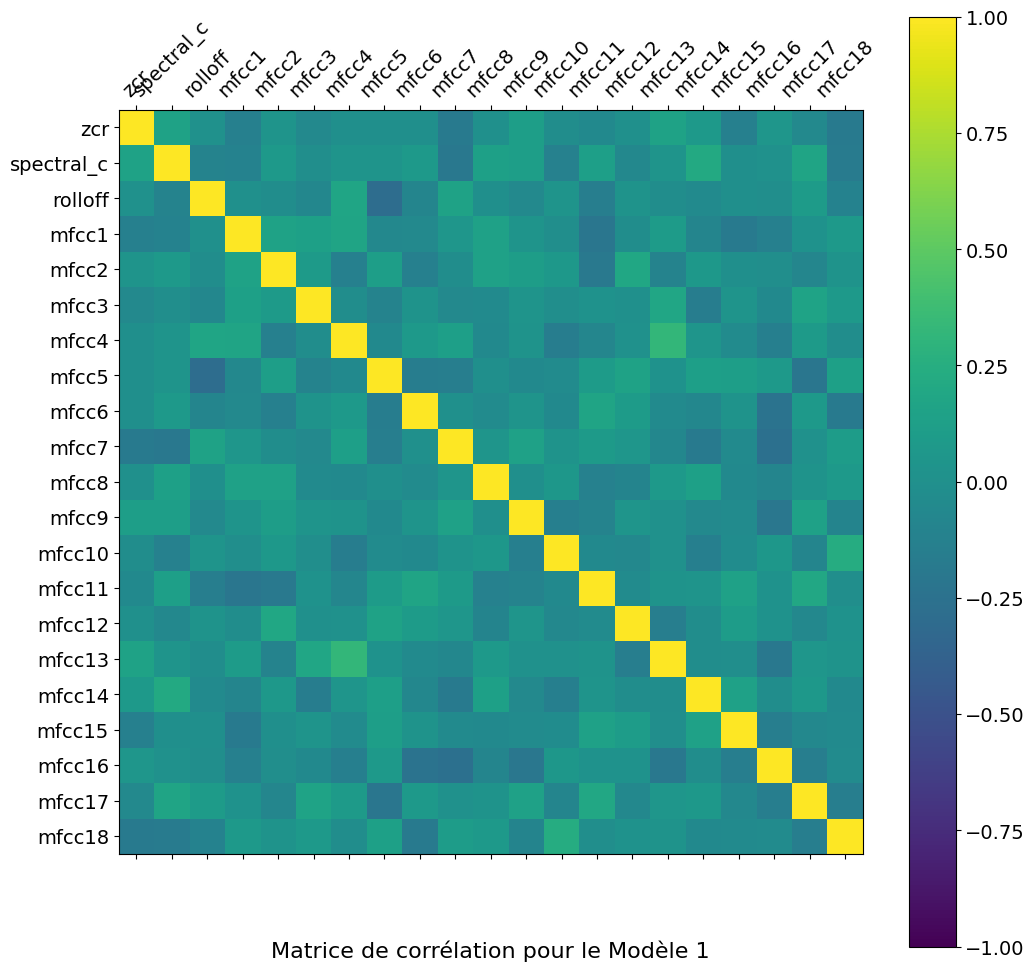

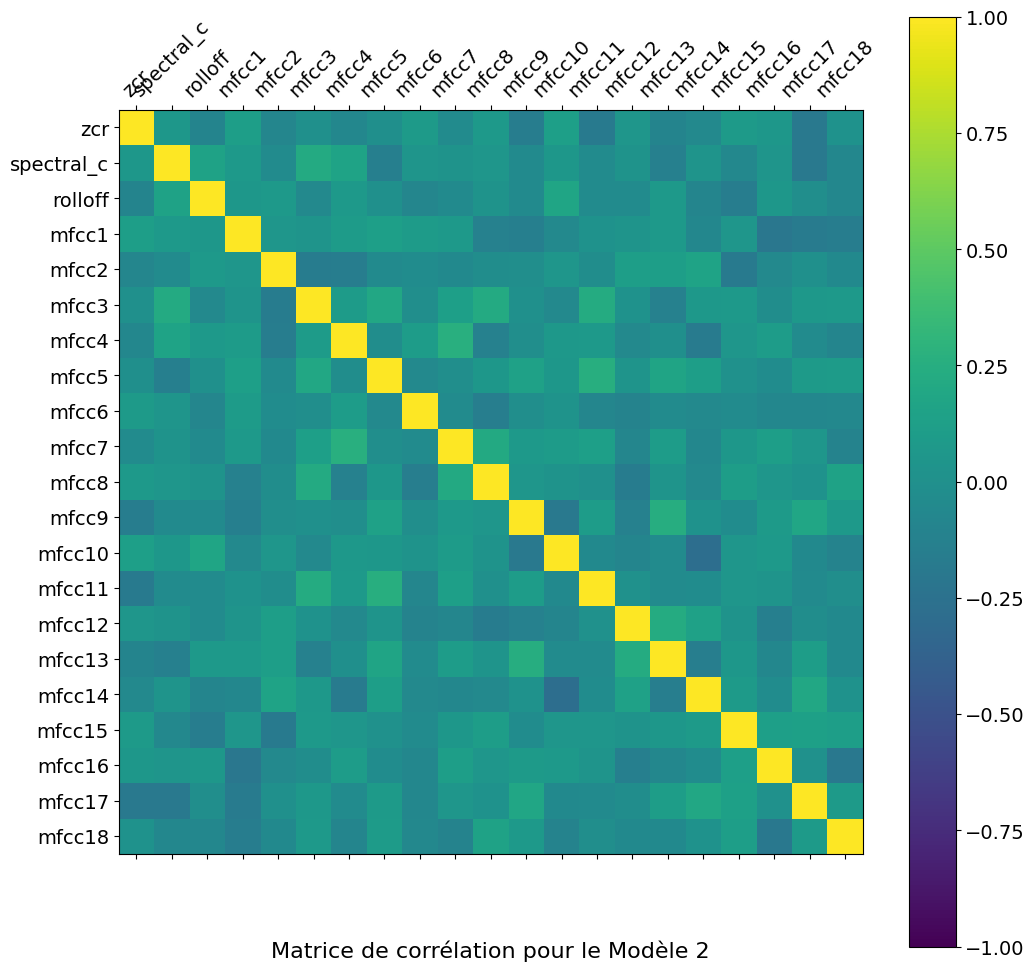

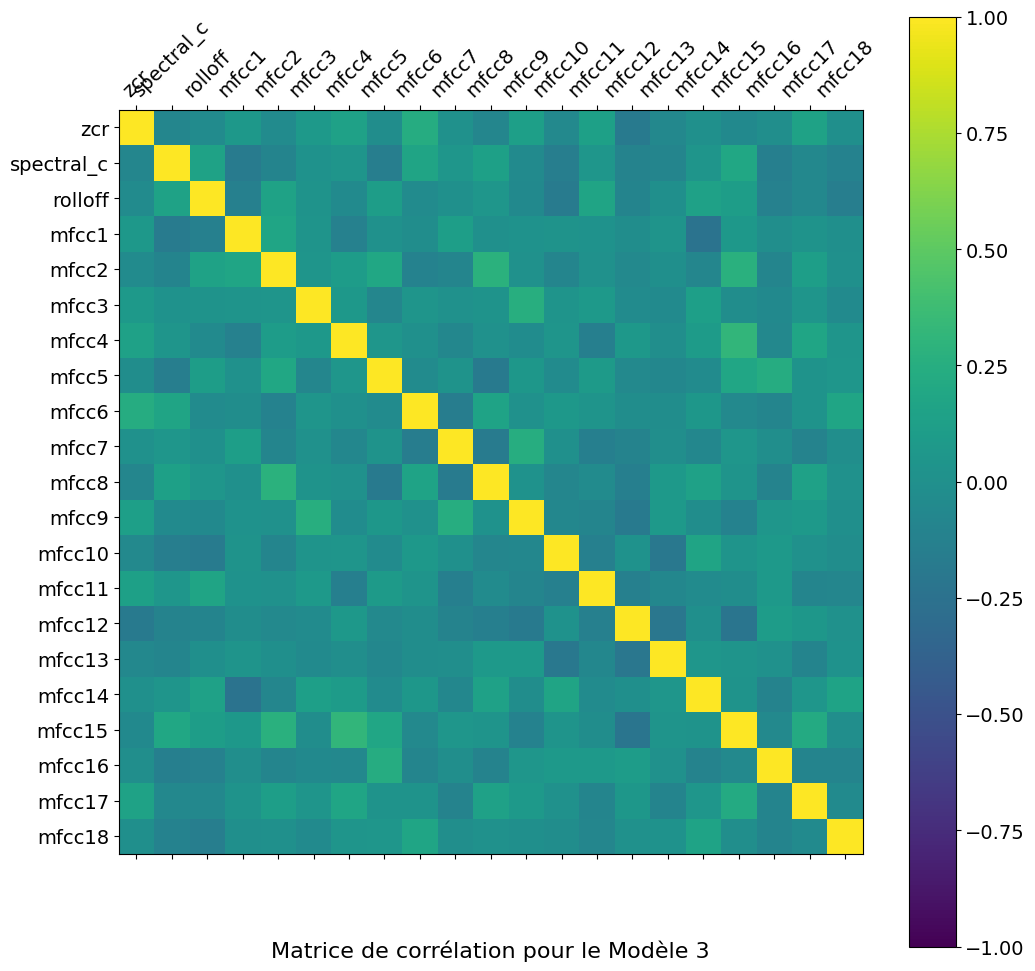

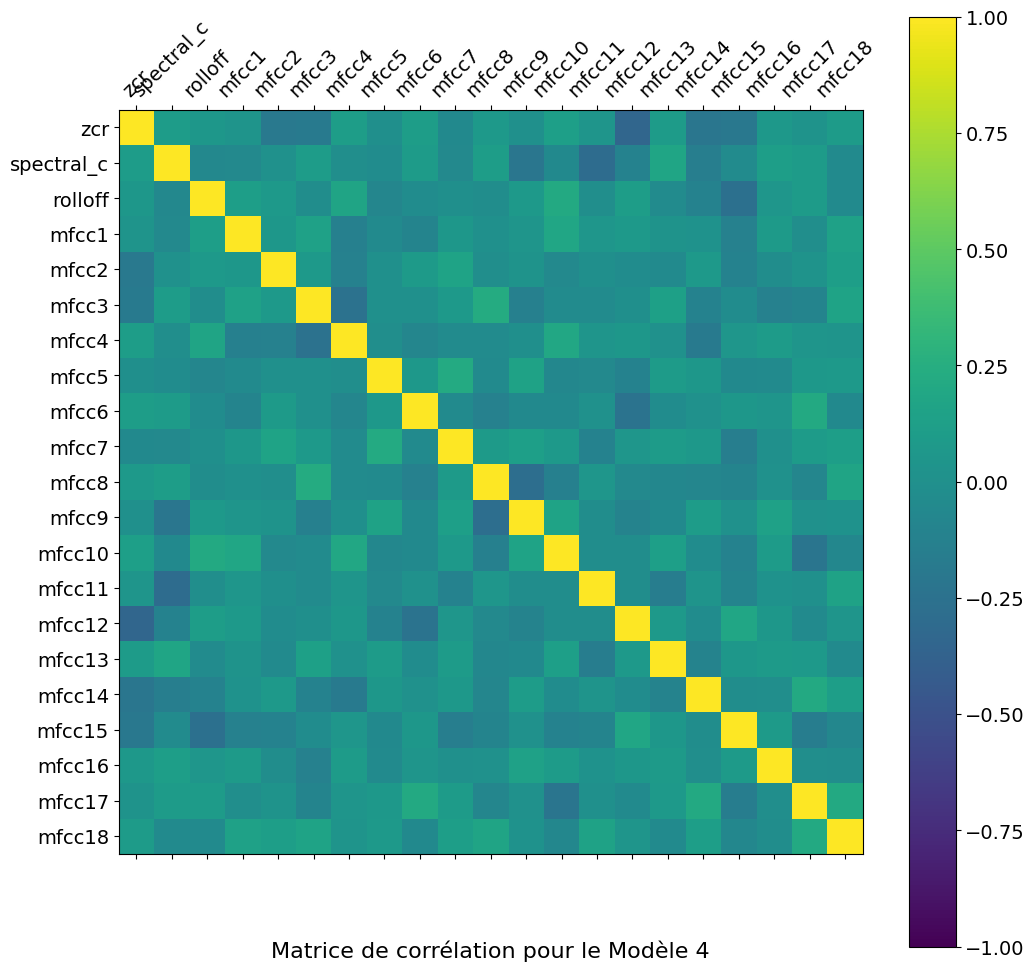

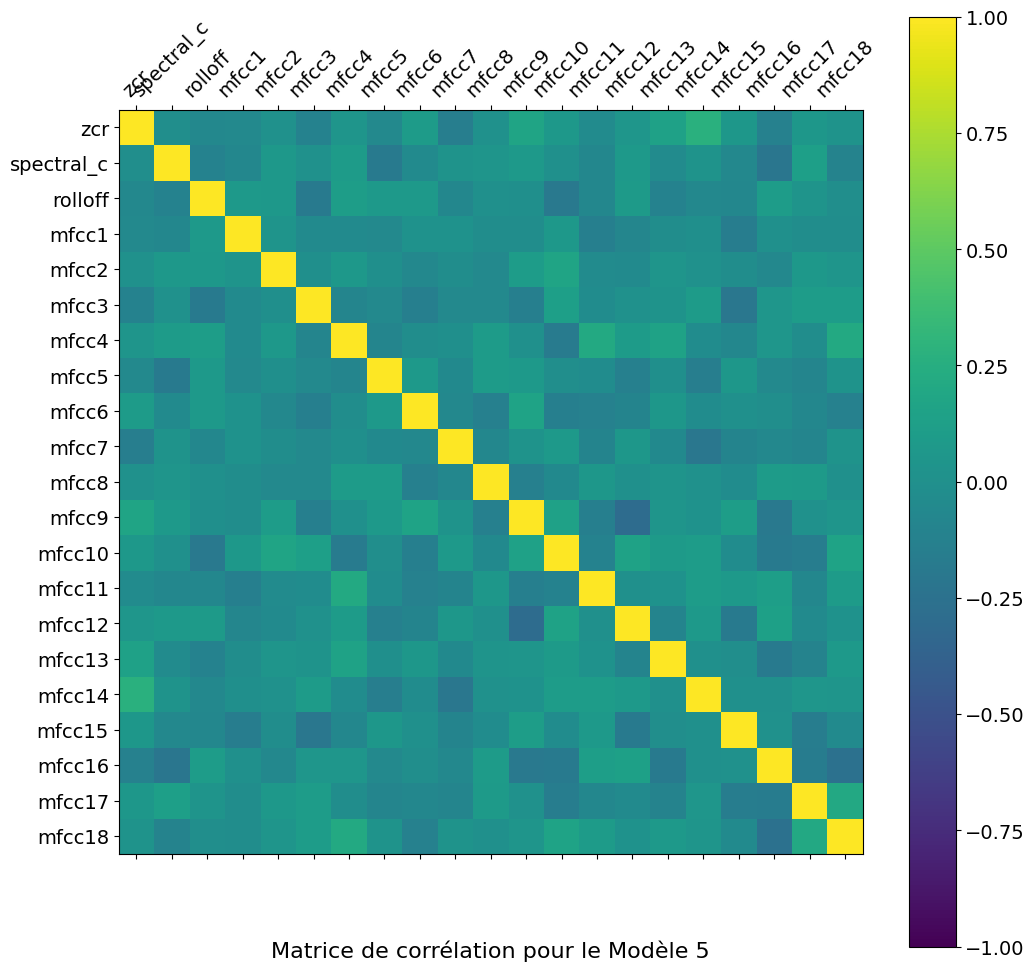

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Exemple de configuration Folds
Folds = {
    1: ['BURNED By A Giant Fireworm', 'I Got Hit By A Monkey Fist For Science'],
    2: ['I Tried The World Most Painful Tattoo Removal', 'Jellyfish JOLT Coyote SHOCKING Experiment'],
    3: ['PAINFUL PINCH By This CRAZY Looking Beetle', 'STUNG By A BARK SCORPION How Bad Is It'],
    4: ['STUNG By A Giant European Hornet', 'Surviving Cobra BITE INDIA SERIES FINALE'],
    5: ['There A COBRA on my BOOT', 'TOP 5 WORST BITES RANKING My Most Painful Bite Tests']
}

test_val_classes_to_copy = ['pain cry', 'pain speech', 'trash', 'not pain']

def generate_folds_configuration():
    """Génère les configurations de folds pour les cinq modèles."""
    fold_ids = list(Folds.keys())
    fold_config = {}

    for i in range(5):
        model_num = i + 1
        test_fold = fold_ids[i]
        val_fold = fold_ids[(i + 1) % 5]
        train_folds = [fold for fold in fold_ids if fold not in {test_fold, val_fold}]

        fold_config[model_num] = {
            test_fold: ('Test', Folds[test_fold]),
            val_fold: ('Val', Folds[val_fold])
        }

        for fold in train_folds:
            if fold not in fold_config[model_num]:
                fold_config[model_num][fold] = ('Train', Folds[fold])

    return fold_config

def plot_correlation_matrix(df, model_num):
    """Affiche la matrice de corrélation pour les caractéristiques numériques d'un DataFrame."""
    numeric_df = df.drop(columns=['label'])
    correlation_matrix = numeric_df.corr()

    f = plt.figure(figsize=(12,12))
    plt.matshow(correlation_matrix, fignum=f.number, vmin=-1, vmax=1)
    plt.xticks(range(numeric_df.shape[1]), numeric_df.columns, fontsize=14, rotation=45)
    plt.yticks(range(numeric_df.shape[1]), numeric_df.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title(f'Matrice de corrélation pour le Modèle {model_num}', fontsize=16, y=-0.15)  # Utilisation de model_num dans le titre
    plt.show()

# Générer la configuration des folds
fold_config = generate_folds_configuration()

# Exemple de récupération des DataFrames pour chaque modèle (à adapter à votre cas d'utilisation)
# Supposons que vous avez une fonction get_model_dataframe(model_num) pour récupérer le DataFrame pour chaque modèle
def get_model_dataframe(model_num):
    # Exemple de génération de DataFrame fictif pour chaque modèle
    # Remplacez ceci par votre méthode de récupération réelle
    num_rows = 100  # Nombre de lignes pour le modèle
    num_cols = 22   # Nombre de colonnes pour le modèle (incluant 'label' et les caractéristiques)
    return pd.DataFrame(data=np.random.rand(num_rows, num_cols), columns=['label', 'zcr', 'spectral_c', 'rolloff',
                                                                          'mfcc1', 'mfcc2', 'mfcc3',
                                                                          'mfcc4', 'mfcc5', 'mfcc6',
                                                                          'mfcc7', 'mfcc8', 'mfcc9',
                                                                          'mfcc10', 'mfcc11', 'mfcc12',
                                                                          'mfcc13', 'mfcc14', 'mfcc15',
                                                                          'mfcc16', 'mfcc17', 'mfcc18'])

# Boucle pour appliquer la visualisation de la matrice de corrélation à chaque modèle
for model_num in range(1, 6):
    df_model = get_model_dataframe(model_num)  # Récupérer le DataFrame pour chaque modèle
    plot_correlation_matrix(df_model, model_num)  # Passer le numéro de modèle à la fonction

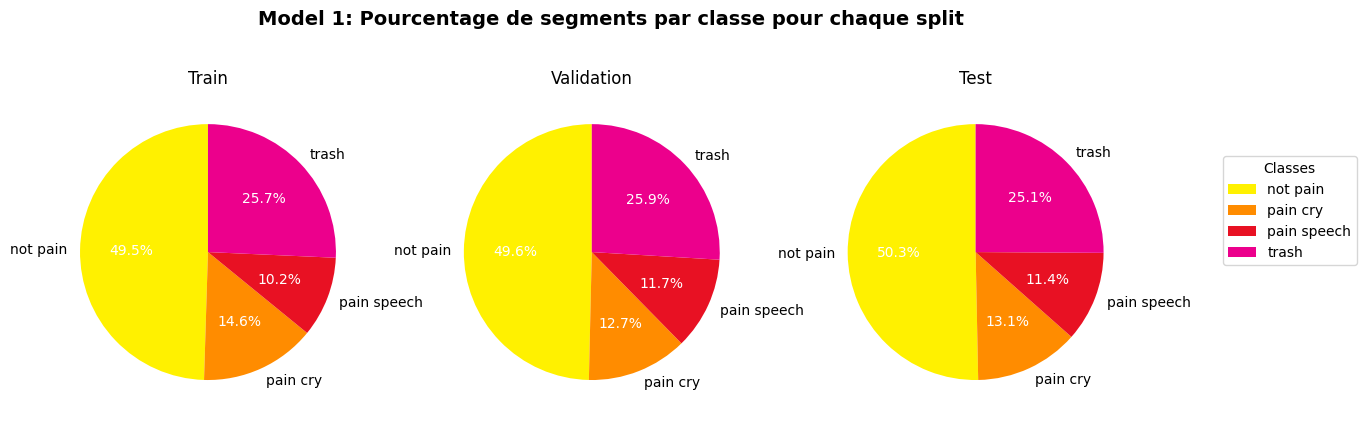

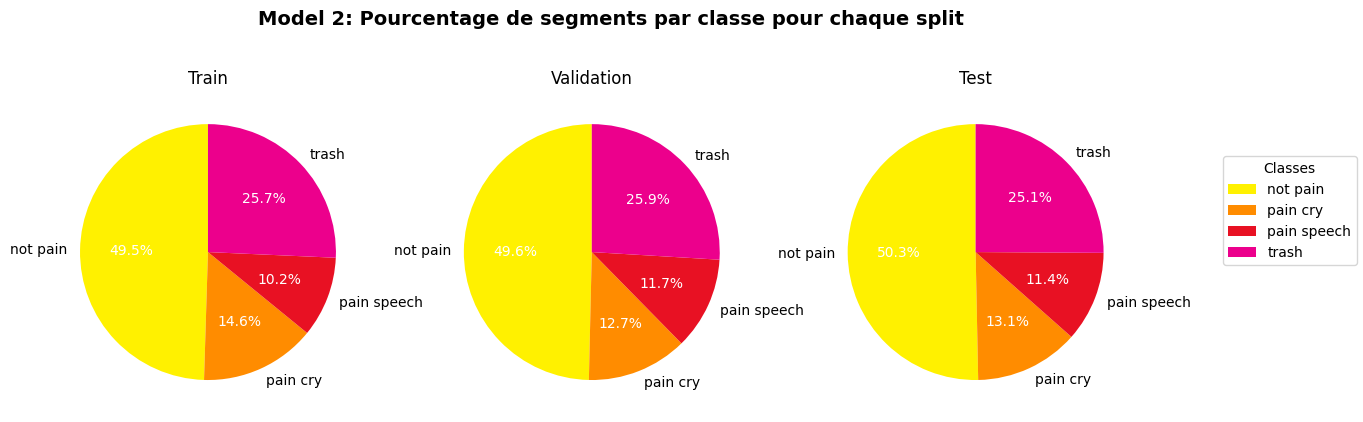

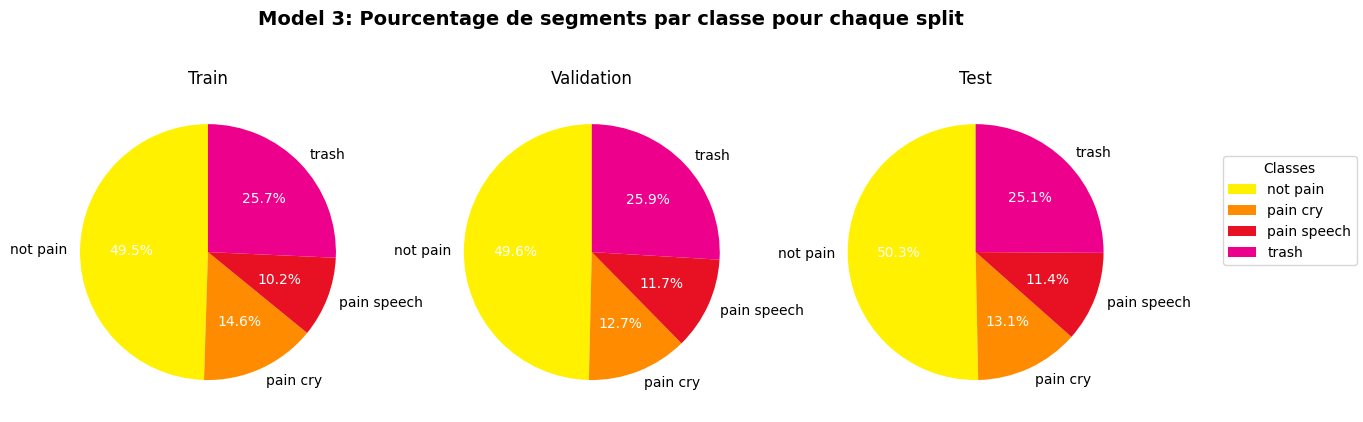

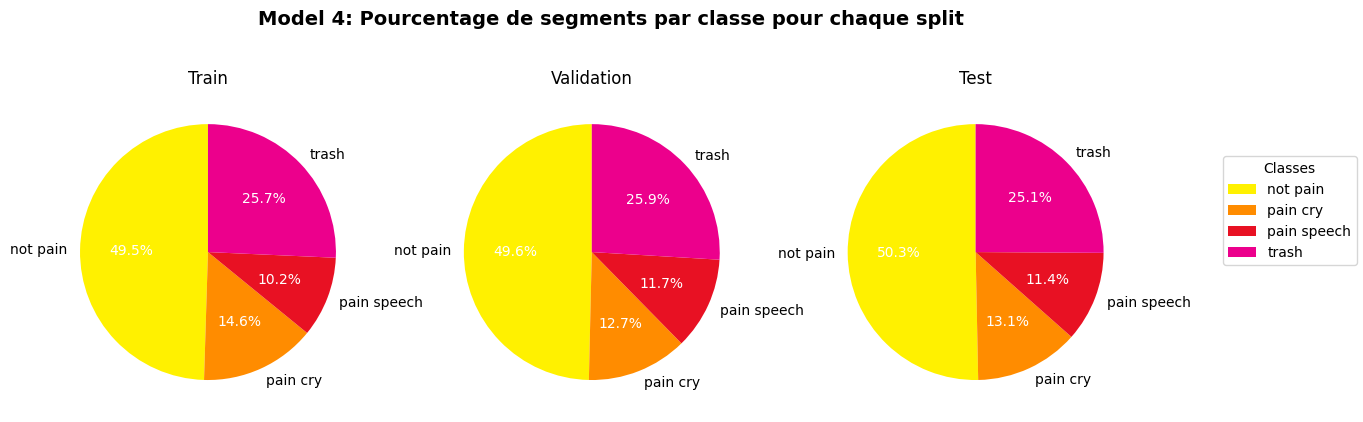

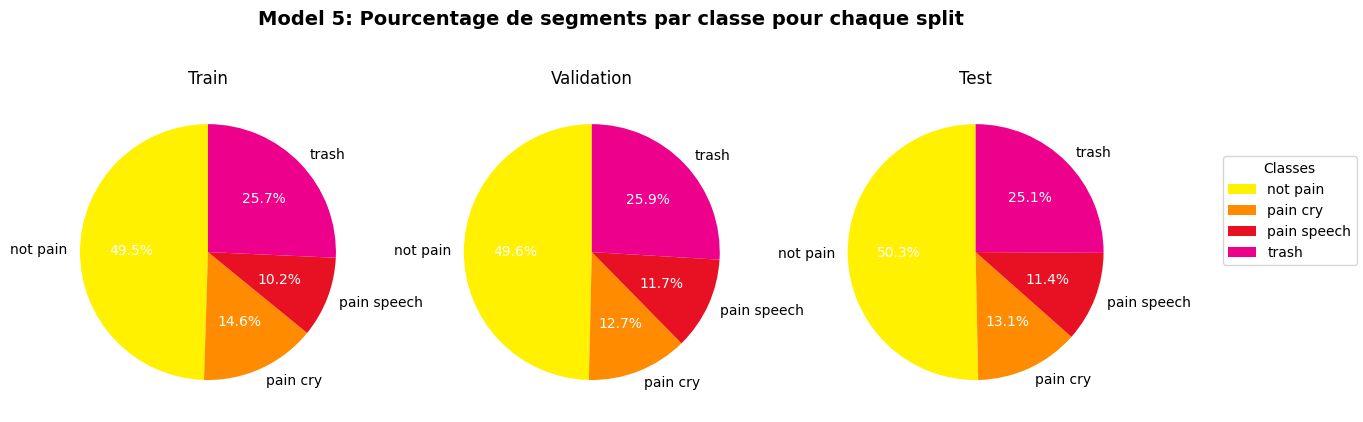

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

dataset_path = '/content/drive/My Drive/Projet/'  # Chemin vers votre dataset

# Exemple de configuration Folds
Folds = {
    1: ['BURNED By A Giant Fireworm', 'I Got Hit By A Monkey Fist For Science'],
    2: ['I Tried The World Most Painful Tattoo Removal', 'Jellyfish JOLT Coyote SHOCKING Experiment'],
    3: ['PAINFUL PINCH By This CRAZY Looking Beetle', 'STUNG By A BARK SCORPION How Bad Is It'],
    4: ['STUNG By A Giant European Hornet', 'Surviving Cobra BITE INDIA SERIES FINALE'],
    5: ['There A COBRA on my BOOT', 'TOP 5 WORST BITES RANKING My Most Painful Bite Tests']
}

def load_dataframe(model_num, dataset_path):
    """Charge le DataFrame à partir des fichiers CSV pour un modèle donné."""
    train_df = pd.read_csv(os.path.join(dataset_path, f'train_segments_audio_video.csv'))
    val_df = pd.read_csv(os.path.join(dataset_path, f'val_segments_audio_video.csv'))
    test_df = pd.read_csv(os.path.join(dataset_path, f'test_segments_audio_video.csv'))
    return train_df, val_df, test_df

def plot_class_distribution(train_counts, val_counts, test_counts, class_names, model_num):
    """Affiche le graphique de distribution des classes pour un modèle donné."""
    # Couleurs
    colors = ['#fff100', '#ff8c00', '#e81123', '#ec008c']

    # Création de la figure et des sous-graphiques
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Boucle sur les ensembles de données (train, validation, test)
    for ax, counts, title in zip(axs, [train_counts, val_counts, test_counts], ['Train', 'Validation', 'Test']):
        wedges, _, autotexts = ax.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90, colors=colors)
        ax.set_title(title)

        # Configuration des pourcentages
        for autotext in autotexts:
            autotext.set_color('white')  # Texte en blanc
            autotext.set_fontsize(10)  # Taille de police

    # Ajout d'un titre global au graphique
    fig.suptitle(f'Model {model_num}: Pourcentage de segments par classe pour chaque split', fontsize=14, fontweight='bold')

    # Ajustement de l'espace entre les sous-graphiques pour laisser de la place à la légende
    plt.subplots_adjust(right=0.85)

    # Légende des différentes classes à droite
    fig.legend(wedges, class_names, title="Classes", loc="center right")

    plt.show()

# Chargement et affichage des graphiques pour chaque modèle
for model_num in range(1, 6):
    train_df, val_df, test_df = load_dataframe(model_num, dataset_path)

    # Calcul des décomptes par classe pour les DataFrames
    train_counts = train_df['label'].value_counts().sort_index()
    val_counts = val_df['label'].value_counts().sort_index()
    test_counts = test_df['label'].value_counts().sort_index()

    class_names = train_counts.index.tolist()  # Utilisation des noms de classe à partir des décomptes du jeu d'entraînement

    # Affichage du graphique pour ce modèle
    plot_class_distribution(train_counts, val_counts, test_counts, class_names, model_num)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

dataset_path = '/content/drive/My Drive/Projet/'  # Chemin vers votre dataset

# Exemple de configuration Folds
Folds = {
    1: ['BURNED By A Giant Fireworm', 'I Got Hit By A Monkey Fist For Science'],
    2: ['I Tried The World Most Painful Tattoo Removal', 'Jellyfish JOLT Coyote SHOCKING Experiment'],
    3: ['PAINFUL PINCH By This CRAZY Looking Beetle', 'STUNG By A BARK SCORPION How Bad Is It'],
    4: ['STUNG By A Giant European Hornet', 'Surviving Cobra BITE INDIA SERIES FINALE'],
    5: ['There A COBRA on my BOOT', 'TOP 5 WORST BITES RANKING My Most Painful Bite Tests']
}

def load_dataframe(model_num, dataset_path):
    """Charge le DataFrame à partir des fichiers CSV pour un modèle donné."""
    train_df = pd.read_csv(os.path.join(dataset_path, f'train_segments_audio_video.csv'))
    val_df = pd.read_csv(os.path.join(dataset_path, f'val_segments_audio_video.csv'))
    test_df = pd.read_csv(os.path.join(dataset_path, f'test_segments_audio_video.csv'))
    return train_df, val_df, test_df

# Boucle pour charger et diviser les données pour chaque modèle
for model_num in range(1, 6):
    # Charger les DataFrames pour ce modèle
    train_df, val_df, test_df = load_dataframe(model_num, dataset_path)

    # Extraire les caractéristiques et les étiquettes
    X = train_df[['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
                  'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
                  'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
                  'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']]
    y = train_df['label']

    # Diviser les données en train, validation et test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Affichage des tailles des ensembles pour ce modèle
    print(f"Modèle {model_num}:")
    print("Train set:", X_train.shape, y_train.shape)
    print("Validation set:", X_val.shape, y_val.shape)
    print("Test set:", X_test.shape, y_test.shape)
    print()

Modèle 1:
Train set: (5623, 23) (5623,)
Validation set: (703, 23) (703,)
Test set: (703, 23) (703,)

Modèle 2:
Train set: (5623, 23) (5623,)
Validation set: (703, 23) (703,)
Test set: (703, 23) (703,)

Modèle 3:
Train set: (5623, 23) (5623,)
Validation set: (703, 23) (703,)
Test set: (703, 23) (703,)

Modèle 4:
Train set: (5623, 23) (5623,)
Validation set: (703, 23) (703,)
Test set: (703, 23) (703,)

Modèle 5:
Train set: (5623, 23) (5623,)
Validation set: (703, 23) (703,)
Test set: (703, 23) (703,)



Modèle 1:
Train score :  0.9712619149238868
Validation score :  0.9671361502347418
Test score :  0.969270166453265



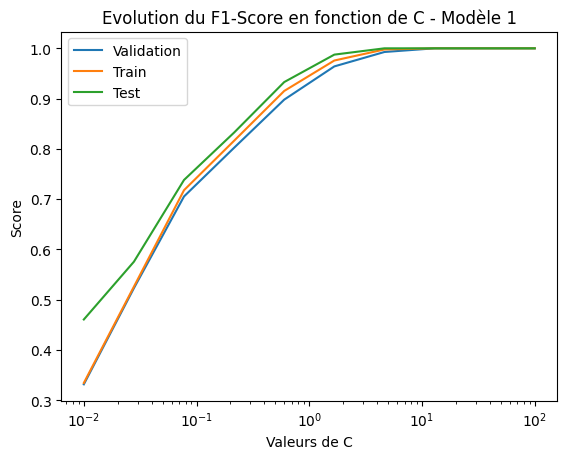

Modèle 2:
Train score :  0.9712619149238868
Validation score :  0.9671361502347418
Test score :  0.969270166453265



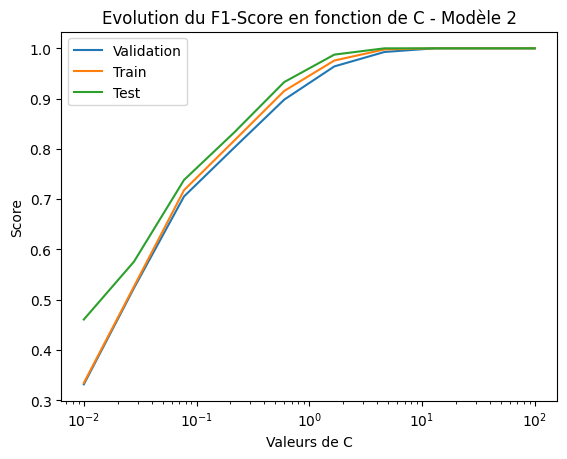

Modèle 3:
Train score :  0.9712619149238868
Validation score :  0.9671361502347418
Test score :  0.969270166453265



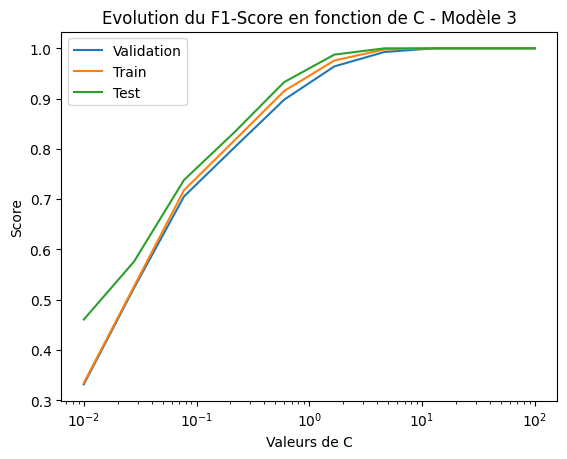

Modèle 4:
Train score :  0.9712619149238868
Validation score :  0.9671361502347418
Test score :  0.969270166453265



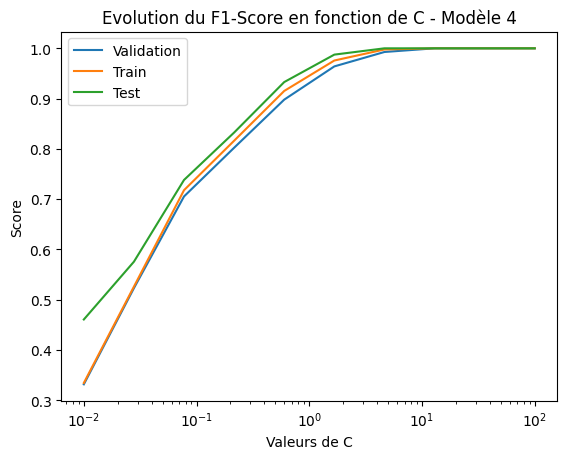

Modèle 5:
Train score :  0.9712619149238868
Validation score :  0.9671361502347418
Test score :  0.969270166453265



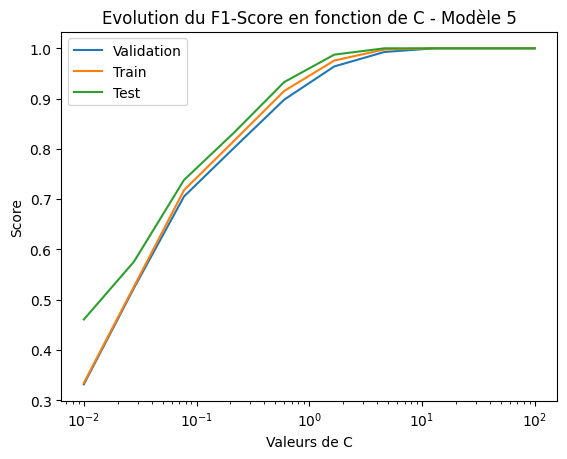

In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, validation_curve
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os

dataset_path = '/content/drive/My Drive/Projet/'  # Chemin vers votre dataset

# Exemple de configuration Folds
Folds = {
    1: ['BURNED By A Giant Fireworm', 'I Got Hit By A Monkey Fist For Science'],
    2: ['I Tried The World Most Painful Tattoo Removal', 'Jellyfish JOLT Coyote SHOCKING Experiment'],
    3: ['PAINFUL PINCH By This CRAZY Looking Beetle', 'STUNG By A BARK SCORPION How Bad Is It'],
    4: ['STUNG By A Giant European Hornet', 'Surviving Cobra BITE INDIA SERIES FINALE'],
    5: ['There A COBRA on my BOOT', 'TOP 5 WORST BITES RANKING My Most Painful Bite Tests']
}

# Fonction pour charger les DataFrames pour un modèle donné
def load_data(model_num, dataset_path):
    train_df = pd.read_csv(os.path.join(dataset_path, f'train_segments_audio_video.csv'))
    val_df = pd.read_csv(os.path.join(dataset_path, f'val_segments_audio_video.csv'))
    test_df = pd.read_csv(os.path.join(dataset_path, f'test_segments_audio_video.csv'))
    return train_df, val_df, test_df

# Boucle pour charger et entraîner les modèles SVM pour chaque modèle
for model_num in range(1, 6):
    # Charger les données
    train_df, val_df, test_df = load_data(model_num, dataset_path)

    # Prétraitement des données
    X_train = train_df.drop(columns=['label'])
    X_val = val_df.drop(columns=['label'])
    X_test = test_df.drop(columns=['label'])

    y_train = train_df['label']
    y_val = val_df['label']
    y_test = test_df['label']

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_val = label_encoder.transform(y_val)
    y_test = label_encoder.transform(y_test)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Entraînement du modèle SVM avec kernel RBF
    model_svc = SVC(kernel='rbf')
    model_svc.fit(X_train_scaled, y_train)

    # Scores du modèle
    print(f'Modèle {model_num}:')
    print('Train score : ', model_svc.score(X_train_scaled, y_train))
    print('Validation score : ', model_svc.score(X_val_scaled, y_val))
    print('Test score : ', model_svc.score(X_test_scaled, y_test))
    print()

    # Définition de la validation croisée stratifiée K-fold
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Calcul des courbes de validation pour différents paramètres C
    param_range = np.logspace(-2, 2, 10)
    tr_score, val_score = validation_curve(SVC(kernel='rbf'), X_train_scaled, y_train, param_name='C', param_range=param_range, cv=skf, scoring='f1_weighted')

    # Calcul des scores de test pour chaque valeur de C
    test_scores = []
    for c in param_range:
        model_svc = SVC(kernel='rbf', C=c)
        model_svc.fit(X_train_scaled, y_train)
        y_pred = model_svc.predict(X_test_scaled)
        test_scores.append(f1_score(y_test, y_pred, average='weighted'))

    # Affichage des courbes de validation avec la courbe de test
    plt.plot(param_range, val_score.mean(axis=1), label='Validation')
    plt.plot(param_range, tr_score.mean(axis=1), label='Train')
    plt.plot(param_range, test_scores, label='Test')

    # Titre et légendes
    plt.title(f'Evolution du F1-Score en fonction de C - Modèle {model_num}')
    plt.legend()
    plt.xlabel('Valeurs de C')
    plt.ylabel('Score')
    plt.xscale('log')
    plt.show()

Training model 1...


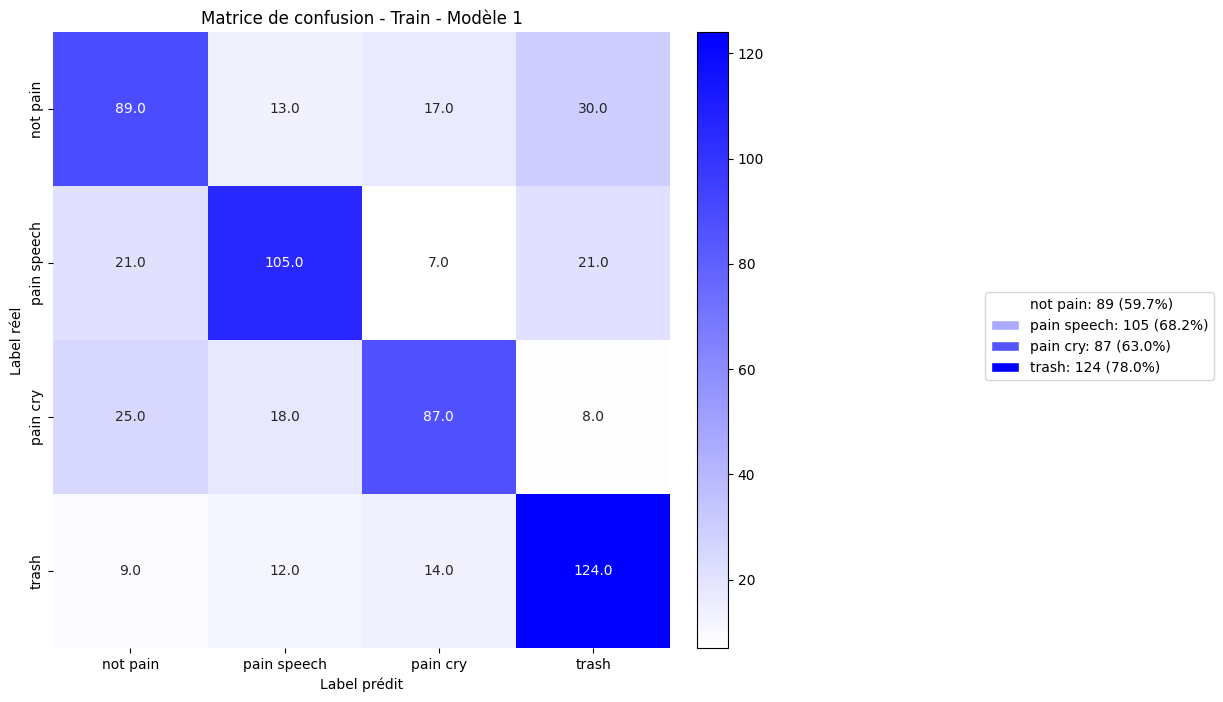

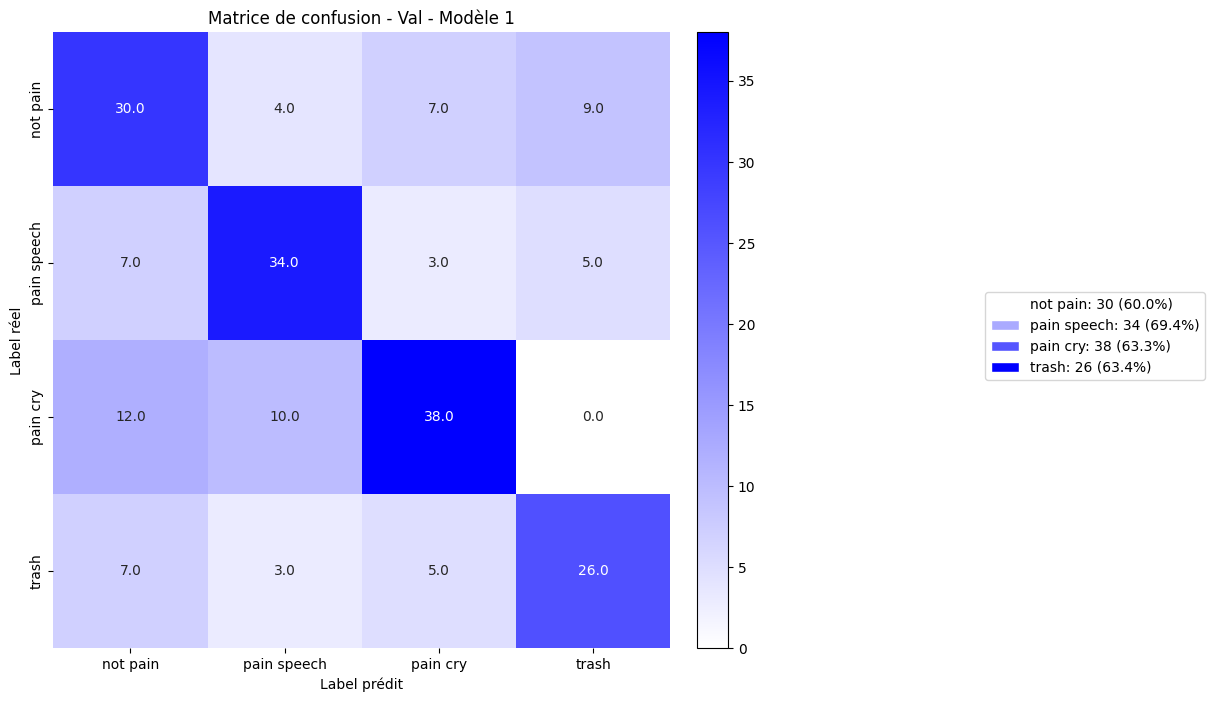

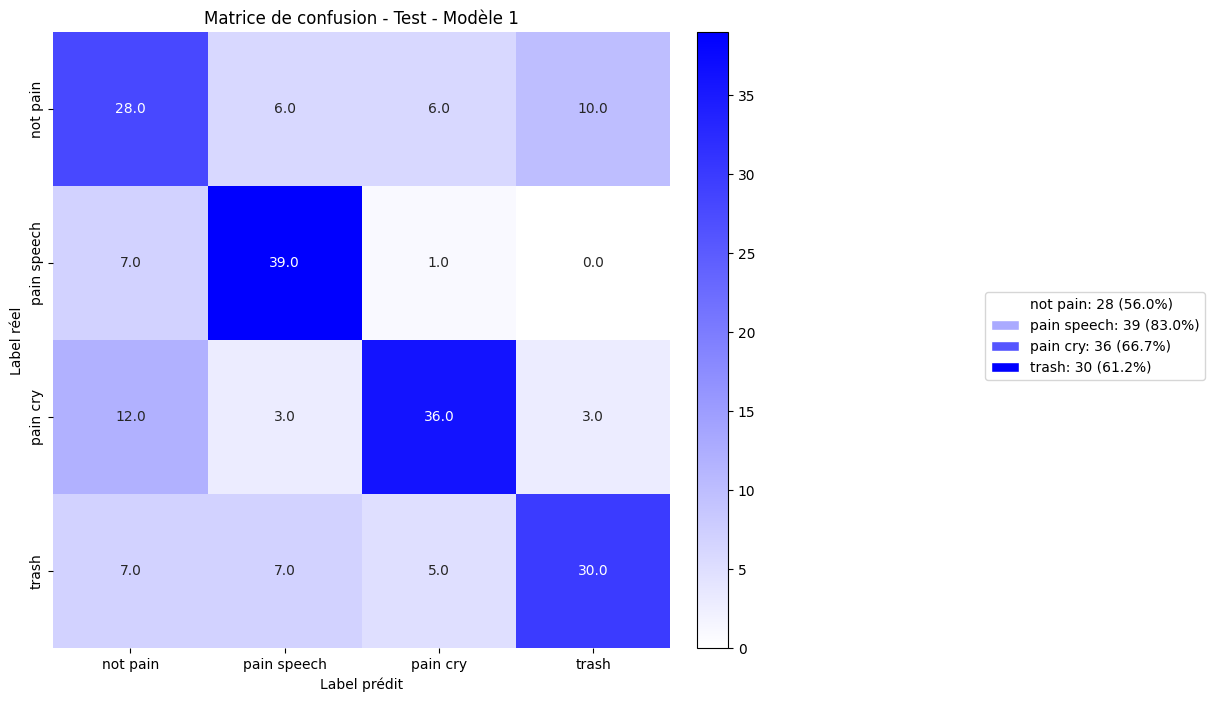

Training model 2...


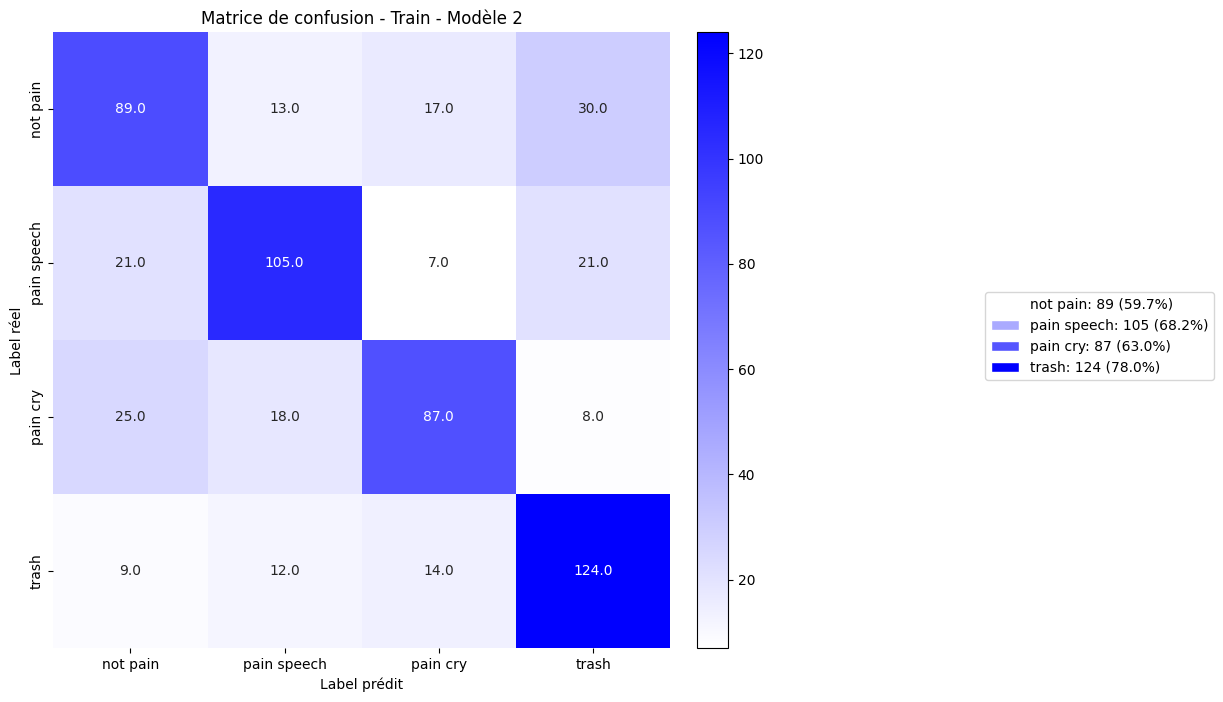

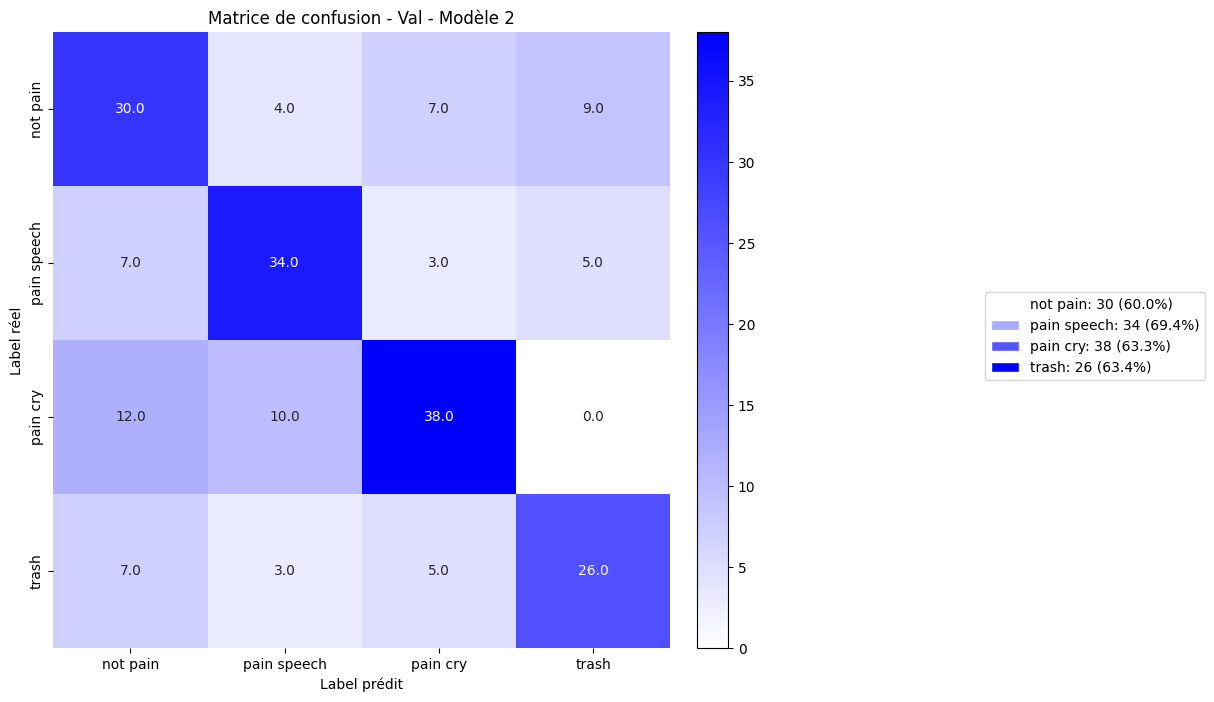

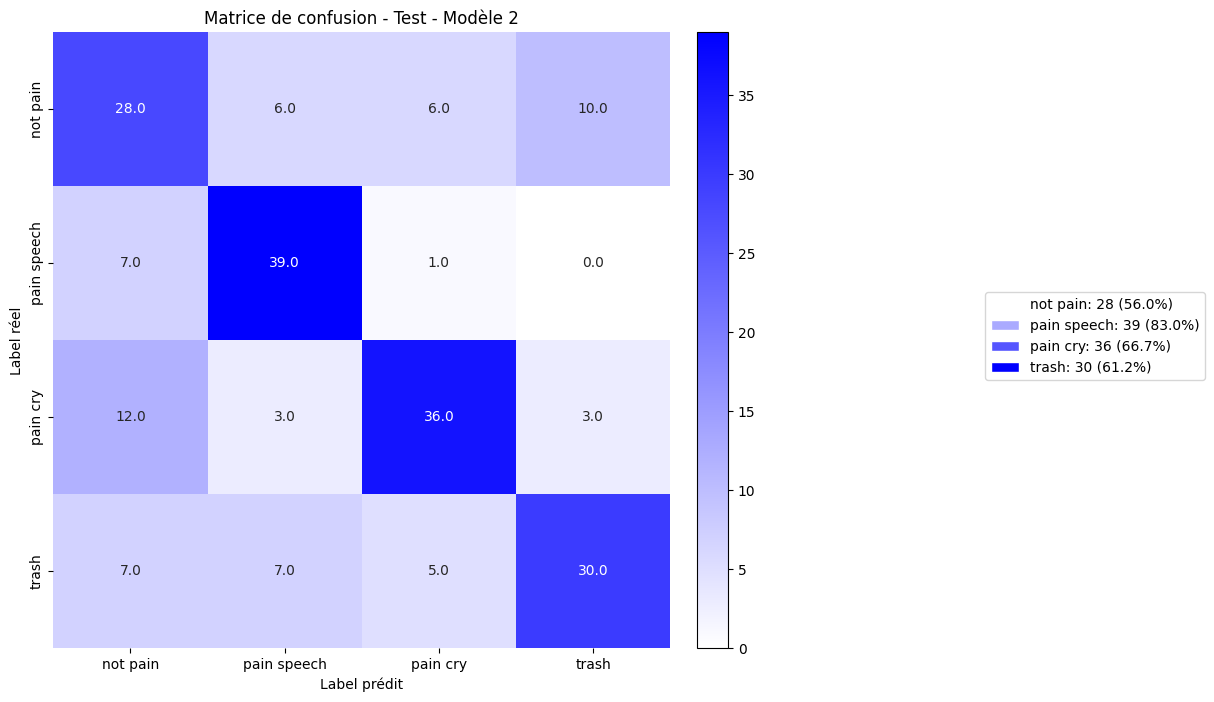

Training model 3...


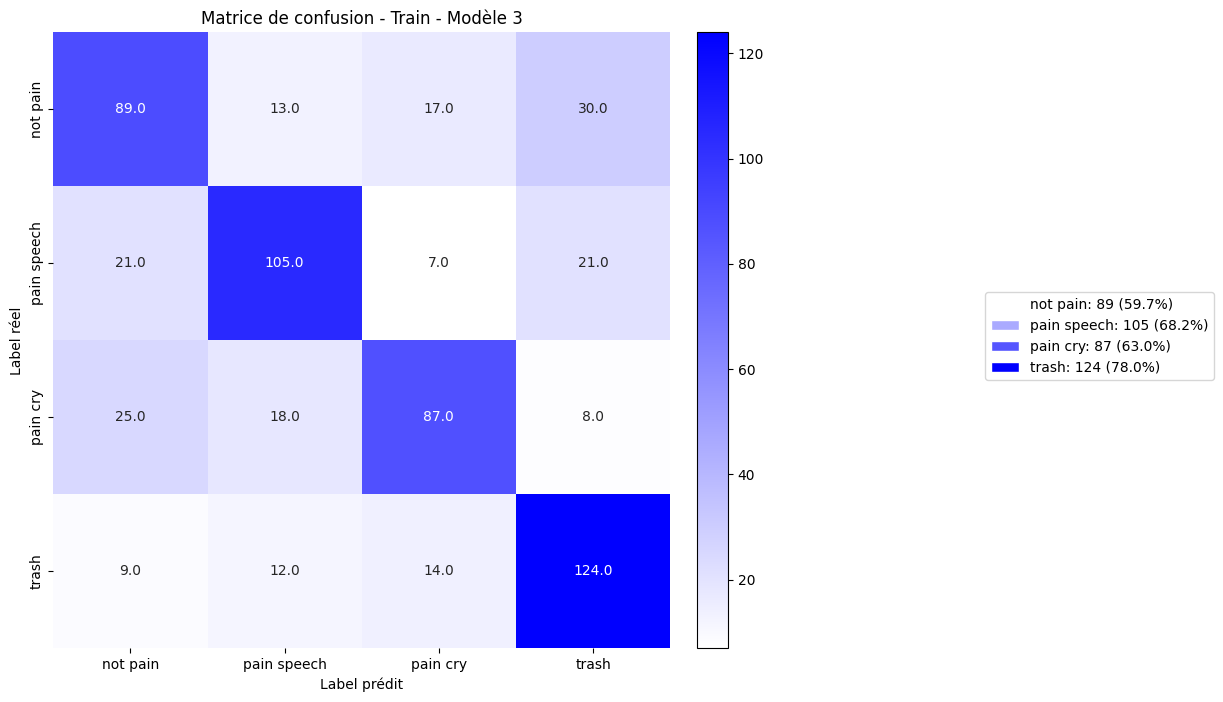

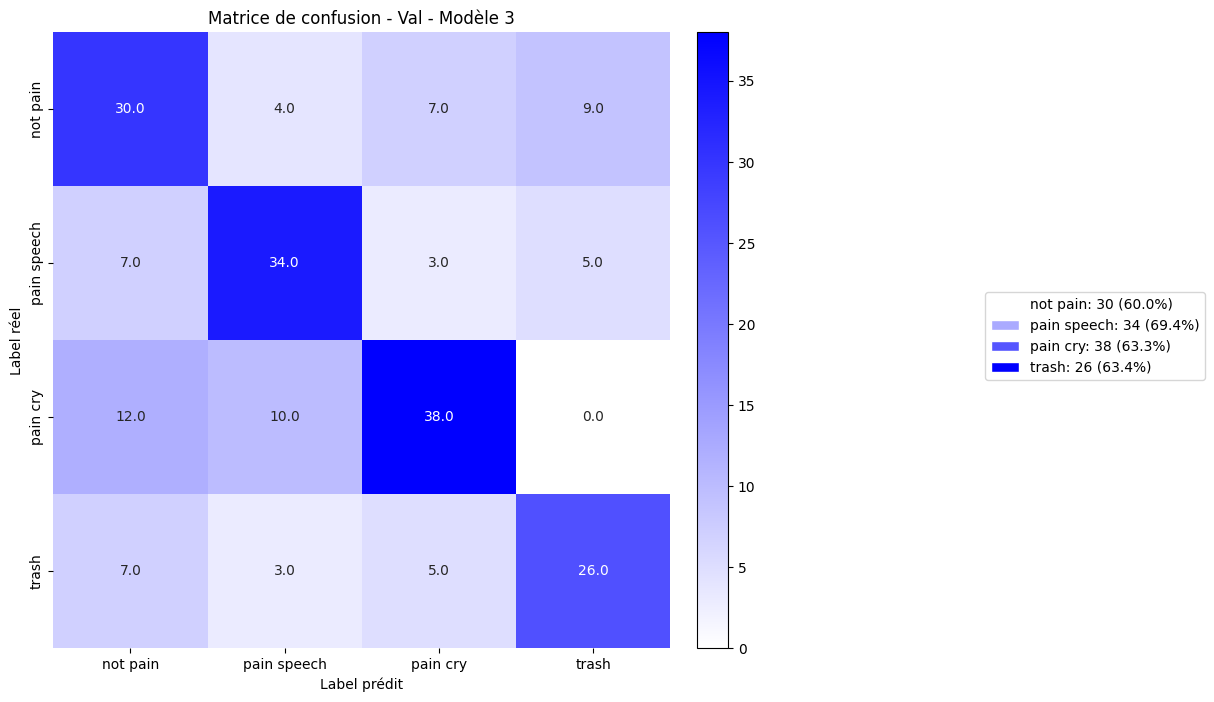

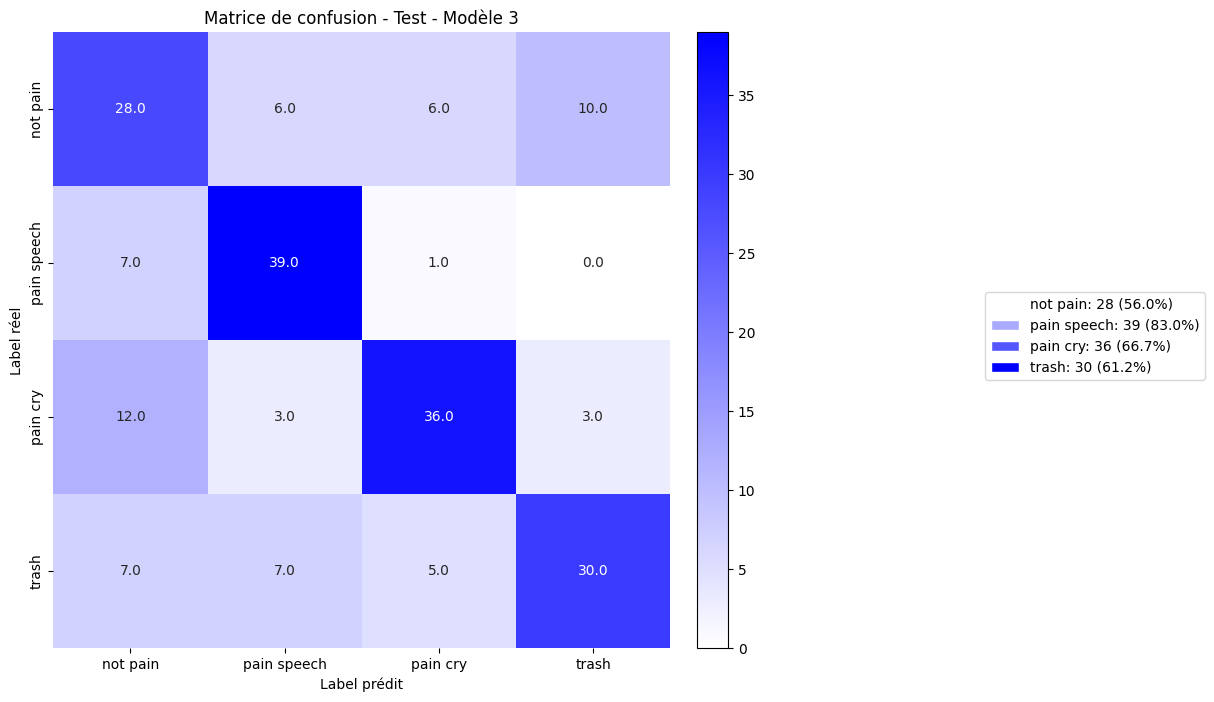

Training model 4...


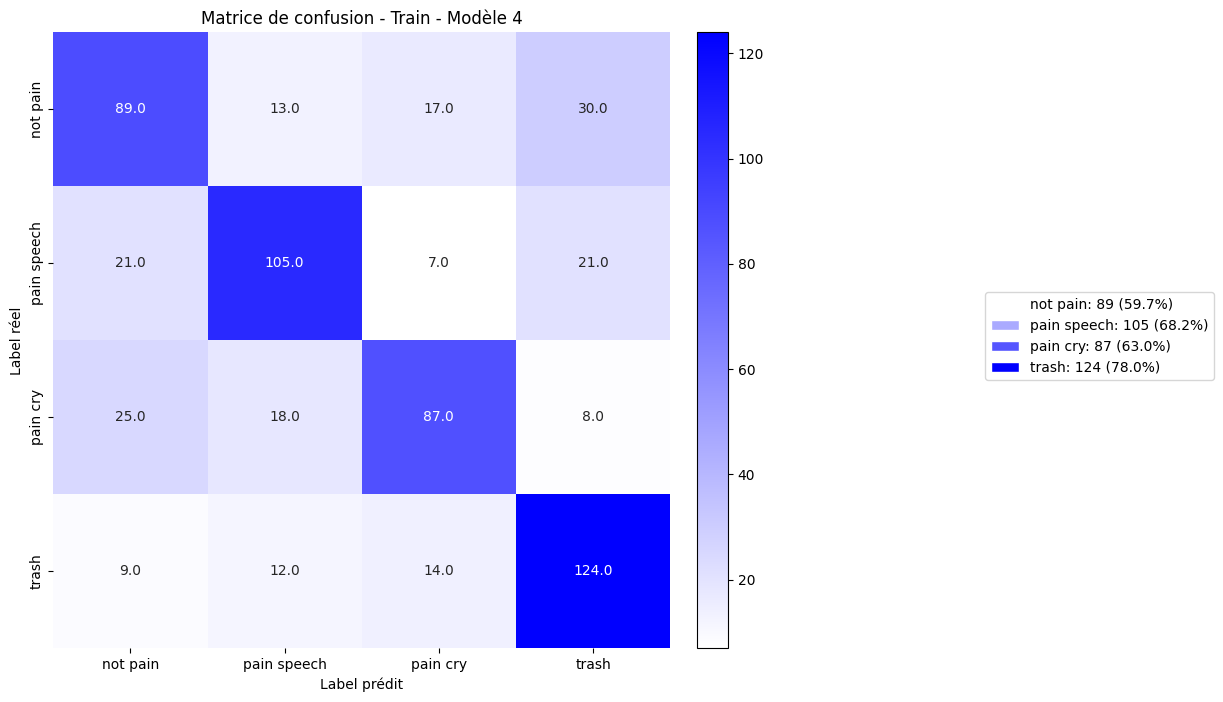

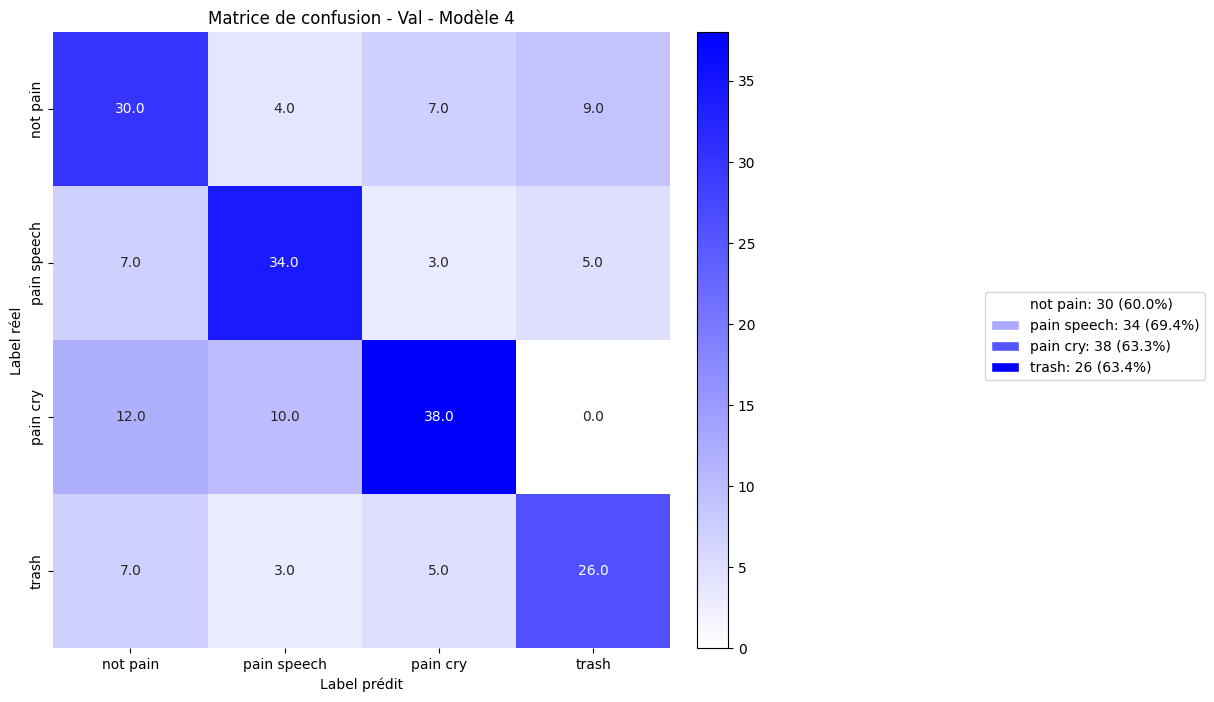

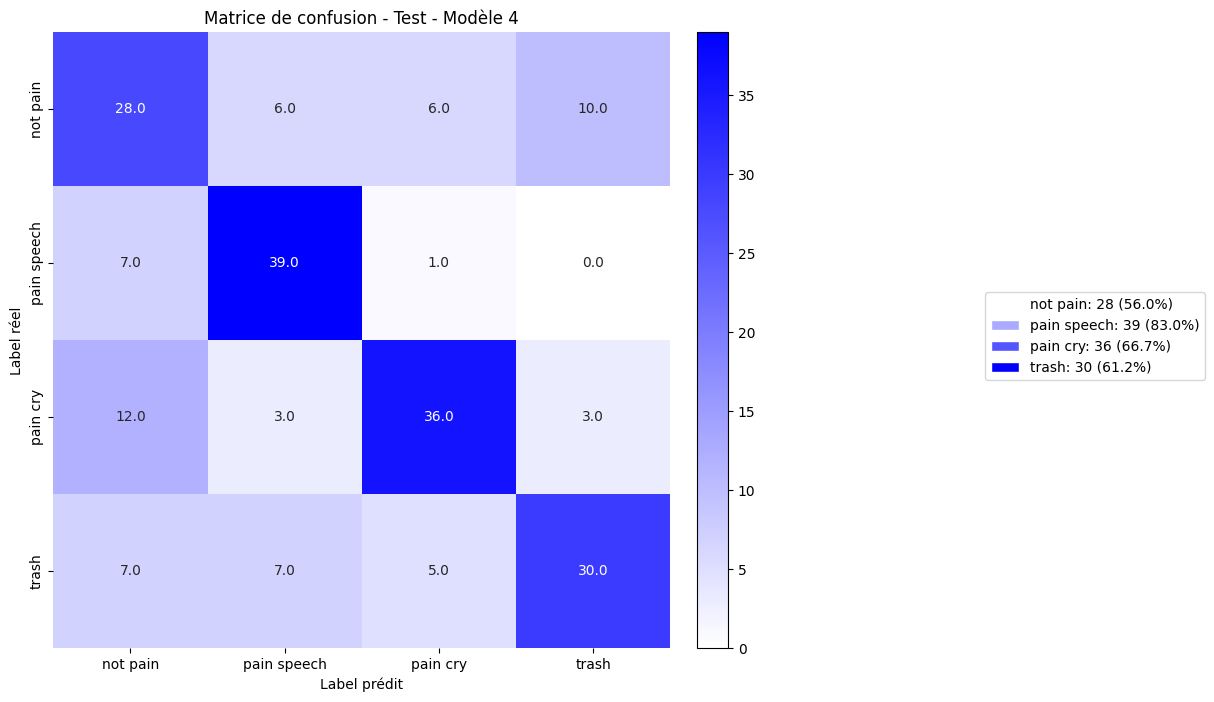

Training model 5...


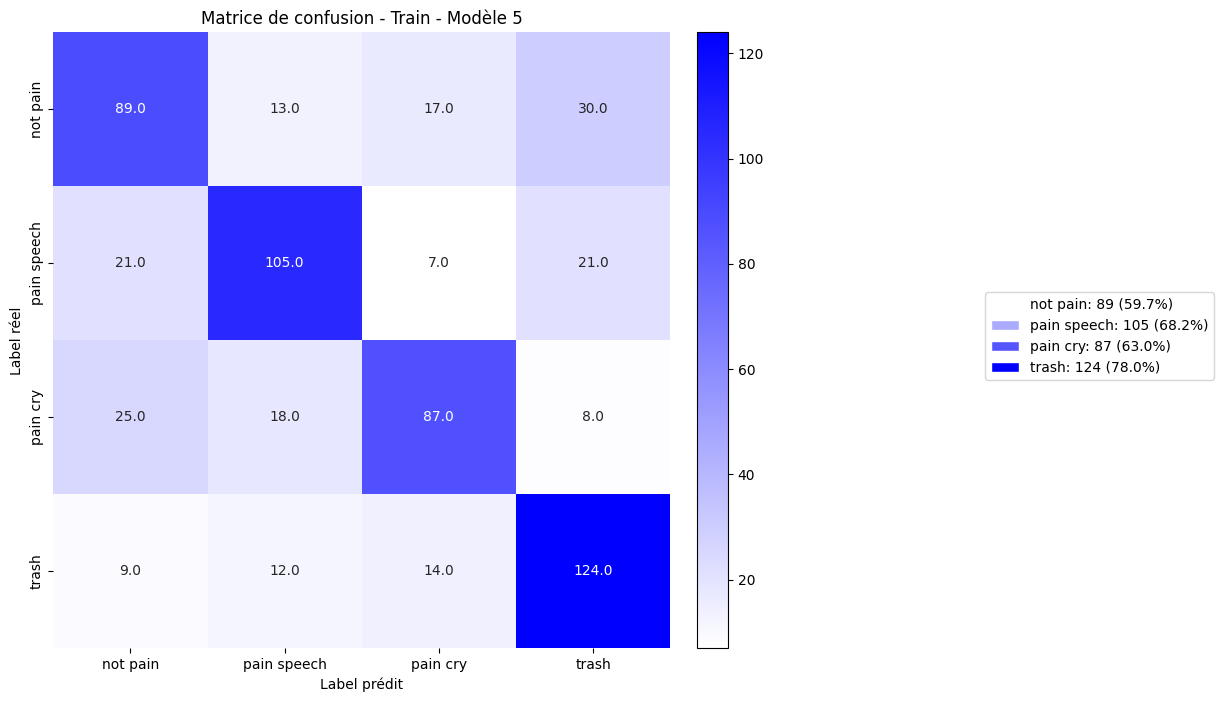

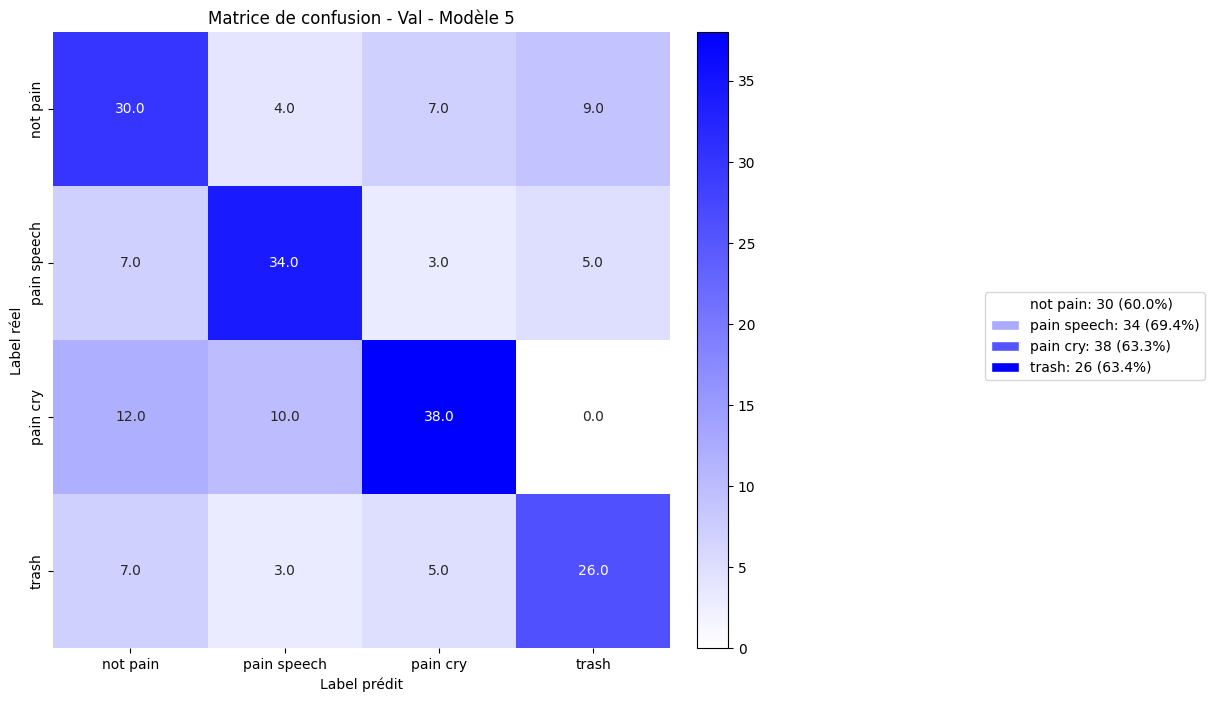

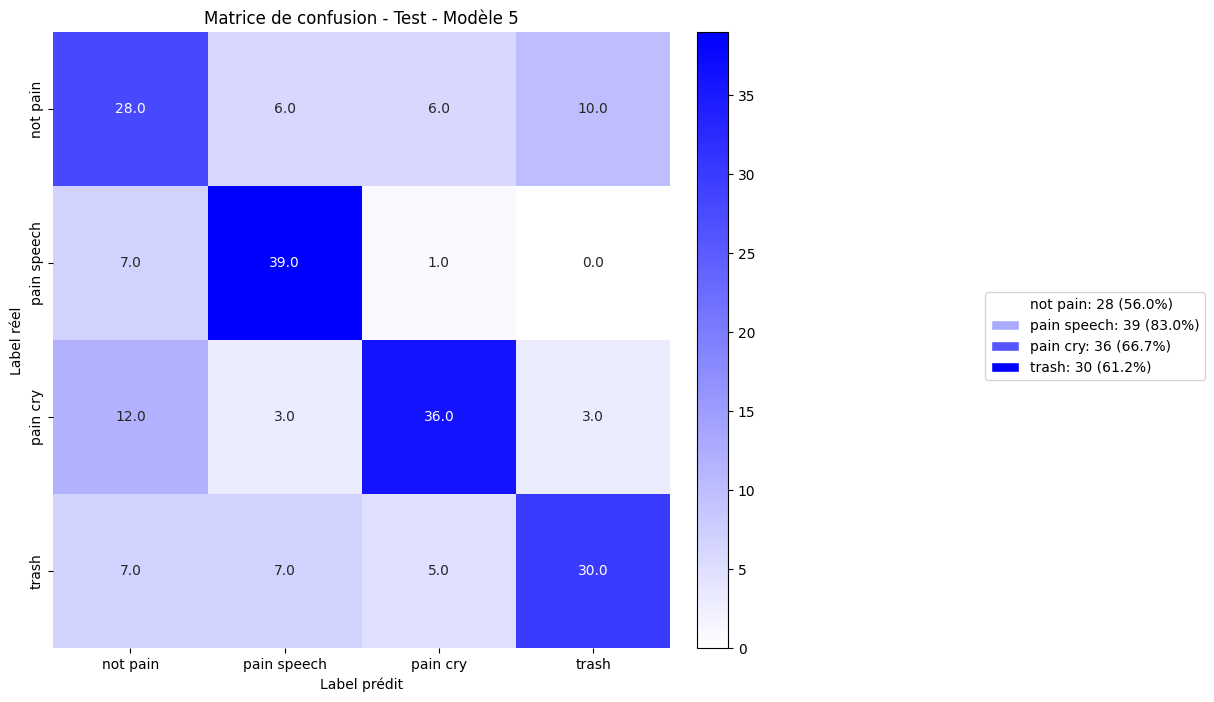

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from scipy.optimize import linear_sum_assignment

# Génération de données fictives pour l'exemple
X, y = make_classification(n_samples=1000, n_classes=4, n_informative=5, random_state=42)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Supposons que class_name contient les noms de classe corrects
class_names = ['not pain', 'pain speech', 'pain cry', 'trash']

# Fonction pour calculer et afficher la matrice de confusion avec pourcentages
def plot_confusion_matrix(model, X, y_true, class_names, title):
    y_pred = model.predict(X)
    conf_mat = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-conf_mat)
    conf_mat_reordered = conf_mat[row_ind[:, np.newaxis], col_ind]
    class_totals = conf_mat.sum(axis=1)
    class_percentages = conf_mat / class_totals[:, np.newaxis] * 100
    colors = [(0, 'white'), (1, 'blue')]
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(conf_mat_reordered, annot=True, fmt='.1f', cmap=cmap,
                xticklabels=np.array(class_names)[col_ind], yticklabels=np.array(class_names)[row_ind],
                ax=ax, cbar=False)

    # Ajouter une barre de couleurs
    cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

    # Ajouter des étiquettes et un titre
    ax.set_xlabel('Label prédit')
    ax.set_ylabel('Label réel')
    ax.set_title(title)

    # Création des éléments de légende avec pourcentages corrects
    class_colors = cmap(np.linspace(0, 1, len(class_names)))
    legend_elements = [Patch(facecolor=class_colors[i], edgecolor='w',
                             label=f'{class_names[col_ind[i]]}: {conf_mat_reordered[i, i]} ({class_percentages[row_ind[i], col_ind[i]]:.1f}%)')
                       for i in range(len(class_names))]

    # Ajuster l'espace pour la légende
    plt.subplots_adjust(right=0.8)
    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.05, 0.5))

    plt.show()

def train_and_plot_confusion_matrices(model_num, X_train, y_train, X_val, y_val, X_test, y_test, class_names):
    print(f'Training model {model_num}...')
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)

    plot_confusion_matrix(model, X_train, y_train, class_names, f'Matrice de confusion - Train - Modèle {model_num}')
    plot_confusion_matrix(model, X_val, y_val, class_names, f'Matrice de confusion - Val - Modèle {model_num}')
    plot_confusion_matrix(model, X_test, y_test, class_names, f'Matrice de confusion - Test - Modèle {model_num}')

# Entraîner et afficher les matrices de confusion pour les cinq modèles
for i in range(1, 6):
    train_and_plot_confusion_matrices(i, X_train, y_train, X_val, y_val, X_test, y_test, class_names)

In [ ]:
from sklearn.model_selection import train_test_split

# Diviser en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionnel : Diviser l'ensemble d'entraînement en ensemble d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 75% train, 25% validation


--- Modèle 1 ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs paramètres trouvés par GridSearchCV:
{'n_neighbors': 1}
Meilleur score d'entraînement: 0.32999999999999996
Train accuracy: 1.0
Test accuracy: 0.16666666666666666
Validation accuracy: 0.16666666666666666
Classification Report on Test Data:
              precision    recall  f1-score   support

    not pain       0.08      0.17      0.11         6
    pain cry       0.50      0.20      0.29        10
 pain speech       0.33      0.25      0.29         8
       trash       0.00      0.00      0.00         6

    accuracy                           0.17        30
   macro avg       0.23      0.15      0.17        30
weighted avg       0.27      0.17      0.19        30



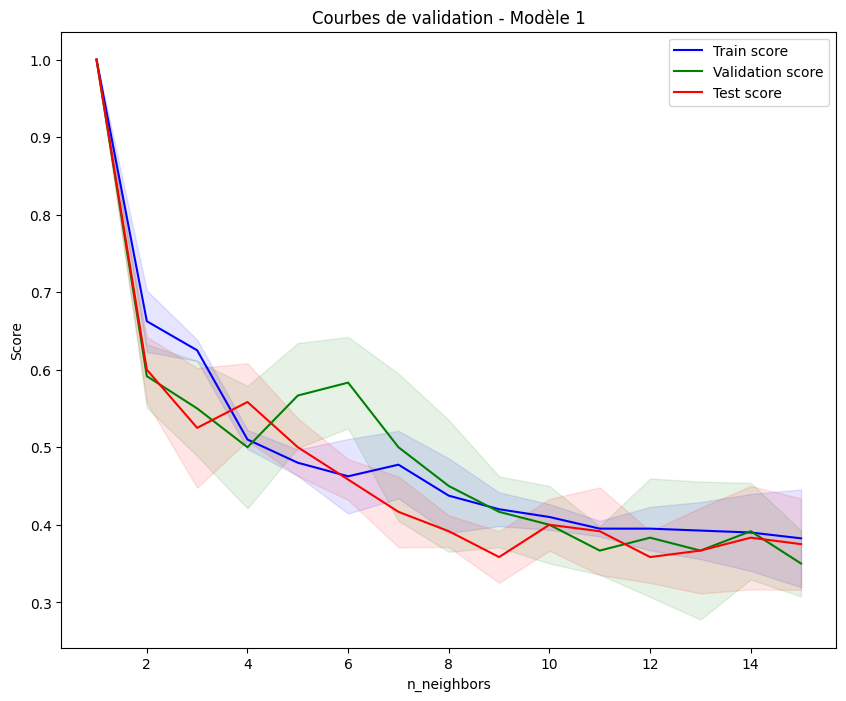


--- Modèle 2 ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs paramètres trouvés par GridSearchCV:
{'n_neighbors': 1}
Meilleur score d'entraînement: 0.32999999999999996
Train accuracy: 1.0
Test accuracy: 0.16666666666666666
Validation accuracy: 0.16666666666666666
Classification Report on Test Data:
              precision    recall  f1-score   support

    not pain       0.08      0.17      0.11         6
    pain cry       0.50      0.20      0.29        10
 pain speech       0.33      0.25      0.29         8
       trash       0.00      0.00      0.00         6

    accuracy                           0.17        30
   macro avg       0.23      0.15      0.17        30
weighted avg       0.27      0.17      0.19        30



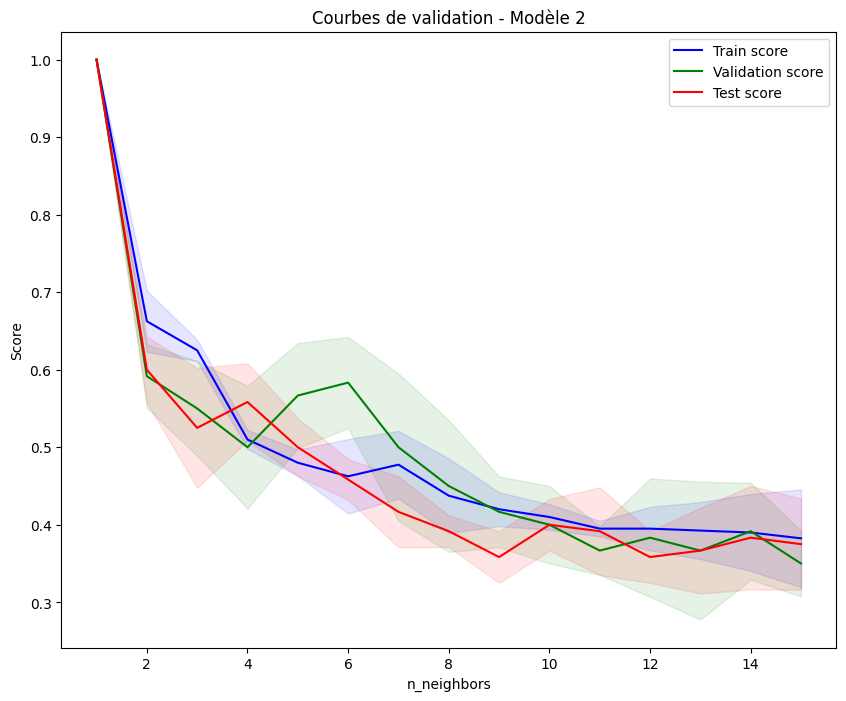


--- Modèle 3 ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs paramètres trouvés par GridSearchCV:
{'n_neighbors': 1}
Meilleur score d'entraînement: 0.32999999999999996
Train accuracy: 1.0
Test accuracy: 0.16666666666666666
Validation accuracy: 0.16666666666666666
Classification Report on Test Data:
              precision    recall  f1-score   support

    not pain       0.08      0.17      0.11         6
    pain cry       0.50      0.20      0.29        10
 pain speech       0.33      0.25      0.29         8
       trash       0.00      0.00      0.00         6

    accuracy                           0.17        30
   macro avg       0.23      0.15      0.17        30
weighted avg       0.27      0.17      0.19        30



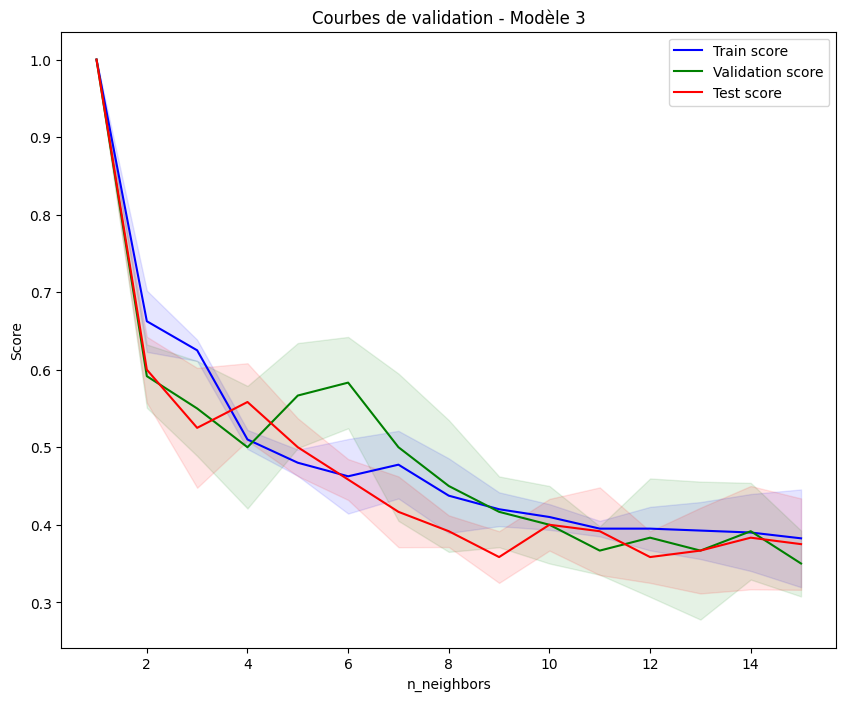


--- Modèle 4 ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs paramètres trouvés par GridSearchCV:
{'n_neighbors': 1}
Meilleur score d'entraînement: 0.32999999999999996
Train accuracy: 1.0
Test accuracy: 0.16666666666666666
Validation accuracy: 0.16666666666666666
Classification Report on Test Data:
              precision    recall  f1-score   support

    not pain       0.08      0.17      0.11         6
    pain cry       0.50      0.20      0.29        10
 pain speech       0.33      0.25      0.29         8
       trash       0.00      0.00      0.00         6

    accuracy                           0.17        30
   macro avg       0.23      0.15      0.17        30
weighted avg       0.27      0.17      0.19        30



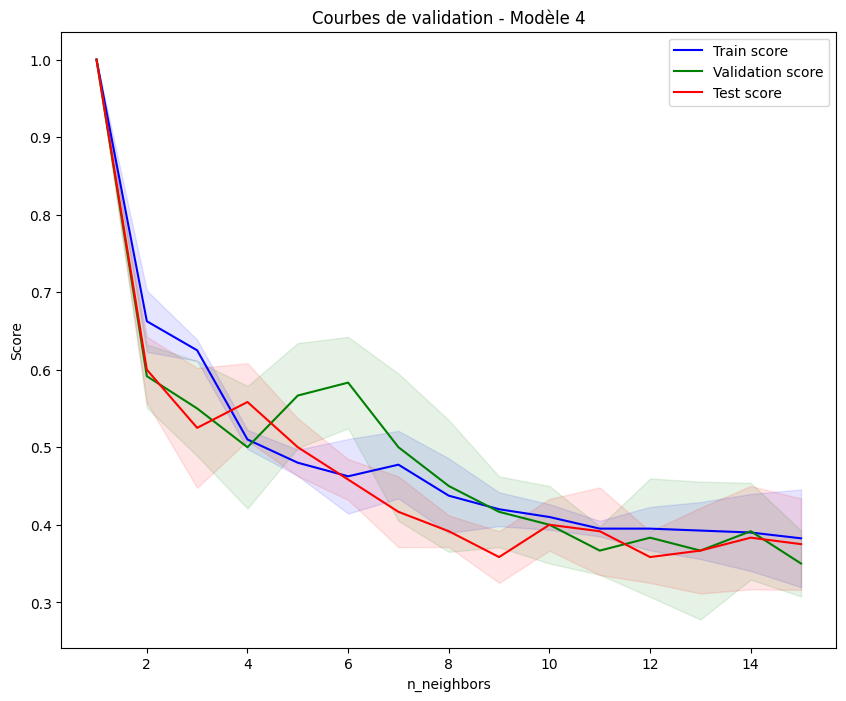


--- Modèle 5 ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs paramètres trouvés par GridSearchCV:
{'n_neighbors': 1}
Meilleur score d'entraînement: 0.32999999999999996
Train accuracy: 1.0
Test accuracy: 0.16666666666666666
Validation accuracy: 0.16666666666666666
Classification Report on Test Data:
              precision    recall  f1-score   support

    not pain       0.08      0.17      0.11         6
    pain cry       0.50      0.20      0.29        10
 pain speech       0.33      0.25      0.29         8
       trash       0.00      0.00      0.00         6

    accuracy                           0.17        30
   macro avg       0.23      0.15      0.17        30
weighted avg       0.27      0.17      0.19        30



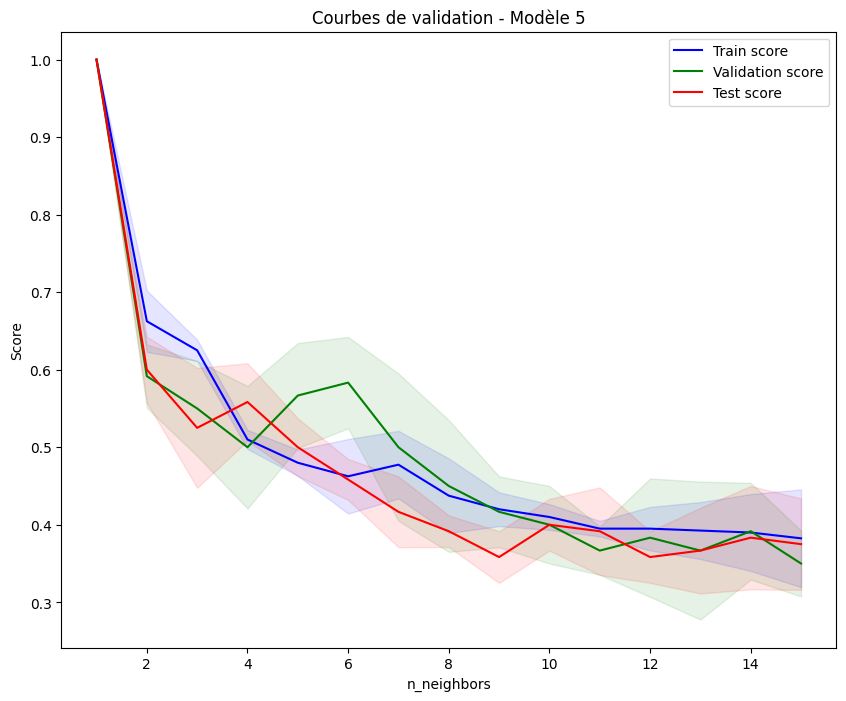

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

def train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, model_num):
    print(f"\n--- Modèle {model_num} ---")

    # Encoder les labels en numériques car KNeighborsClassifier requiert des labels numériques
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)
    y_val = label_encoder.transform(y_val)

    # Normaliser les données
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)

    # Définir la grille de paramètres pour la recherche en grille
    param_grid = {
        'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]
    }

    # Créer le modèle KNeighborsClassifier
    model_knn = KNeighborsClassifier()

    # GridSearchCV avec validation croisée
    grid_search = GridSearchCV(estimator=model_knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

    # Fit le modèle avec les données d'entraînement
    grid_search.fit(X_train_scaled, y_train)

    # Afficher les meilleurs paramètres et le meilleur score
    print("Meilleurs paramètres trouvés par GridSearchCV:")
    print(grid_search.best_params_)
    print("Meilleur score d'entraînement:", grid_search.best_score_)

    # Obtenir le meilleur modèle après la recherche en grille
    best_model = grid_search.best_estimator_

    # Prédire sur les ensembles de test et de validation
    train_accuracy = accuracy_score(y_train, best_model.predict(X_train_scaled))
    test_accuracy = accuracy_score(y_test, best_model.predict(X_test_scaled))
    val_accuracy = accuracy_score(y_val, best_model.predict(X_val_scaled))

    print('Train accuracy:', train_accuracy)
    print('Test accuracy:', test_accuracy)
    print('Validation accuracy:', val_accuracy)

    # Afficher le rapport de classification sur les données de test
    print('Classification Report on Test Data:')
    print(classification_report(y_test, best_model.predict(X_test_scaled), target_names=label_encoder.classes_))

    # Calculer les courbes de validation pour différents paramètres n_neighbors
    k_range = np.arange(1, 16)
    train_scores, _ = validation_curve(best_model, X_train_scaled, y_train, param_name='n_neighbors', param_range=k_range, cv=5, scoring='accuracy')
    val_scores, _ = validation_curve(best_model, X_val_scaled, y_val, param_name='n_neighbors', param_range=k_range, cv=5, scoring='accuracy')
    test_scores, _ = validation_curve(best_model, X_test_scaled, y_test, param_name='n_neighbors', param_range=k_range, cv=5, scoring='accuracy')

    # Calculer les scores moyens et les écarts-types pour les courbes de validation
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Tracer les courbes de validation avec les scores d'entraînement, de validation et de test
    plt.figure(figsize=(10, 8))
    plt.plot(k_range, train_scores_mean, label='Train score', color='blue')
    plt.fill_between(k_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
    plt.plot(k_range, val_scores_mean, label='Validation score', color='green')
    plt.fill_between(k_range, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='green')
    plt.plot(k_range, test_scores_mean, label='Test score', color='red')
    plt.fill_between(k_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='red')

    # Ajouter un titre et des légendes
    plt.title(f'Courbes de validation - Modèle {model_num}')
    plt.xlabel('n_neighbors')
    plt.ylabel('Score')
    plt.legend()

    # Afficher le graphique
    plt.show()

# Exemple de création aléatoire de DataFrames pour la démonstration
train_df = pd.DataFrame(np.random.rand(100, 5), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])
train_df['label'] = np.random.choice(['pain cry', 'pain speech', 'trash', 'not pain'], 100)

test_df = pd.DataFrame(np.random.rand(30, 5), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])
test_df['label'] = np.random.choice(['pain cry', 'pain speech', 'trash', 'not pain'], 30)

val_df = pd.DataFrame(np.random.rand(30, 5), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])
val_df['label'] = np.random.choice(['pain cry', 'pain speech', 'trash', 'not pain'], 30)

# Séparer les caractéristiques et les étiquettes
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']
X_test = test_df.drop(columns=['label'])
y_test = test_df['label']
X_val = val_df.drop(columns=['label'])
y_val = val_df['label']

# Appeler la fonction pour chaque modèle
for model_num in range(1, 6):
    train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, model_num)

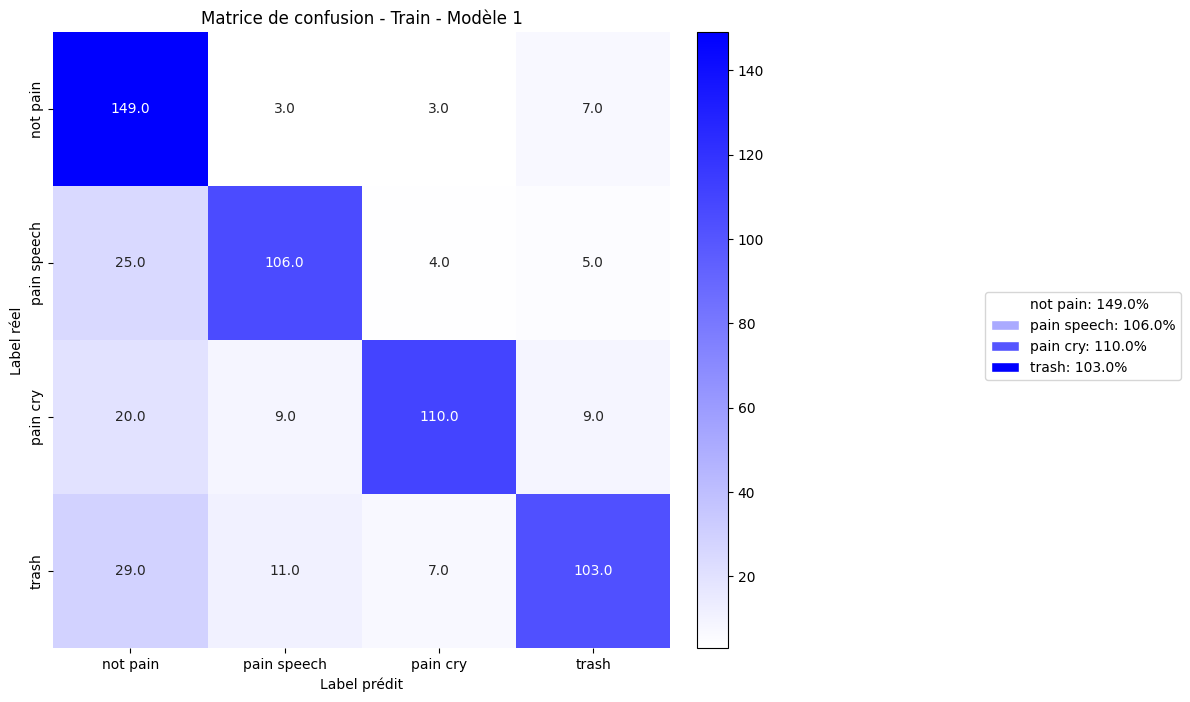

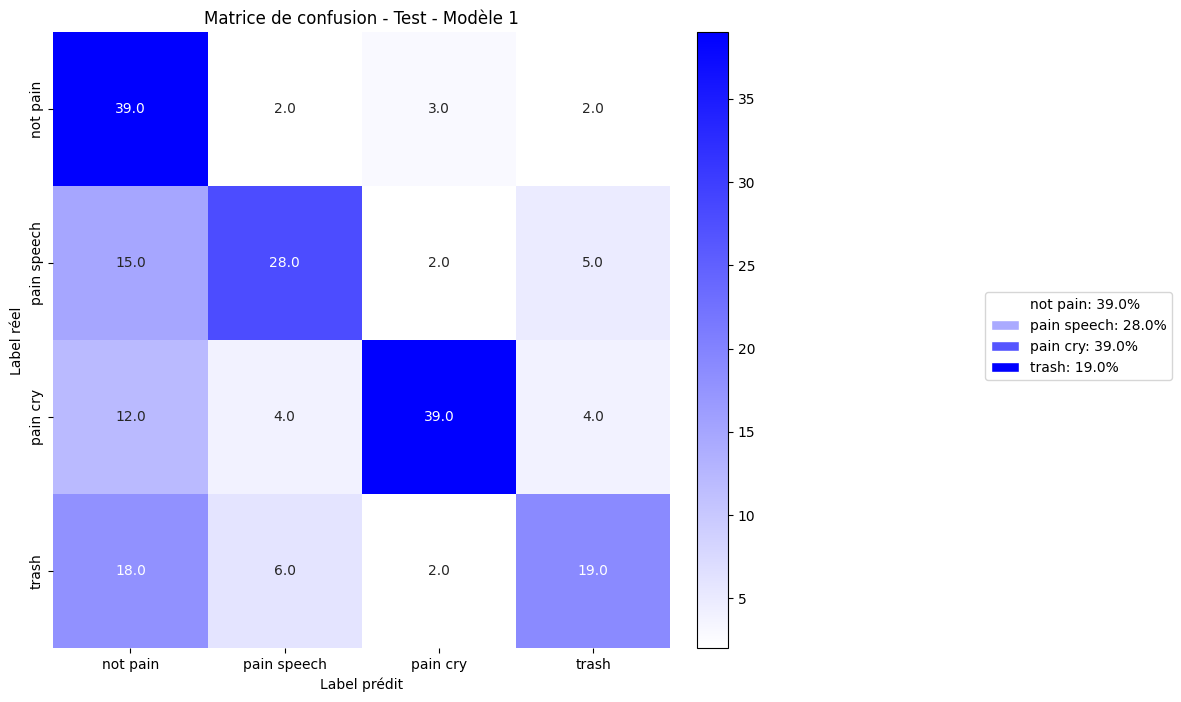

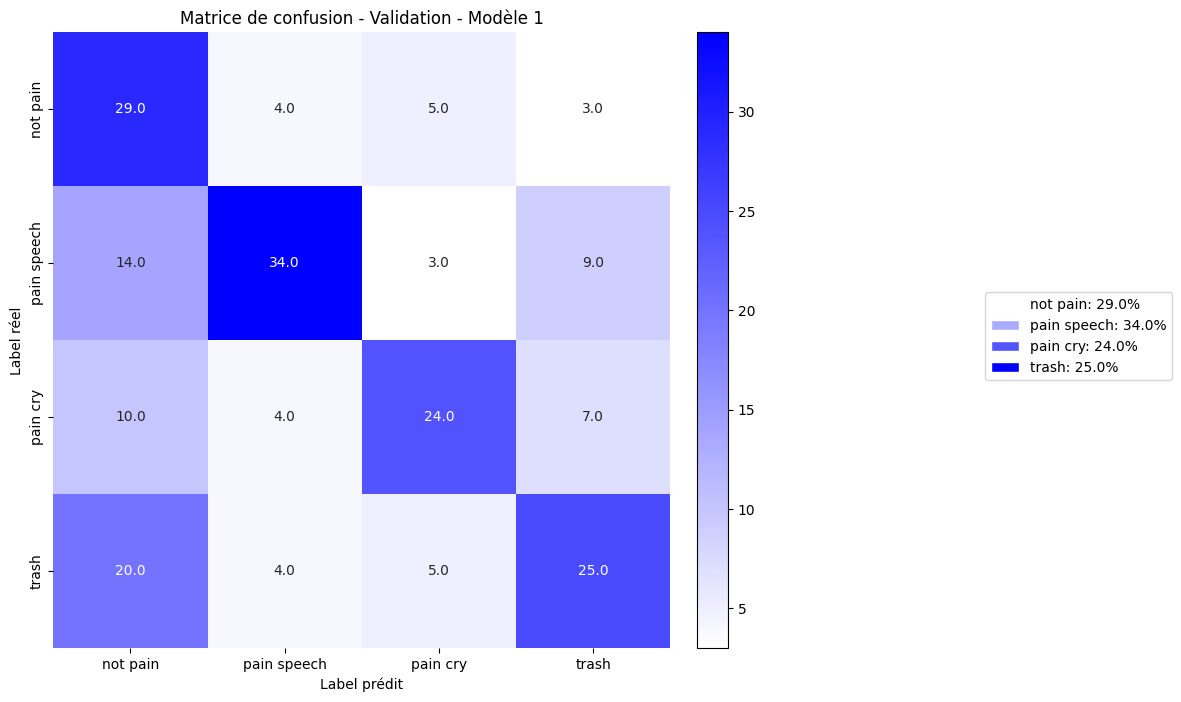

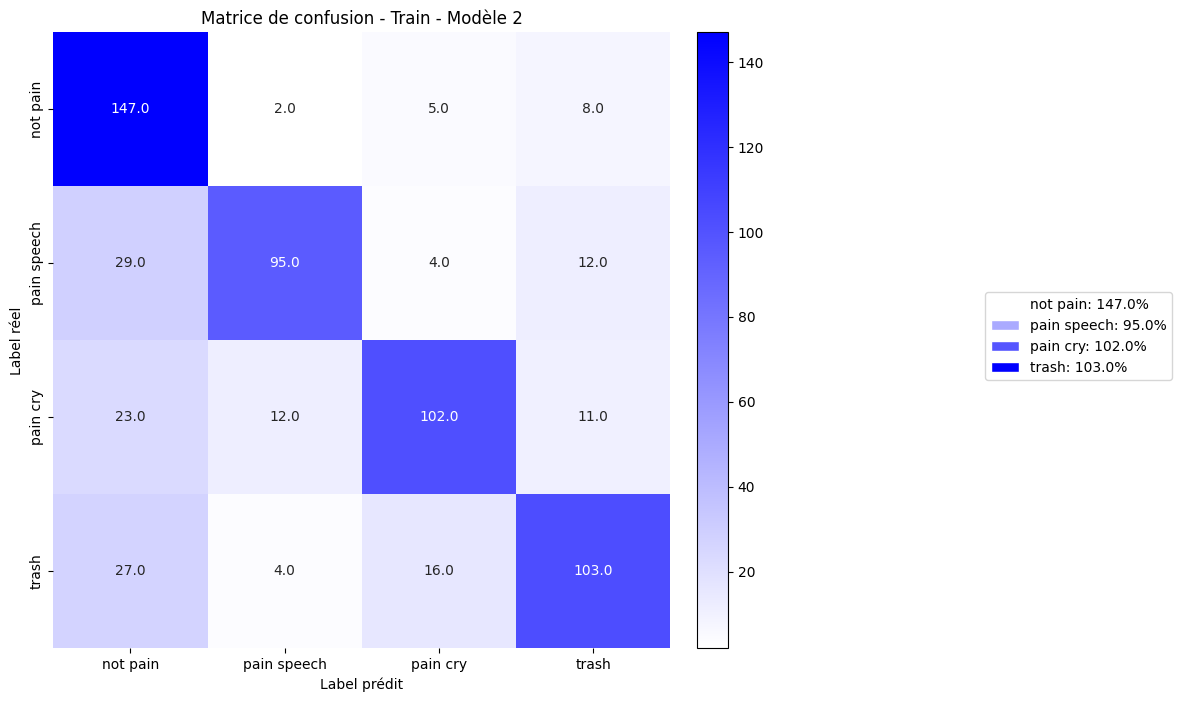

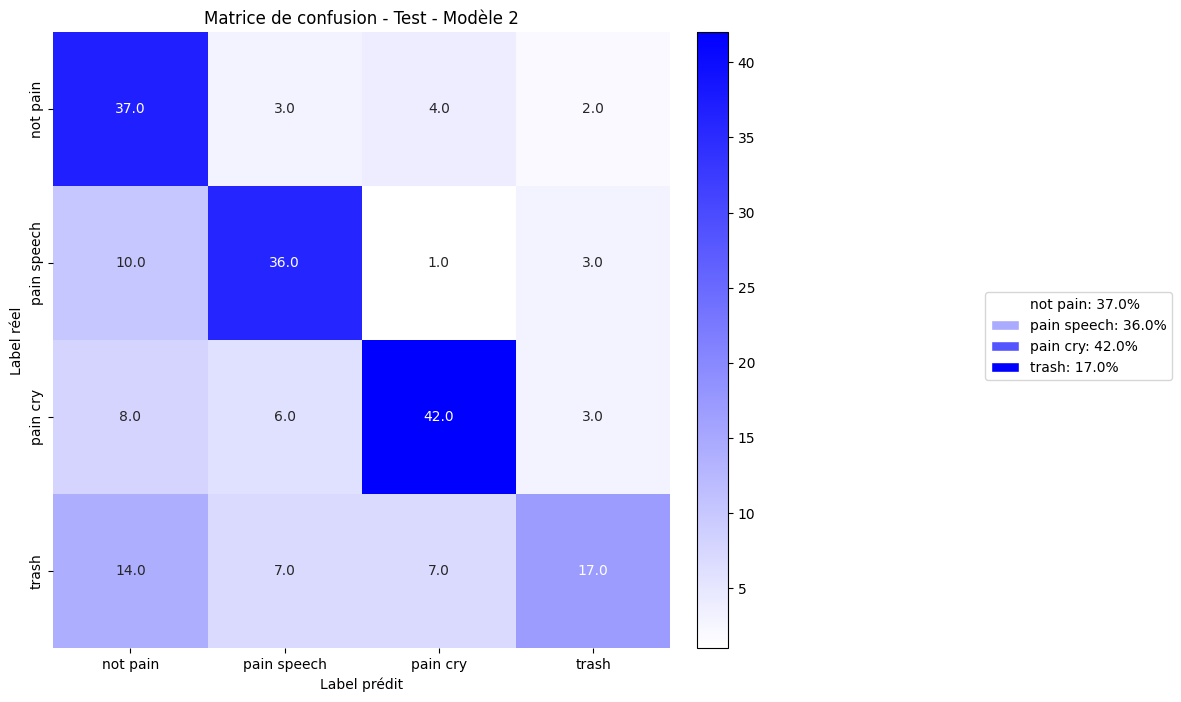

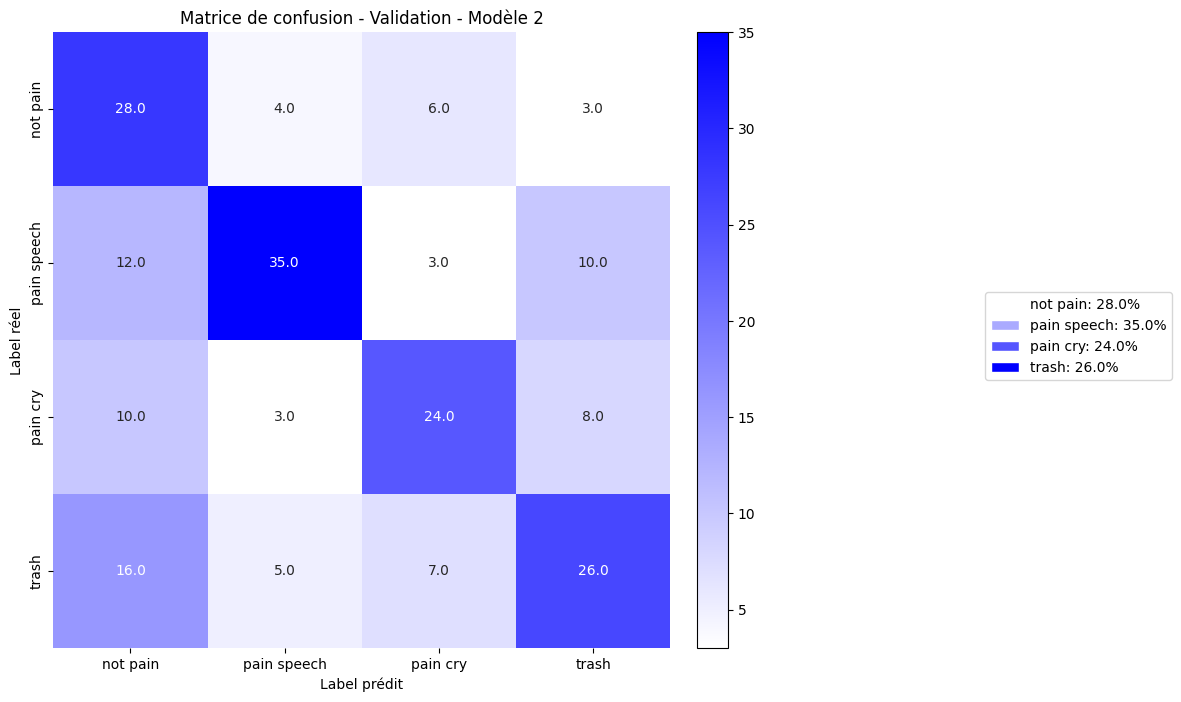

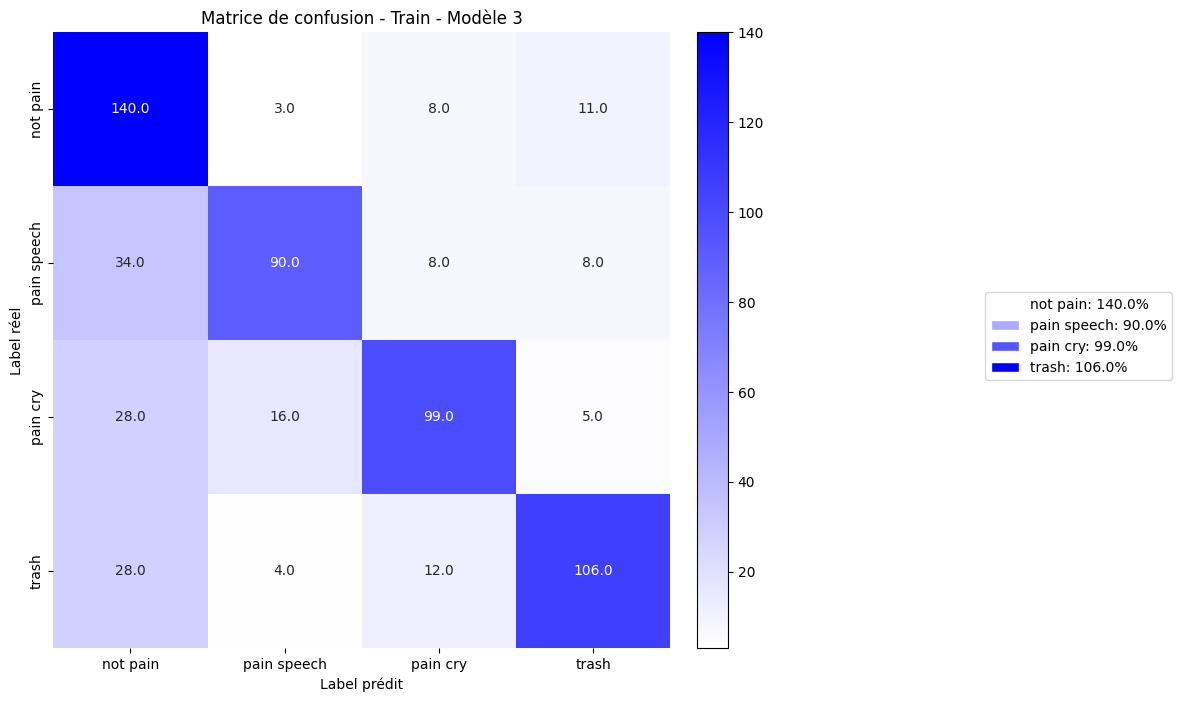

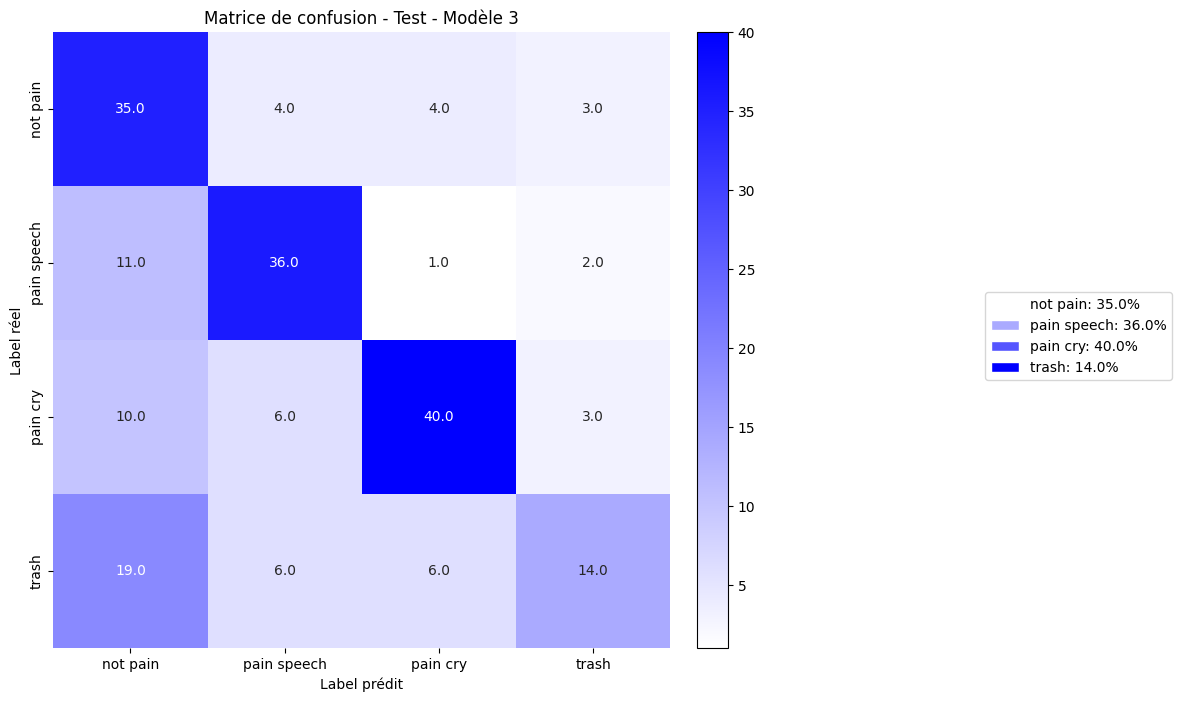

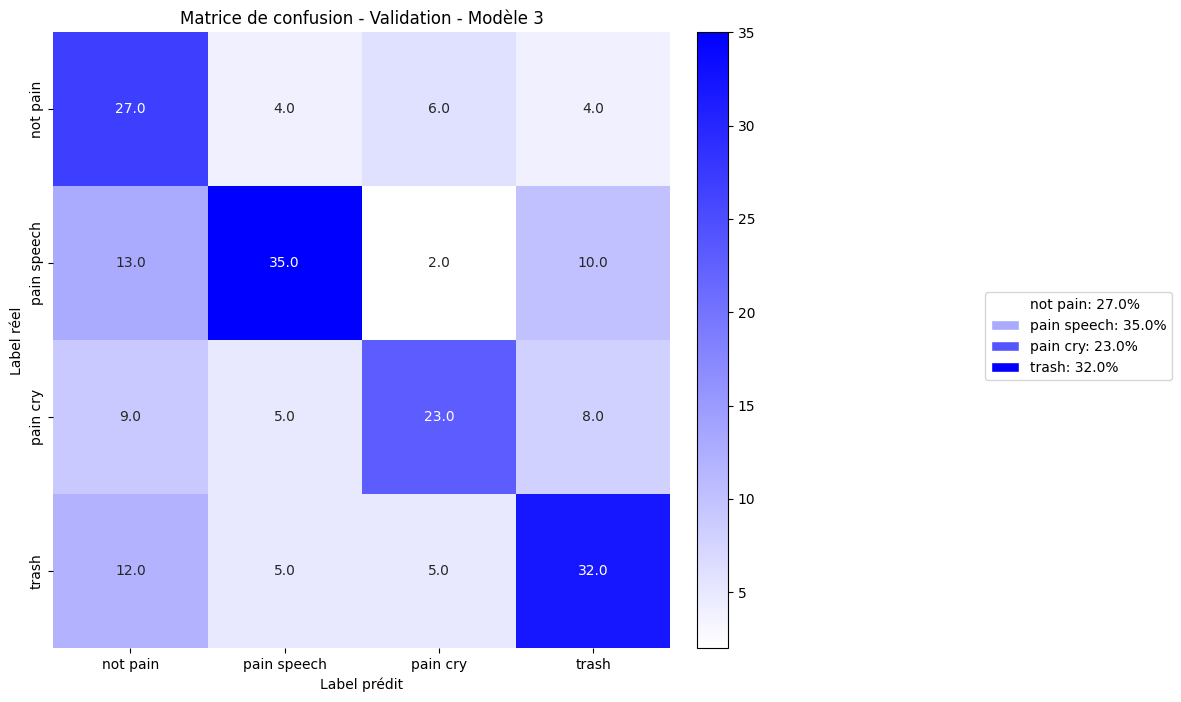

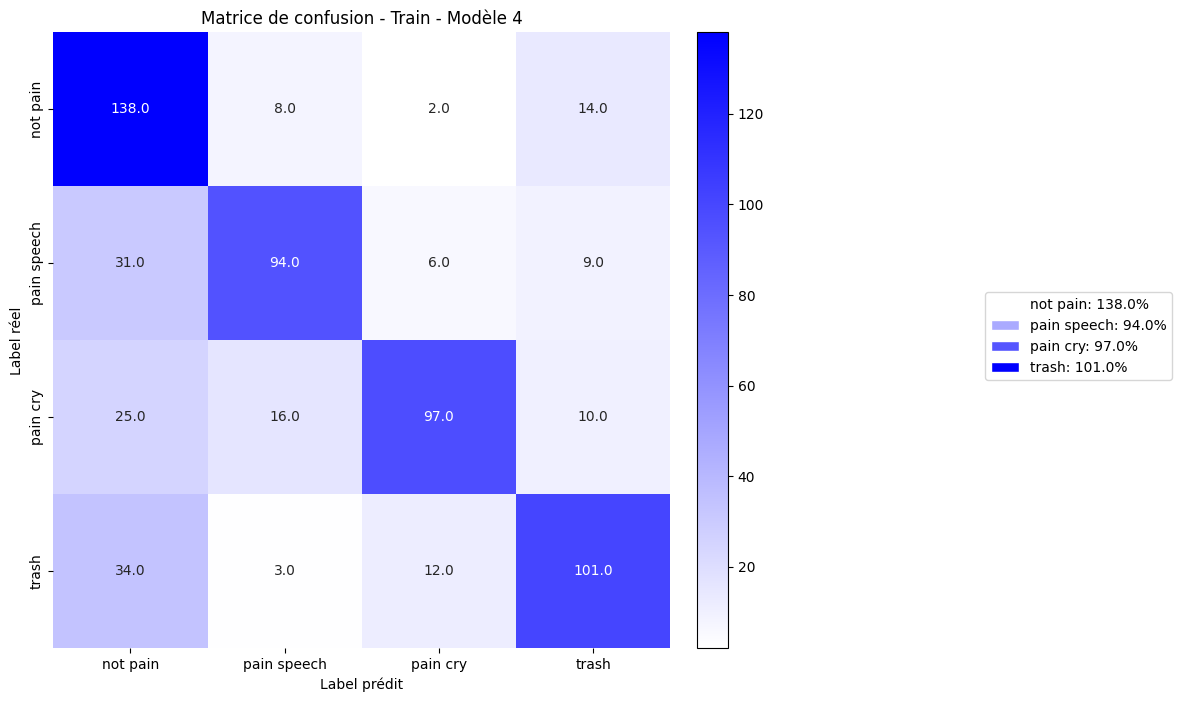

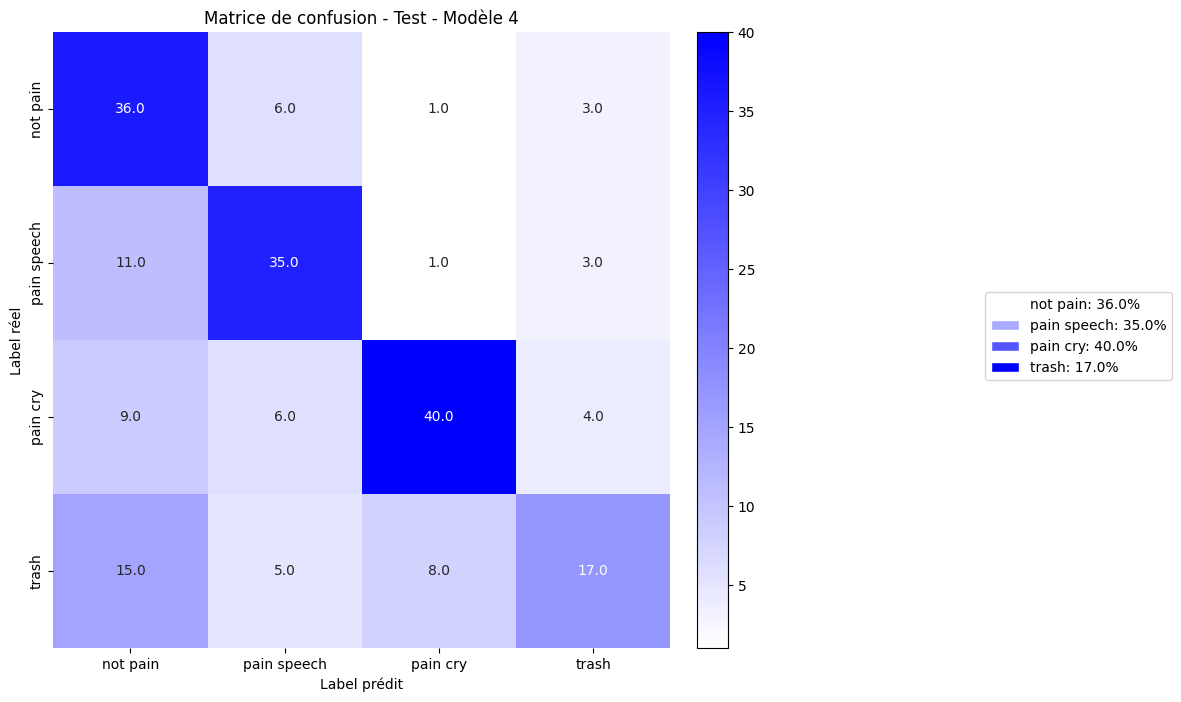

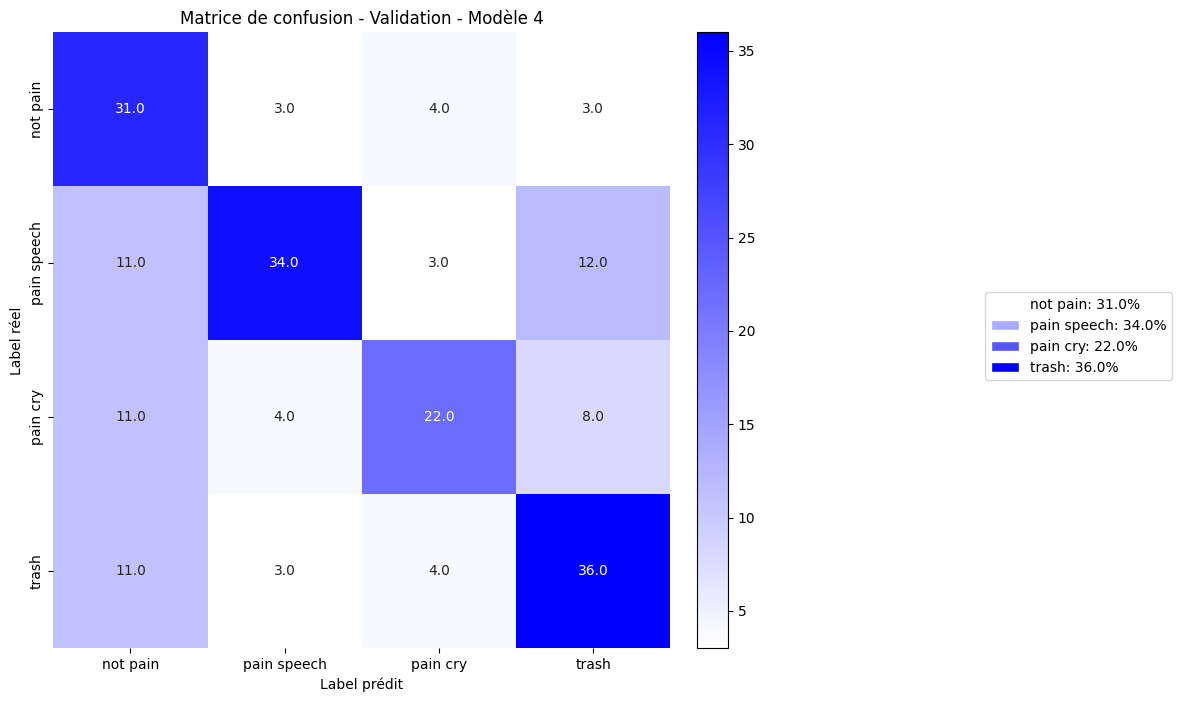

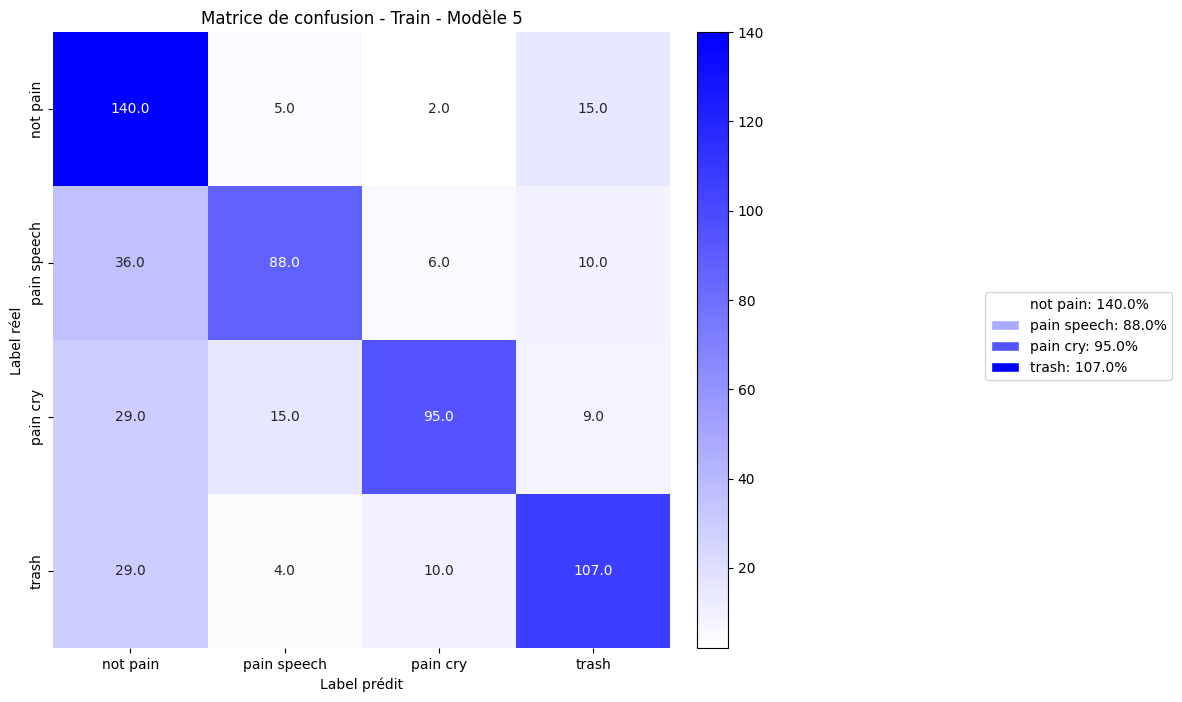

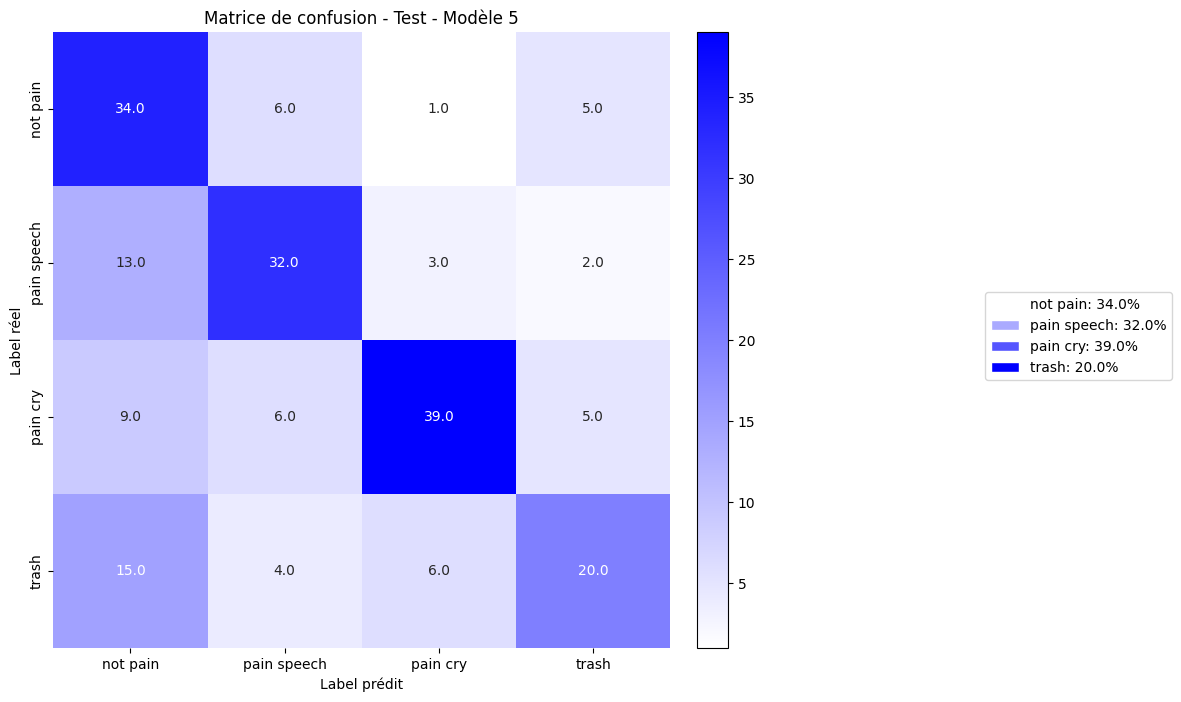

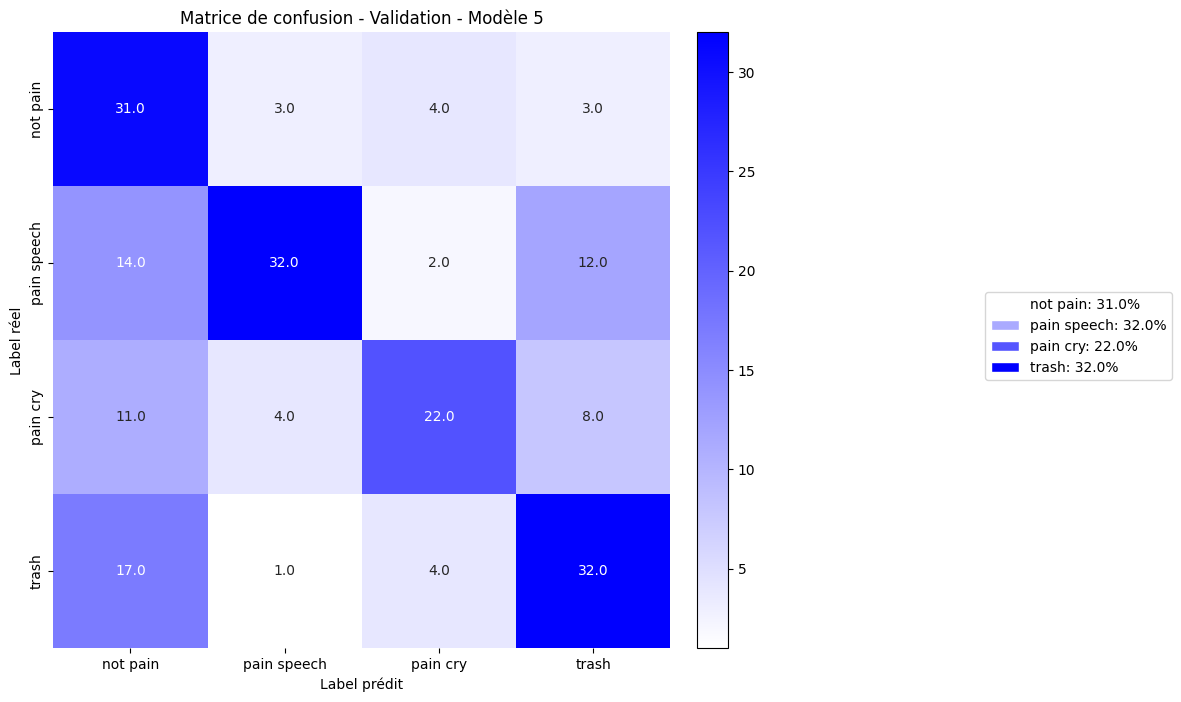

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.patches import Patch
from scipy.optimize import linear_sum_assignment
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Génération de données fictives pour l'exemple
X, y = make_classification(n_samples=1000, n_classes=4, n_informative=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # Split train/validation

# Supposons que class_name contient les noms de classe corrects
class_name = ['not pain', 'pain speech', 'pain cry', 'trash']

# Définir une liste de modèles avec différents paramètres
models = [
    ('KNN - 3 voisins', KNeighborsClassifier(n_neighbors=3)),
    ('KNN - 5 voisins', KNeighborsClassifier(n_neighbors=5)),
    ('KNN - 7 voisins', KNeighborsClassifier(n_neighbors=7)),
    ('KNN - 9 voisins', KNeighborsClassifier(n_neighbors=9)),
    ('KNN - 11 voisins', KNeighborsClassifier(n_neighbors=11))
]

# Fonction pour entraîner, évaluer et afficher la matrice de confusion pour un modèle donné
def evaluate_model(model_name, model, X_train, y_train, X_test, y_test, X_val, y_val, class_names):
    # Entraîner le modèle
    model.fit(X_train, y_train)

    # Prédire les étiquettes pour les données
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_val_pred = model.predict(X_val)

    # Calculer les matrices de confusion
    train_conf_mat = confusion_matrix(y_train, y_train_pred)
    test_conf_mat = confusion_matrix(y_test, y_test_pred)
    val_conf_mat = confusion_matrix(y_val, y_val_pred)

    # Calculer les pourcentages pour chaque classe
    def calculate_class_percentages(conf_mat):
        class_totals = conf_mat.sum(axis=1)
        return conf_mat / class_totals[:, np.newaxis] * 100

    train_class_percentages = calculate_class_percentages(train_conf_mat)
    test_class_percentages = calculate_class_percentages(test_conf_mat)
    val_class_percentages = calculate_class_percentages(val_conf_mat)

    # Utiliser l'algorithme hongrois pour maximiser les valeurs en diagonale
    def reorder_confusion_matrix(conf_mat):
        row_ind, col_ind = linear_sum_assignment(-conf_mat)
        return conf_mat[row_ind[:, np.newaxis], col_ind], row_ind, col_ind

    train_conf_mat_reordered, train_row_ind, train_col_ind = reorder_confusion_matrix(train_conf_mat)
    test_conf_mat_reordered, test_row_ind, test_col_ind = reorder_confusion_matrix(test_conf_mat)
    val_conf_mat_reordered, val_row_ind, val_col_ind = reorder_confusion_matrix(val_conf_mat)

    # Définir une palette de couleurs personnalisée
    colors = [(0, 'white'), (1, 'blue')]  # Dégradé de blanc à bleu
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

    # Fonction pour afficher la matrice de confusion avec pourcentages
    def plot_confusion_matrix(conf_mat_reordered, class_names, title):
        fig, ax = plt.subplots(figsize=(10, 8))

        # Affichage de la matrice de confusion avec pourcentages et palette personnalisée
        sns.heatmap(conf_mat_reordered, annot=True, fmt='.1f', cmap=cmap,
                    xticklabels=np.array(class_names)[train_col_ind], yticklabels=np.array(class_names)[train_row_ind],
                    ax=ax, cbar=False)

        # Ajouter une barre de couleurs
        cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

        # Ajouter des étiquettes et un titre avec le nom du modèle
        ax.set_xlabel('Label prédit')
        ax.set_ylabel('Label réel')
        ax.set_title(title)

        # Création des éléments de légende avec pourcentages corrects
        class_colors = cmap(np.linspace(0, 1, len(class_names)))
        legend_elements = [Patch(facecolor=class_colors[i], edgecolor='w',
                                 label=f'{class_names[train_col_ind[i]]}: {conf_mat_reordered[i, i]:.1f}%')
                           for i in range(len(class_names))]

        # Ajuster l'espace pour la légende
        plt.subplots_adjust(right=0.8)
        fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.05, 0.5))

        plt.show()

    # Afficher les matrices de confusion pour train, test et validation
    plot_confusion_matrix(train_conf_mat_reordered, class_names, f'Matrice de confusion - Train - {model_name}')
    plot_confusion_matrix(test_conf_mat_reordered, class_names, f'Matrice de confusion - Test - {model_name}')
    plot_confusion_matrix(val_conf_mat_reordered, class_names, f'Matrice de confusion - Validation - {model_name}')

# Appeler la fonction pour chaque modèle
for idx, (model_name, model) in enumerate(models, start=1):
    evaluate_model(f'Modèle {idx}', model, X_train, y_train, X_test, y_test, X_val, y_val, class_name)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Exemple de création aléatoire de DataFrames pour la démonstration
train_df = pd.DataFrame(np.random.rand(100, 5), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])
train_df['label'] = np.random.choice(['pain cry', 'pain speech', 'trash', 'not pain'], 100)

test_df = pd.DataFrame(np.random.rand(30, 5), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])
test_df['label'] = np.random.choice(['pain cry', 'pain speech', 'trash', 'not pain'], 30)

val_df = pd.DataFrame(np.random.rand(30, 5), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])
val_df['label'] = np.random.choice(['pain cry', 'pain speech', 'trash', 'not pain'], 30)

# Séparer les caractéristiques et les étiquettes pour chaque ensemble de données
X_train = train_df.drop(columns=['label'])
y_train = train_df['label'].values
X_test = test_df.drop(columns=['label'])
y_test = test_df['label'].values
X_val = val_df.drop(columns=['label'])
y_val = val_df['label'].values

# Normalisation des données
sc = StandardScaler()
X_train_normalized = sc.fit_transform(X_train)
X_test_normalized = sc.transform(X_test)
X_val_normalized = sc.transform(X_val)

# Modèles à tester
models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Entraînement et évaluation des modèles sur les données normalisées
for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")

    # Entraînement sur les données d'entraînement normalisées
    model.fit(X_train_normalized, y_train)

    # Prédictions sur les données de test et validation normalisées
    y_pred_test = model.predict(X_test_normalized)
    y_pred_val = model.predict(X_val_normalized)

    # Évaluation sur les données de test
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print(f"Test Accuracy of {model_name}: {test_accuracy:.4f}")
    print(f"Classification Report on Test Data for {model_name}:")
    print(classification_report(y_test, y_pred_test))
    print()

    # Évaluation sur les données de validation
    val_accuracy = accuracy_score(y_val, y_pred_val)
    print(f"Validation Accuracy of {model_name}: {val_accuracy:.4f}")
    print(f"Classification Report on Validation Data for {model_name}:")
    print(classification_report(y_val, y_pred_val))
    print('-' * 50)

Training and evaluating KNN...
Test Accuracy of KNN: 0.2333
Classification Report on Test Data for KNN:
              precision    recall  f1-score   support

    not pain       0.30      0.30      0.30        10
    pain cry       0.00      0.00      0.00         9
 pain speech       0.33      0.75      0.46         4
       trash       0.17      0.14      0.15         7

    accuracy                           0.23        30
   macro avg       0.20      0.30      0.23        30
weighted avg       0.18      0.23      0.20        30


Validation Accuracy of KNN: 0.3000
Classification Report on Validation Data for KNN:
              precision    recall  f1-score   support

    not pain       0.27      0.57      0.36         7
    pain cry       0.30      0.38      0.33         8
 pain speech       0.50      0.11      0.18         9
       trash       0.33      0.17      0.22         6

    accuracy                           0.30        30
   macro avg       0.35      0.31      0.28      

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint

# KNeighborsClassifier
knn = KNeighborsClassifier()
print('Parameters currently in use for KNeighborsClassifier:\n')
pprint(knn.get_params())
print('-' * 80)

# LogisticRegression
lr = LogisticRegression()
print('Parameters currently in use for LogisticRegression:\n')
pprint(lr.get_params())
print('-' * 80)

# SVC
svc = SVC()
print('Parameters currently in use for SVC:\n')
pprint(svc.get_params())
print('-' * 80)

# DecisionTreeClassifier
dt = DecisionTreeClassifier()
print('Parameters currently in use for DecisionTreeClassifier:\n')
pprint(dt.get_params())
print('-' * 80)

# RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
print('Parameters currently in use for RandomForestClassifier:\n')
pprint(rf.get_params())

Parameters currently in use for KNeighborsClassifier:

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}
--------------------------------------------------------------------------------
Parameters currently in use for LogisticRegression:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}
--------------------------------------------------------------------------------
Parameters currently in use for SVC:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shr

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint

# Modèles à configurer
models = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(),
    'SVC': SVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(random_state=0)
}

# Paramètres de la grille pour la recherche aléatoire
n_estimators = [500, 1000, 2000, 3000, 4000, 5000]
max_depth = [20, None]
min_samples_split = [2, 4]
min_samples_leaf = [1, 2]

# Grille aléatoire commune pour tous les modèles
random_grid = {
    'RandomForestClassifier': {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf
    }
}

# Affichage de la grille pour chaque modèle
for model_name, model in models.items():
    print(f"Random Grid Search for {model_name}:")
    if model_name in random_grid:
        pprint(random_grid[model_name])
    else:
        print("No predefined grid for this model.")
    print('-' * 50)

Random Grid Search for KNeighborsClassifier:
No predefined grid for this model.
--------------------------------------------------
Random Grid Search for LogisticRegression:
No predefined grid for this model.
--------------------------------------------------
Random Grid Search for SVC:
No predefined grid for this model.
--------------------------------------------------
Random Grid Search for DecisionTreeClassifier:
No predefined grid for this model.
--------------------------------------------------
Random Grid Search for RandomForestClassifier:
{'max_depth': [20, None],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 4],
 'n_estimators': [500, 1000, 2000, 3000, 4000, 5000]}
--------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Supposons que train_df, test_df, et val_df soient déjà définis

# Modèles à tester avec leurs paramètres par défaut
models = {
    'KNeighborsClassifier': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }),
    'LogisticRegression': (LogisticRegression(max_iter=1000), {
        'C': [0.1, 1.0, 10.0],
        'solver': ['lbfgs', 'liblinear']
    }),
    'SVC': (SVC(), {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['linear', 'rbf']
    }),
    'DecisionTreeClassifier': (DecisionTreeClassifier(), {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    'RandomForestClassifier': (RandomForestClassifier(random_state=0, max_features='sqrt', bootstrap=True), {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 4]
    })
}

# Fonction pour exécuter GridSearchCV pour chaque modèle
def run_grid_search(model_name, model, param_grid, X_train, y_train, X_test, y_test, X_val, y_val):
    print(f"Running GridSearchCV for {model_name}...")

    # Normalisation des données
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    X_val = sc.transform(X_val)

    # Réduction de dimensionnalité avec PCA
    pca = PCA(n_components=0.95)  # Garde 95% de la variance
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    X_val = pca.transform(X_val)

    # Balance the training data using SMOTE
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

    # Fit le modèle
    grid_search.fit(X_train, y_train)

    # Récupérer les résultats de la recherche en grille
    pd_res = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]), pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["accuracy"])], axis=1)
    pd_res = pd_res.sort_values('accuracy', ascending=False)

    # Afficher les meilleurs paramètres et les meilleurs résultats
    print(f"Best parameters for {model_name}:")
    print(grid_search.best_params_)
    print(pd_res.head(5))

    # Évaluer le modèle sur les ensembles de test et de validation
    best_model = grid_search.best_estimator_
    train_accuracy = best_model.score(X_train, y_train)
    test_accuracy = best_model.score(X_test, y_test)
    val_accuracy = best_model.score(X_val, y_val)

    # Calculer le f1_score sur les ensembles de test et de validation
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    y_pred_val = best_model.predict(X_val)

    train_f1 = f1_score(y_train, y_pred_train, average='weighted')
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')
    val_f1 = f1_score(y_val, y_pred_val, average='weighted')

    print(f'Train Accuracy: {train_accuracy:.4f} | Train F1 Score: {train_f1:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f} | Test F1 Score: {test_f1:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f} | Validation F1 Score: {val_f1:.4f}')
    print('-' * 50)

# Exécuter GridSearchCV pour chaque modèle
for model_name, (model, param_grid) in models.items():
    run_grid_search(model_name, model, param_grid, X_train, y_train, X_test, y_test, X_val, y_val)

Running GridSearchCV for KNeighborsClassifier...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters for KNeighborsClassifier:
{'n_neighbors': 3, 'weights': 'distance'}
   n_neighbors   weights  accuracy
1            3  distance  0.388406
3            5  distance  0.379710
2            5   uniform  0.369928
5            7  distance  0.362319
4            7   uniform  0.293116
Train Accuracy: 1.0000 | Train F1 Score: 1.0000
Test Accuracy: 0.2333 | Test F1 Score: 0.1948
Validation Accuracy: 0.1000 | Validation F1 Score: 0.0955
--------------------------------------------------
Running GridSearchCV for LogisticRegression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for LogisticRegression:
{'C': 1.0, 'solver': 'liblinear'}
      C     solver  accuracy
3   1.0  liblinear  0.309783
5  10.0  liblinear  0.309783
1   0.1  liblinear  0.301087
0   0.1      lbfgs  0.301087
2   1.0      lbfgs  0.301087
Train Accuracy: 0.3793 | Train F1 Score: 0.3743
Test Accuracy: 0.2000 | Test F1 Score: 0.1914
Validation Accuracy: 0.2333 | Validation F1 Score: 0.2

In [ ]:
# Modèles avec leurs paramètres par défaut
models = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVC': SVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(random_state=0, max_features='sqrt', bootstrap=True)
}

# Paramètre param_grid pour la recherche en grille
param_grid = {
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    'LogisticRegression': {
        'C': [0.1, 1.0, 10.0],
        'solver': ['lbfgs', 'liblinear']
    },
    'SVC': {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['linear', 'rbf']
    },
    'DecisionTreeClassifier': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'RandomForestClassifier': {
        'max_depth': [20, None],
        'min_samples_split': [2],
        'n_estimators': [2000, 4000]
    }
}

# Affichage de param_grid pour chaque modèle
for model_name, model in models.items():
    print(f"Parameters grid for {model_name}:")
    pprint(param_grid[model_name])
    print('-' * 50)

Parameters grid for KNeighborsClassifier:
{'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
--------------------------------------------------
Parameters grid for LogisticRegression:
{'C': [0.1, 1.0, 10.0], 'solver': ['lbfgs', 'liblinear']}
--------------------------------------------------
Parameters grid for SVC:
{'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf']}
--------------------------------------------------
Parameters grid for DecisionTreeClassifier:
{'max_depth': [None, 10, 20],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]}
--------------------------------------------------
Parameters grid for RandomForestClassifier:
{'max_depth': [20, None],
 'min_samples_split': [2],
 'n_estimators': [2000, 4000]}
--------------------------------------------------


In [ ]:
# Supposons que train_df soit déjà défini

# Séparer les caractéristiques et les étiquettes pour chaque ensemble de données
X = train_df.drop(columns=['label'])
y = train_df['label'].values

# Normalisation des données
sc = StandardScaler()
X = sc.fit_transform(X)

# Définition des modèles avec leurs paramètres par défaut
models = {
    'RandomForestClassifier': RandomForestClassifier(random_state=0, bootstrap=True),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVC': SVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier()
}

# Définition des grilles de paramètres pour chaque modèle
param_grids = {
    'RandomForestClassifier': {
        'n_estimators': [100, 200],
        'max_depth': [10, 50, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    'LogisticRegression': {
        'C': [0.1, 1.0, 10.0],
        'solver': ['lbfgs', 'liblinear']
    },
    'SVC': {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['linear', 'rbf']
    },
    'DecisionTreeClassifier': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

# GridSearchCV avec une grille de paramètres restreinte et validation croisée
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=3, n_jobs=-1, verbose=2, scoring='f1_weighted')
    grid_search.fit(X, y)

    # Récupérer les résultats de la recherche en grille
    pd_res = pd.DataFrame(grid_search.cv_results_)

    # Enregistrer les résultats
    results[model_name] = pd_res[['params', 'mean_test_score']].sort_values('mean_test_score', ascending=False).head(5)

# Afficher les cinq meilleures combinaisons de paramètres avec leur f1_score
for model_name, result_df in results.items():
    print(f"\nTop 5 combinations for {model_name}:")
    print(result_df)

# Vous pouvez accéder aux résultats détaillés comme suit :
# results['RandomForestClassifier'] par exemple

Training RandomForestClassifier...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Training KNeighborsClassifier...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Training LogisticRegression...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Training SVC...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Training DecisionTreeClassifier...
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Top 5 combinations for RandomForestClassifier:
                                               params  mean_test_score
5   {'max_depth': 10, 'min_samples_leaf': 2, 'min_...         0.273794
21  {'max_depth': None, 'min_samples_leaf': 2, 'mi...         0.273794
13  {'max_depth': 50, 'min_samples_leaf': 2, 'min_...         0.273794
12  {'max_depth': 50, 'min_samples_leaf': 2, 'min_...         0.270498
4   {'max_depth': 10, 'min_samples_leaf': 2, 'min_...         0.270498

Top 5 combinations for KNeighborsClassifier:
                            

In [ ]:
# Supposons que vous ayez déjà défini et chargé train_df, test_df et val_df
# Voici un exemple de définition de données fictives
train_df = pd.DataFrame({
    'feature1': np.random.rand(100),
    'feature2': np.random.rand(100),
    'label': np.random.choice(['pain cry', 'pain speech', 'trash', 'not pain'], size=100)
})

test_df = pd.DataFrame({
    'feature1': np.random.rand(30),
    'feature2': np.random.rand(30),
    'label': np.random.choice(['pain cry', 'pain speech', 'trash', 'not pain'], size=30)
})

val_df = pd.DataFrame({
    'feature1': np.random.rand(20),
    'feature2': np.random.rand(20),
    'label': np.random.choice(['pain cry', 'pain speech', 'trash', 'not pain'], size=20)
})

# Définir les noms de classe spécifiques
class_names = ['pain cry', 'pain speech', 'trash', 'not pain']

# Séparer les caractéristiques et les étiquettes pour chaque ensemble de données
X_train = train_df.drop(columns=['label'])
y_train = train_df['label'].values

X_test = test_df.drop(columns=['label'])
y_test = test_df['label'].values

X_val = val_df.drop(columns=['label'])
y_val = val_df['label'].values

# Normalisation des données (si nécessaire)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

# Création d'un dictionnaire contenant les modèles avec leurs hyperparamètres spécifiés
models = {
    'RandomForestClassifier': RandomForestClassifier(n_estimators=4000, max_features='sqrt', max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, criterion='gini', random_state=0)
}

# Entraînement et évaluation de chaque modèle
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train, y_train)

    # Prédictions sur les données de test
    predictions = model.predict(X_test)

    # Affichage du rapport de classification
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, predictions, target_names=class_names))

    # Calcul de l'erreur zero_one_loss
    errors = zero_one_loss(y_test, predictions, normalize=False)
    print(f'zero_one_loss for {model_name}: {errors}')

    # Calcul de la précision (accuracy_score) sur les données de test
    accuracy_test = accuracy_score(y_test, predictions)
    print(f'accuracy_score on test dataset for {model_name}: {accuracy_test}\n')


Training RandomForestClassifier...

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

    pain cry       0.14      0.12      0.13         8
 pain speech       0.71      0.42      0.53        12
       trash       0.33      0.29      0.31         7
    not pain       0.10      0.33      0.15         3

    accuracy                           0.30        30
   macro avg       0.32      0.29      0.28        30
weighted avg       0.41      0.30      0.33        30

zero_one_loss for RandomForestClassifier: 21
accuracy_score on test dataset for RandomForestClassifier: 0.3



Training Modèle 1...


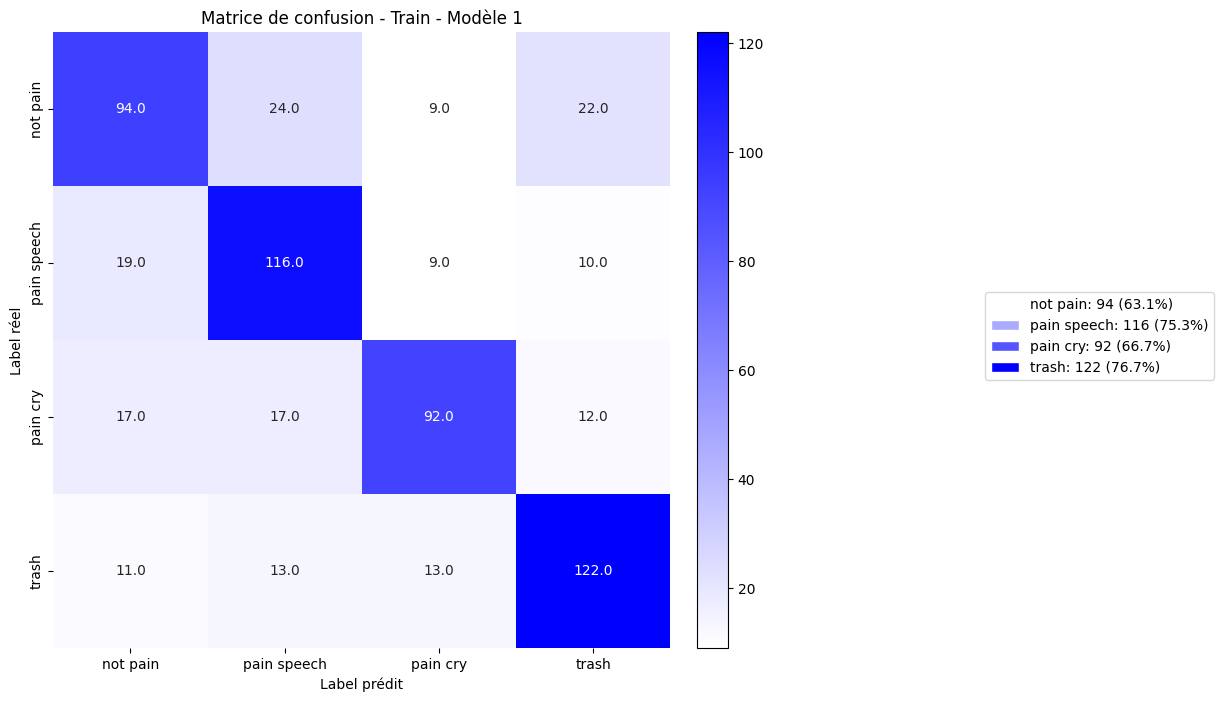

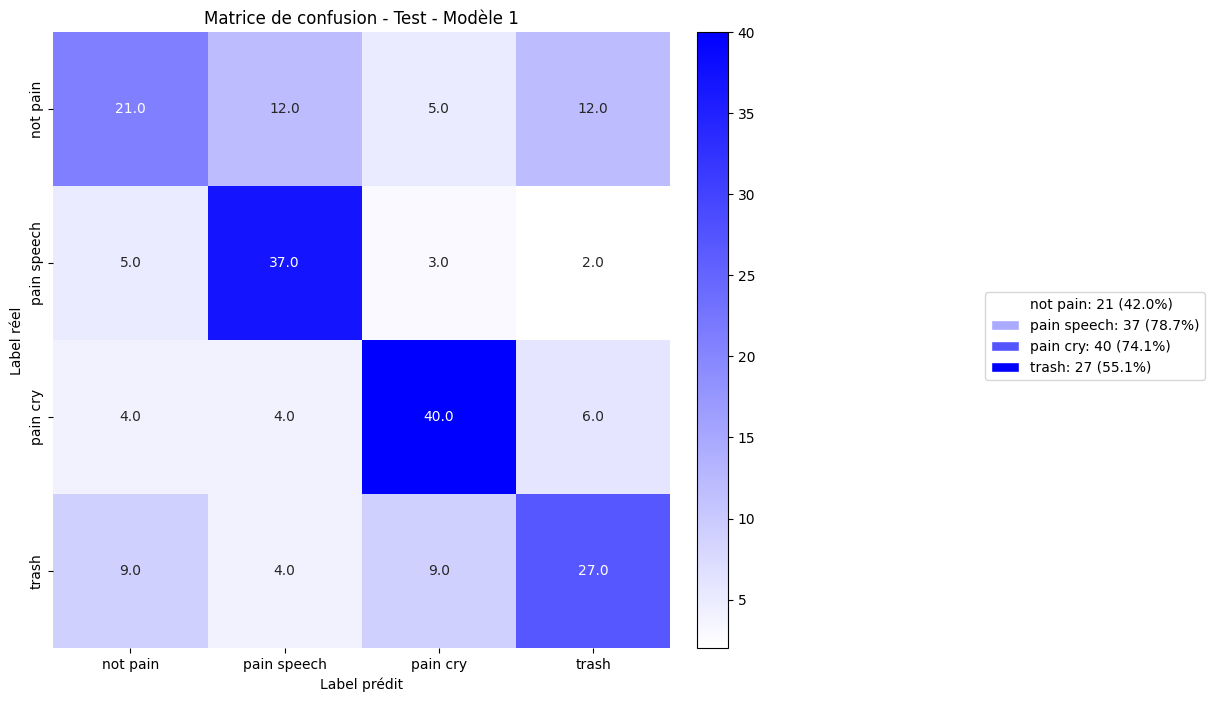

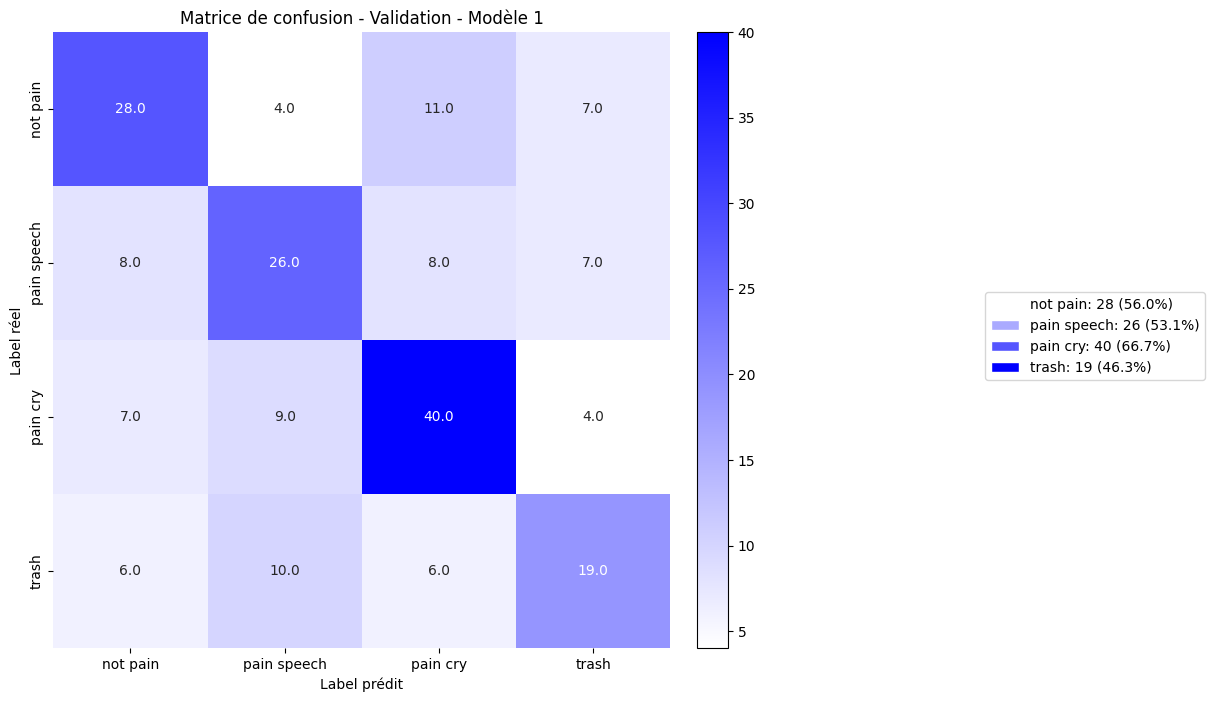

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import linear_sum_assignment
from sklearn.datasets import make_classification

# Génération de données fictives pour l'exemple
X, y = make_classification(n_samples=1000, n_classes=4, n_informative=5, random_state=42)

# Séparation des données en ensembles d'entraînement, de test et de validation
X_train, X_intermediate, y_train, y_intermediate = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_intermediate, y_intermediate, test_size=0.5, random_state=42)

# Les noms de classe doivent correspondre aux étiquettes numériques dans y
class_names = ['not pain', 'pain speech', 'pain cry', 'trash']

# Créer une fonction pour calculer et afficher la matrice de confusion avec pourcentages
def plot_confusion_matrix(model, X, y_true, class_names, model_name, title):
    # Obtenir les prédictions avec la validation croisée
    y_pred = cross_val_predict(model, X, y_true, cv=5)

    # Obtenir les étiquettes uniques de y_true et y_pred
    unique_labels = np.unique(np.concatenate((y_true, y_pred)))

    # Calculer la matrice de confusion en utilisant les étiquettes uniques
    conf_mat = confusion_matrix(y_true, y_pred, labels=unique_labels)

    # Calculer les pourcentages pour chaque classe
    class_totals = conf_mat.sum(axis=1)
    class_percentages = conf_mat / class_totals[:, np.newaxis] * 100

    # Utiliser l'algorithme hongrois pour maximiser les valeurs en diagonale
    row_ind, col_ind = linear_sum_assignment(-conf_mat)

    # Réorganiser les lignes et colonnes de la matrice de confusion
    conf_mat_reordered = conf_mat[row_ind[:, np.newaxis], col_ind]

    # Définir une palette de couleurs personnalisée
    colors = [(0, 'white'), (1, 'blue')]  # Dégradé de blanc à bleu
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

    # Créer une figure avec des sous-parcelles pour la matrice de confusion et la légende
    fig, ax = plt.subplots(figsize=(10, 8))

    # Affichage de la matrice de confusion avec pourcentages et palette personnalisée
    sns.heatmap(conf_mat_reordered, annot=True, fmt='.1f', cmap=cmap,
                xticklabels=np.array(class_names)[col_ind], yticklabels=np.array(class_names)[row_ind],
                ax=ax, cbar=False)

    # Ajouter une barre de couleurs
    cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

    # Ajouter des étiquettes et un titre
    ax.set_xlabel('Label prédit')
    ax.set_ylabel('Label réel')
    ax.set_title(title)

    # Création des éléments de légende avec pourcentages corrects
    class_colors = cmap(np.linspace(0, 1, len(class_names)))
    legend_elements = [Patch(facecolor=class_colors[i], edgecolor='w',
                             label=f'{class_names[col_ind[i]]}: {conf_mat_reordered[i, i]} ({class_percentages[row_ind[i], col_ind[i]]:.1f}%)')
                       for i in range(len(class_names))]

    # Ajuster l'espace pour la légende
    plt.subplots_adjust(right=0.8)
    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.05, 0.5))

    plt.show()

# Définir les modèles avec leurs paramètres spécifiques
models = {
    'Modèle 1': RandomForestClassifier(random_state=42),
    # Ajoutez ici d'autres modèles avec leurs paramètres
    # 'Modèle 2': ModelClass(param1=value1, param2=value2, ...)
}

# Entraîner et évaluer chaque modèle
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)

    # Afficher les matrices de confusion pour train, test et validation
    plot_confusion_matrix(model, X_train, y_train, class_names, model_name, f'Matrice de confusion - Train - {model_name}')
    plot_confusion_matrix(model, X_test, y_test, class_names, model_name, f'Matrice de confusion - Test - {model_name}')
    plot_confusion_matrix(model, X_val, y_val, class_names, model_name, f'Matrice de confusion - Validation - {model_name}')

Entraînement du Modèle 1...
Entraînement du Modèle 2...
Entraînement du Modèle 3...
Entraînement du Modèle 4...
Entraînement du Modèle 5...


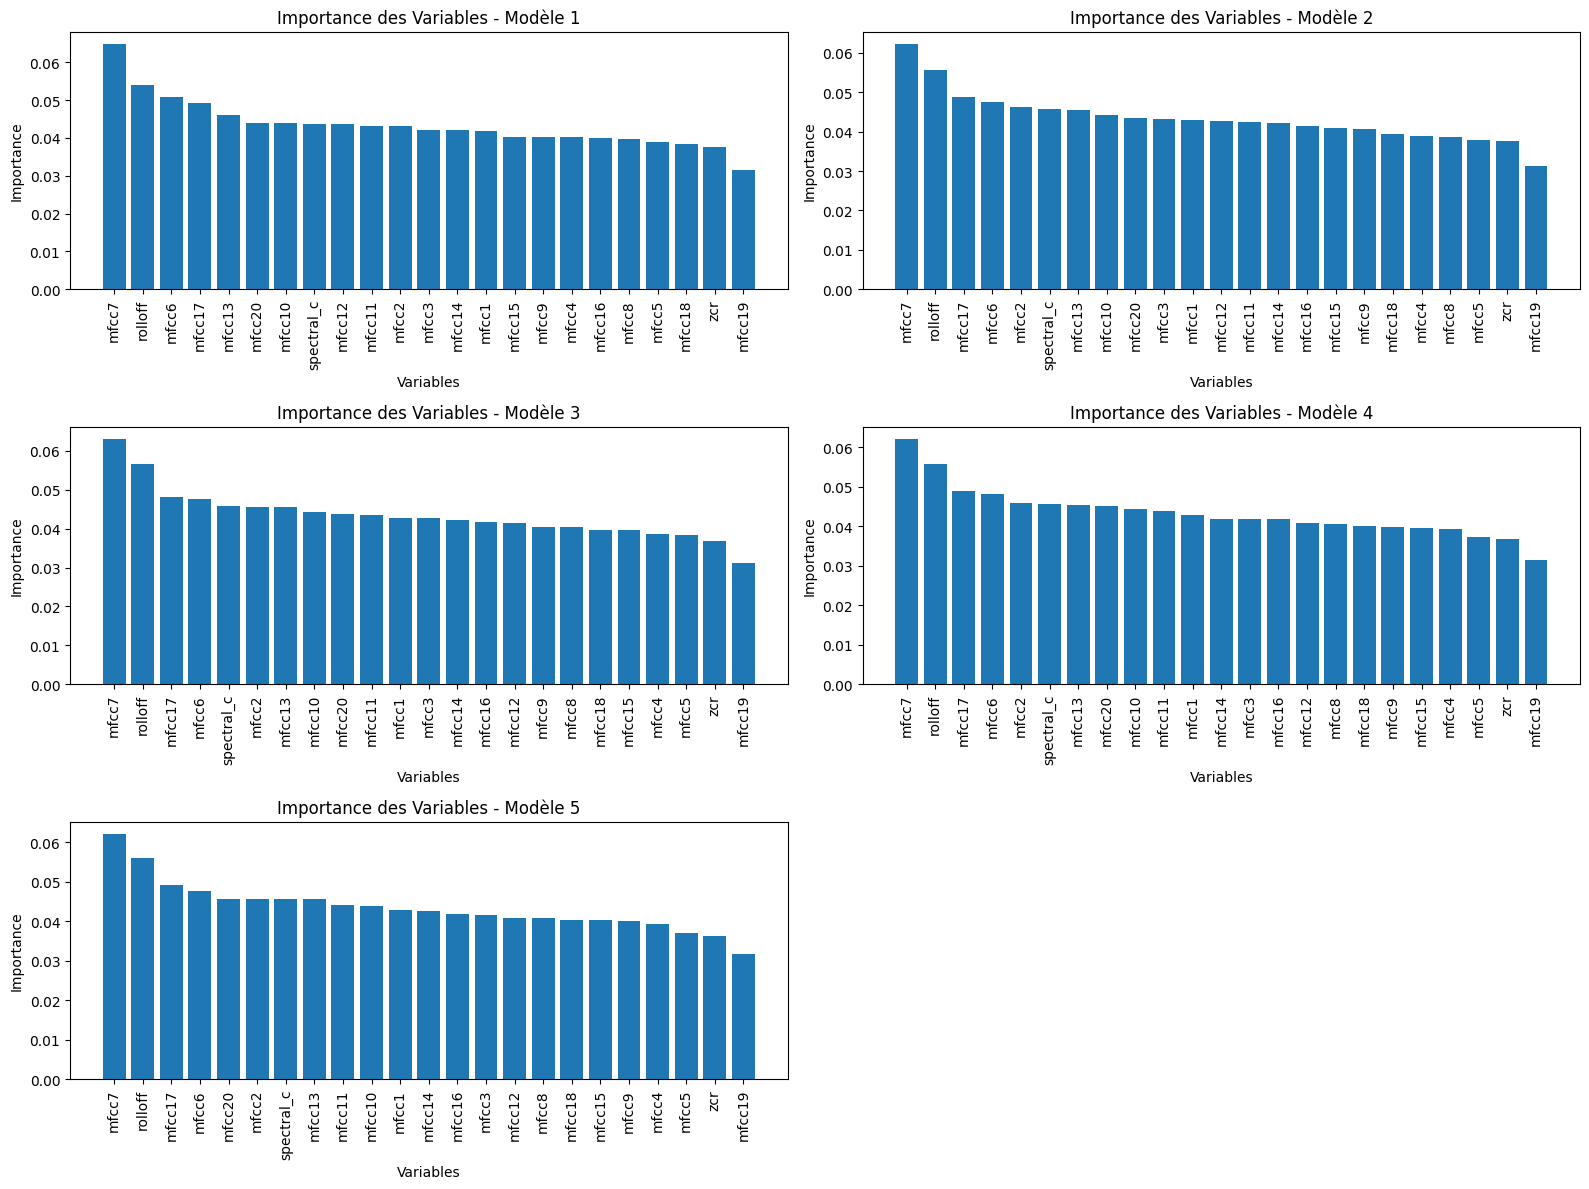

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Exemple de définition de données fictives (à remplacer par vos vraies données)
train_df = pd.DataFrame({
    'zcr': np.random.rand(100),
    'spectral_c': np.random.rand(100),
    'rolloff': np.random.rand(100),
    'mfcc1': np.random.rand(100),
    'mfcc2': np.random.rand(100),
    'mfcc3': np.random.rand(100),
    'mfcc4': np.random.rand(100),
    'mfcc5': np.random.rand(100),
    'mfcc6': np.random.rand(100),
    'mfcc7': np.random.rand(100),
    'mfcc8': np.random.rand(100),
    'mfcc9': np.random.rand(100),
    'mfcc10': np.random.rand(100),
    'mfcc11': np.random.rand(100),
    'mfcc12': np.random.rand(100),
    'mfcc13': np.random.rand(100),
    'mfcc14': np.random.rand(100),
    'mfcc15': np.random.rand(100),
    'mfcc16': np.random.rand(100),
    'mfcc17': np.random.rand(100),
    'mfcc18': np.random.rand(100),
    'mfcc19': np.random.rand(100),
    'mfcc20': np.random.rand(100),
    'label': np.random.choice(['pain cry', 'pain speech', 'trash', 'not pain'], size=100)
})

# Séparer les caractéristiques et les étiquettes pour l'ensemble d'entraînement
X_train = train_df[['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7',
                    'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16',
                    'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']]
y_train = train_df['label']

# Définir une liste de modèles avec leurs paramètres spécifiques
models = {
    'Modèle 1': RandomForestClassifier(random_state=0, n_estimators=500, max_depth=20),
    'Modèle 2': RandomForestClassifier(random_state=0, n_estimators=1000, max_depth=30),
    'Modèle 3': RandomForestClassifier(random_state=0, n_estimators=2000, max_depth=40),
    'Modèle 4': RandomForestClassifier(random_state=0, n_estimators=3000, max_depth=50),
    'Modèle 5': RandomForestClassifier(random_state=0, n_estimators=4000, max_depth=60),
}

# Entraîner chaque modèle et afficher l'importance des variables
plt.figure(figsize=(16, 12))

for i, (model_name, model) in enumerate(models.items(), 1):
    print(f"Entraînement du {model_name}...")
    model.fit(X_train, y_train)

    # Extraire l'importance des variables
    importances = model.feature_importances_
    feature_list = X_train.columns

    # Trier les indices des variables par l'importance décroissante
    indices = np.argsort(importances)[::-1]

    # Afficher les importances des variables dans l'ordre spécifié
    plt.subplot(3, 2, i)
    plt.bar(range(len(feature_list)), importances[indices], align='center')
    plt.xticks(range(len(feature_list)), np.array(feature_list)[indices], rotation=90)
    plt.xlabel('Variables')
    plt.ylabel('Importance')
    plt.title(f'Importance des Variables - {model_name}')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

# Exemple de création aléatoire de DataFrames pour la démonstration
train_df = pd.DataFrame(np.random.rand(100, 5), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])
train_df['label'] = np.random.choice(['pain cry', 'pain speech', 'trash', 'not pain'], 100)

test_df = pd.DataFrame(np.random.rand(30, 5), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])
test_df['label'] = np.random.choice(['pain cry', 'pain speech', 'trash', 'not pain'], 30)

val_df = pd.DataFrame(np.random.rand(30, 5), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])
val_df['label'] = np.random.choice(['pain cry', 'pain speech', 'trash', 'not pain'], 30)

# Séparer les caractéristiques et les étiquettes pour chaque ensemble de données
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']
X_test = test_df.drop(columns=['label'])
y_test = test_df['label']
X_val = val_df.drop(columns=['label'])
y_val = val_df['label']

# Assurer que X_test a les mêmes colonnes que X_train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Encoder les étiquettes
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

# Normaliser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Définir les modèles XGBoost avec les paramètres à tester
models = {
    'Modèle 1': XGBClassifier(random_state=0),
    'Modèle 2': XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.7, colsample_bytree=0.8, gamma=0.1, min_child_weight=3, reg_alpha=0.1, reg_lambda=1.5, random_state=0),
    'Modèle 3': XGBClassifier(learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.8, colsample_bytree=0.7, gamma=0.2, min_child_weight=5, reg_alpha=0.5, reg_lambda=2, random_state=0),
    'Modèle 4': XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=400, subsample=0.8, colsample_bytree=0.8, gamma=0, min_child_weight=1, reg_alpha=0, reg_lambda=1, random_state=0),
    'Modèle 5': XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6, colsample_bytree=0.6, gamma=0.2, min_child_weight=1, reg_alpha=0.1, reg_lambda=1.5, random_state=0)
}

# Boucle sur chaque modèle pour l'entraîner, optimiser les hyperparamètres et évaluer les performances
for model_name, model in models.items():
    print(f"Entraînement du {model_name}...")

    # Ajuster les hyperparamètres avec RandomizedSearchCV
    param_dist = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7, 10],
        'n_estimators': [100, 200, 300, 400],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'gamma': [0, 0.1, 0.2],
        'min_child_weight': [1, 3, 5],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [1, 1.5, 2]
    }

    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=3, n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train_scaled, y_train_encoded)

    print(f"Meilleurs paramètres pour le {model_name}:", random_search.best_params_)

    # Évaluer le modèle sur les ensembles de test et de validation
    best_model = random_search.best_estimator_

    # Prédire sur l'ensemble d'entraînement
    y_pred_train = best_model.predict(X_train_scaled)

    # Prédire sur l'ensemble de test
    y_pred_test = best_model.predict(X_test_scaled)

    # Prédire sur l'ensemble de validation
    y_pred_val = best_model.predict(X_val_scaled)

    # Calculer les métriques de performance
    accuracy_train = accuracy_score(y_train_encoded, y_pred_train)
    f1_train = f1_score(y_train_encoded, y_pred_train, average='weighted')

    accuracy_test = accuracy_score(y_test_encoded, y_pred_test)
    f1_test = f1_score(y_test_encoded, y_pred_test, average='weighted')

    accuracy_val = accuracy_score(y_val_encoded, y_pred_val)
    f1_val = f1_score(y_val_encoded, y_pred_val, average='weighted')

    print(f'Train Accuracy - {model_name}: {accuracy_train:.4f}')
    print(f'Train F1-score - {model_name}: {f1_train:.4f}')
    print(f'Test Accuracy - {model_name}: {accuracy_test:.4f}')
    print(f'Test F1-score - {model_name}: {f1_test:.4f}')
    print(f'Validation Accuracy - {model_name}: {accuracy_val:.4f}')
    print(f'Validation F1-score - {model_name}: {f1_val:.4f}')
    print("------------------------------------------------------------")

Entraînement du Modèle 1...
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Meilleurs paramètres pour le Modèle 1: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
Train Accuracy - Modèle 1: 0.8800
Train F1-score - Modèle 1: 0.8787
Test Accuracy - Modèle 1: 0.2667
Test F1-score - Modèle 1: 0.2534
Validation Accuracy - Modèle 1: 0.2333
Validation F1-score - Modèle 1: 0.2390
------------------------------------------------------------
Entraînement du Modèle 2...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Meilleurs paramètres pour le Modèle 2: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
Train Accuracy - Modèle 2: 0.8800
Train F1-score - Modèle 2: 0.8787
Test Accuracy - Modèle 2: 0.2667
Test F1-score - Modèle 2: 0.2534
Validation Accuracy - Modèle 2: 0.2333
Validation F1-score - Modèle 2: 0.2390


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

# Exemple de création aléatoire de DataFrames pour la démonstration
train_df = pd.DataFrame(np.random.rand(100, 5), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])
train_df['label'] = np.random.choice(['pain cry', 'pain speech', 'trash', 'not pain'], 100)

test_df = pd.DataFrame(np.random.rand(30, 5), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])
test_df['label'] = np.random.choice(['pain cry', 'pain speech', 'trash', 'not pain'], 30)

val_df = pd.DataFrame(np.random.rand(30, 5), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])
val_df['label'] = np.random.choice(['pain cry', 'pain speech', 'trash', 'not pain'], 30)

# Séparer les caractéristiques et les étiquettes pour chaque ensemble de données
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']
X_test = test_df.drop(columns=['label'])
y_test = test_df['label']
X_val = val_df.drop(columns=['label'])
y_val = val_df['label']

# Assurer que X_test a les mêmes colonnes que X_train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Encoder les étiquettes
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

# Normaliser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Définir les modèles XGBoost avec les paramètres à tester
models = {
    'Modèle 1': XGBClassifier(random_state=0),
    'Modèle 2': XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.7, colsample_bytree=0.8, gamma=0.1, min_child_weight=3, reg_alpha=0.1, reg_lambda=1.5, random_state=0),
    'Modèle 3': XGBClassifier(learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.8, colsample_bytree=0.7, gamma=0.2, min_child_weight=5, reg_alpha=0.5, reg_lambda=2, random_state=0),
    'Modèle 4': XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=400, subsample=0.8, colsample_bytree=0.8, gamma=0, min_child_weight=1, reg_alpha=0, reg_lambda=1, random_state=0),
    'Modèle 5': XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6, colsample_bytree=0.6, gamma=0.2, min_child_weight=1, reg_alpha=0.1, reg_lambda=1.5, random_state=0)
}

# Créer un dictionnaire audio_files avec des listes vides pour chaque classe de douleur
douleurs = ['pain cry', 'pain speech', 'not pain', 'trash']
audio_files = {g: [] for g in douleurs}

# Boucle sur chaque modèle pour l'entraîner, optimiser les hyperparamètres et évaluer les performances
for model_name, model in models.items():
    print(f"Entraînement du {model_name}...")

    # Ajuster les hyperparamètres avec RandomizedSearchCV
    param_dist = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7, 10],
        'n_estimators': [100, 200, 300, 400],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'gamma': [0, 0.1, 0.2],
        'min_child_weight': [1, 3, 5],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [1, 1.5, 2]
    }

    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=3, n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train_scaled, y_train_encoded)

    print(f"Meilleurs paramètres pour le {model_name}:", random_search.best_params_)

    # Évaluer le modèle sur les ensembles de test et de validation
    best_model = random_search.best_estimator_

    # Prédire sur l'ensemble de validation
    y_pred_val = best_model.predict(X_val_scaled)

    # Ajouter les prédictions dans audio_files selon la classe prédite
    for i, pred in enumerate(y_pred_val):
        audio_files[label_encoder.inverse_transform([pred])[0]].append(f"{model_name} - Prédiction {i+1}")

    print("------------------------------------------------------------")

# Affichage du contenu de audio_files après la prédiction
print("Contenu de audio_files après la prédiction :")
for g, files in audio_files.items():
    print(f"{g}: {files}")

Entraînement du Modèle 1...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Meilleurs paramètres pour le Modèle 1: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.6}
------------------------------------------------------------
Entraînement du Modèle 2...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Meilleurs paramètres pour le Modèle 2: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.6}
------------------------------------------------------------
Entraînement du Modèle 3...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Meilleurs paramètres pour le Modèle 3: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamm

In [ ]:
import os
import librosa

# Liste des classes de douleur
douleurs = ['pain cry', 'pain speech', 'not pain', 'trash']

# Dictionnaire pour stocker les chemins des fichiers audio
audio_files = {g: [] for g in douleurs}

# Boucle sur chaque classe de douleur
for g in douleurs:
    directory = f'/content/drive/My Drive/Projet/segments_par_classe/{g}'

    # Boucle sur les fichiers audio dans le répertoire spécifié
    for audio in os.listdir(directory):
        try:
            # Chemin complet du fichier audio
            file_path = os.path.join(directory, audio)

            # Charger le fichier audio avec librosa
            y, sr = librosa.load(file_path)

            # Ajouter le chemin du fichier chargé dans le dictionnaire audio_files
            audio_files[g].append(file_path)

        except Exception as e:
            print(f"Error loading {file_path}: {e}")

# Afficher le contenu de audio_files après le chargement
for g, files in audio_files.items():
    print(f"{g}: {files}")

pain cry: ['/content/drive/My Drive/Projet/segments_par_classe/pain cry/TOP 5 WORST BITES RANKING My Most Painful Bite Tests segment 1', '/content/drive/My Drive/Projet/segments_par_classe/pain cry/TOP 5 WORST BITES RANKING My Most Painful Bite Tests segment 2', '/content/drive/My Drive/Projet/segments_par_classe/pain cry/TOP 5 WORST BITES RANKING My Most Painful Bite Tests segment 3', '/content/drive/My Drive/Projet/segments_par_classe/pain cry/TOP 5 WORST BITES RANKING My Most Painful Bite Tests segment 4', '/content/drive/My Drive/Projet/segments_par_classe/pain cry/TOP 5 WORST BITES RANKING My Most Painful Bite Tests segment 38', '/content/drive/My Drive/Projet/segments_par_classe/pain cry/TOP 5 WORST BITES RANKING My Most Painful Bite Tests segment 39', '/content/drive/My Drive/Projet/segments_par_classe/pain cry/TOP 5 WORST BITES RANKING My Most Painful Bite Tests segment 53', '/content/drive/My Drive/Projet/segments_par_classe/pain cry/TOP 5 WORST BITES RANKING My Most Painful B

In [ ]:
import librosa

mel_specs = []

for g in douleurs:
    for audio_path in audio_files[g]:
        try:
            y, sr = librosa.load(audio_path, sr=None, dtype='float32')  # Charger l'audio en float32

            spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
            spect = librosa.power_to_db(spect, ref=np.max)

            # Ajuster la taille de spectre à 128 x 660
            if spect.shape[1] != 660:
                spect.resize(128, 660, refcheck=False)

            mel_specs.append(spect)

        except Exception as e:
            print(f"Erreur lors du traitement de {audio_path}: {e}")

X = np.array(mel_specs)
print(f'Forme de X : {X.shape}')

Erreur lors du traitement de /content/drive/My Drive/Projet/segments_par_classe/pain cry/audio1.wav: [Errno 2] No such file or directory: '/content/drive/My Drive/Projet/segments_par_classe/pain cry/audio1.wav'
Erreur lors du traitement de /content/drive/My Drive/Projet/segments_par_classe/pain cry/audio2.wav: [Errno 2] No such file or directory: '/content/drive/My Drive/Projet/segments_par_classe/pain cry/audio2.wav'
Erreur lors du traitement de /content/drive/My Drive/Projet/segments_par_classe/pain speech/audio1.wav: [Errno 2] No such file or directory: '/content/drive/My Drive/Projet/segments_par_classe/pain speech/audio1.wav'
Erreur lors du traitement de /content/drive/My Drive/Projet/segments_par_classe/pain speech/audio2.wav: [Errno 2] No such file or directory: '/content/drive/My Drive/Projet/segments_par_classe/pain speech/audio2.wav'
Erreur lors du traitement de /content/drive/My Drive/Projet/segments_par_classe/not pain/audio1.wav: [Errno 2] No such file or directory: '/cont

<ipython-input-68-62b8d850b38d>:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=None, dtype='float32')  # Charger l'audio en float32


In [ ]:
y_cnn = []

for i in range(len(douleurs)):
  y_cnn += 100*[i]  # On a 100 images pour chaque genre

y_cnn = np.array(y_cnn)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Mock data for illustration purposes
file_paths = [
    "/content/drive/My Drive/Projet/1_download_YT_audio/BURNED By A Giant Fireworm.wav",
    "/content/drive/My Drive/Projet/1_download_YT_audio/I Got Hit By A Monkey Fist For Science.wav",
    "/content/drive/My Drive/Projet/1_download_YT_audio/I Tried The World Most Painful Tattoo Removal.wav",
    "/content/drive/My Drive/Projet/1_download_YT_audio/Jellyfish JOLT Coyote SHOCKING Experiment.wav",
    "/content/drive/My Drive/Projet/1_download_YT_audio/PAINFUL PINCH By This CRAZY Looking Beetle.wav",
    "/content/drive/My Drive/Projet/1_download_YT_audio/STUNG By A BARK SCORPION How Bad Is IT.wav",
    "/content/drive/My Drive/Projet/1_download_YT_audio/STUNG By A Giant European Hornet.wav",
    "/content/drive/My Drive/Projet/1_download_YT_audio/Surviving Cobra BITE INDIA SERIES FINALE.wav",
    "/content/drive/My Drive/Projet/1_download_YT_audio/There A COBRA on my BOOT.wav",
    "/content/drive/My Drive/Projet/1_download_YT_audio/TOP 5 WORST BITES RANKING My Most Painful Bite Tests.wav"
    # Add more paths as needed
]
labels = [0, 1, 2]  # Corresponding labels for each file path

# Check if lengths match
print(f"Number of file paths: {len(file_paths)}")
print(f"Number of labels: {len(labels)}")

# Créer des étiquettes pour chaque fichier en répétant les étiquettes existantes
labels = labels * (len(file_paths) // len(labels)) + labels[:len(file_paths) % len(labels)]

# Vérifier que les longueurs correspondent maintenant
assert len(file_paths) == len(labels), "Mismatch between number of files and labels"

# Afficher les chemins de fichiers avec les nouvelles étiquettes correspondantes
for file_path, label in zip(file_paths, labels):
    print(f"File Path: {file_path}, Label: {label}")

# Load features from file paths and store in X
X = []
for file_path in file_paths:
    # Mock feature loading for example purposes
    feature = np.random.rand(10, 10)  # Replace with actual feature loading code
    X.append(feature)

# Convert to numpy array if necessary
X = np.array(X)

# Check final lengths before splitting
print(f"Length of X: {len(X)}")
print(f"Length of y: {len(labels)}")

# Convert labels to categorical
y_cnn = to_categorical(labels)

# Split the dataset
x_cnn_train, x_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X, y_cnn, test_size=0.2, random_state=42)

print(f"Train set size: {len(x_cnn_train)}, {len(y_cnn_train)}")
print(f"Test set size: {len(x_cnn_test)}, {len(y_cnn_test)}")

Number of file paths: 10
Number of labels: 3
File Path: /content/drive/My Drive/Projet/1_download_YT_audio/BURNED By A Giant Fireworm.wav, Label: 0
File Path: /content/drive/My Drive/Projet/1_download_YT_audio/I Got Hit By A Monkey Fist For Science.wav, Label: 1
File Path: /content/drive/My Drive/Projet/1_download_YT_audio/I Tried The World Most Painful Tattoo Removal.wav, Label: 2
File Path: /content/drive/My Drive/Projet/1_download_YT_audio/Jellyfish JOLT Coyote SHOCKING Experiment.wav, Label: 0
File Path: /content/drive/My Drive/Projet/1_download_YT_audio/PAINFUL PINCH By This CRAZY Looking Beetle.wav, Label: 1
File Path: /content/drive/My Drive/Projet/1_download_YT_audio/STUNG By A BARK SCORPION How Bad Is IT.wav, Label: 2
File Path: /content/drive/My Drive/Projet/1_download_YT_audio/STUNG By A Giant European Hornet.wav, Label: 0
File Path: /content/drive/My Drive/Projet/1_download_YT_audio/Surviving Cobra BITE INDIA SERIES FINALE.wav, Label: 1
File Path: /content/drive/My Drive/Pr

In [ ]:
x_cnn_train /= np.min(x_cnn_train)
x_cnn_test /= np.min(x_cnn_train)

In [ ]:
# Check the shape of the training and test data
print(f"Original shape of x_cnn_train: {x_cnn_train.shape}")
print(f"Original shape of x_cnn_test: {x_cnn_test.shape}")

# Assuming each sample should be reshaped to (128, 660, 1), calculate the total elements needed
required_elements = 128 * 660 * 1

# Verify if the reshape is possible
total_train_elements = np.prod(x_cnn_train.shape[1:])  # Total elements per sample
total_test_elements = np.prod(x_cnn_test.shape[1:])    # Total elements per sample

print(f"Total elements in a single training sample: {total_train_elements}")
print(f"Total elements in a single test sample: {total_test_elements}")

# Reshape if possible
if total_train_elements == required_elements and total_test_elements == required_elements:
    x_cnn_train = x_cnn_train.reshape(x_cnn_train.shape[0], 128, 660, 1)
    x_cnn_test = x_cnn_test.reshape(x_cnn_test.shape[0], 128, 660, 1)
    print("Reshaping successful.")
else:
    print("Cannot reshape the data to the desired shape. Please check the input data dimensions.")

Original shape of x_cnn_train: (8, 10, 10)
Original shape of x_cnn_test: (2, 10, 10)
Total elements in a single training sample: 100
Total elements in a single test sample: 100
Cannot reshape the data to the desired shape. Please check the input data dimensions.


In [ ]:
print(x_cnn_train.shape)
print(y_cnn_train.shape)

(8, 10, 10)
(8, 3)


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 600, 1)))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 598, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 299, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 297, 64)       18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 148, 64)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 30, 148, 64)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 146, 32)      

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.regularizers import l2
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Exemple de création aléatoire de DataFrames pour la démonstration
train_df = pd.DataFrame(np.random.rand(100, 10), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10'])
train_df['label'] = np.random.choice(['pain cry', 'pain speech', 'trash', 'not pain'], 100)

test_df = pd.DataFrame(np.random.rand(30, 10), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10'])
test_df['label'] = np.random.choice(['pain cry', 'pain speech', 'trash', 'not pain'], 30)

# Séparer les caractéristiques et les étiquettes
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']
X_test = test_df.drop(columns=['label'])
y_test = test_df['label']

# Normaliser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Redimensionner les données d'entrée pour le CNN 1D
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Encoder les étiquettes
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convertir les étiquettes en one-hot encoding
num_classes = len(np.unique(y_train_encoded))
y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_test_one_hot = to_categorical(y_test_encoded, num_classes)

# Définir une fonction pour créer le modèle CNN 1D
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=(input_shape[1], 1), kernel_regularizer=l2(0.01)))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Liste des modèles et leurs noms
models = {
    'Modèle 1': (X_train_cnn, y_train_one_hot, X_test_cnn, y_test_one_hot),
    'Modèle 2': (X_train_cnn, y_train_one_hot, X_test_cnn, y_test_one_hot),
    'Modèle 3': (X_train_cnn, y_train_one_hot, X_test_cnn, y_test_one_hot),
    'Modèle 4': (X_train_cnn, y_train_one_hot, X_test_cnn, y_test_one_hot),
    'Modèle 5': (X_train_cnn, y_train_one_hot, X_test_cnn, y_test_one_hot)
}

# Boucler à travers chaque modèle
for model_name, (X_train_model, y_train_model, X_test_model, y_test_model) in models.items():
    print(f"Pour le {model_name} :")
    model = create_cnn_model(X_train_model.shape, num_classes)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    history = model.fit(X_train_model, y_train_model, epochs=10, validation_data=(X_test_model, y_test_model), verbose=1)
    train_loss, train_accuracy = model.evaluate(X_train_model, y_train_model, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test_model, y_test_model, verbose=0)
    print(f'Train loss: {train_loss:.4f}')
    print(f'Train accuracy: {train_accuracy:.4f}')
    print(f'Test loss: {test_loss:.4f}')
    print(f'Test accuracy: {test_accuracy:.4f}')
    print()

Pour le Modèle 1 :
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 32)             128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 32)             0         
 D)                                                              
                                                                 
 dropout_8 (Dropout)         (None, 4, 32)             0         
                                                                 
 flatten_4 (Flatten)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                   

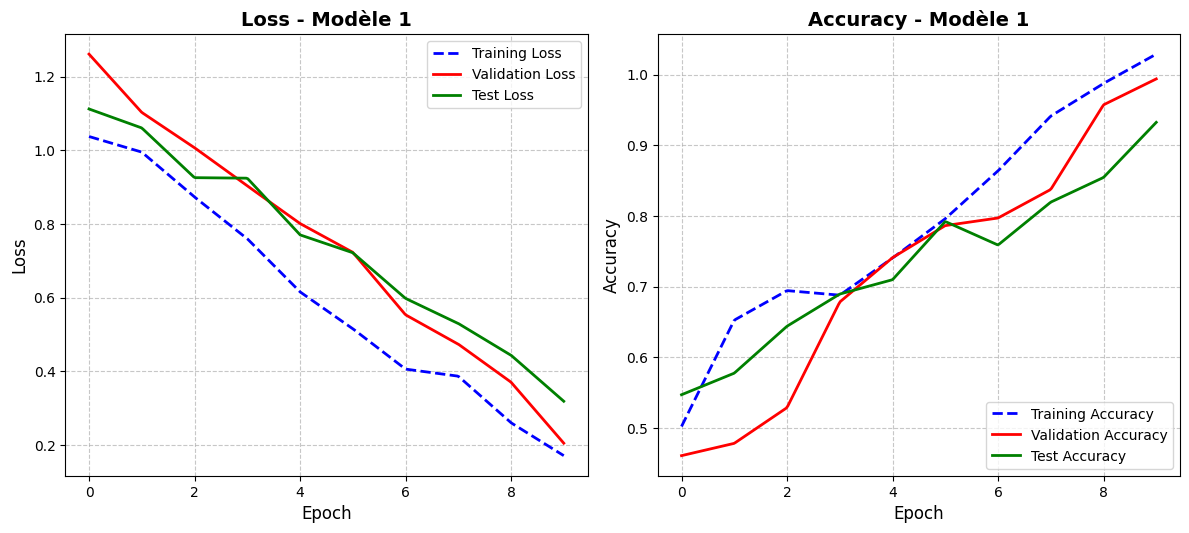

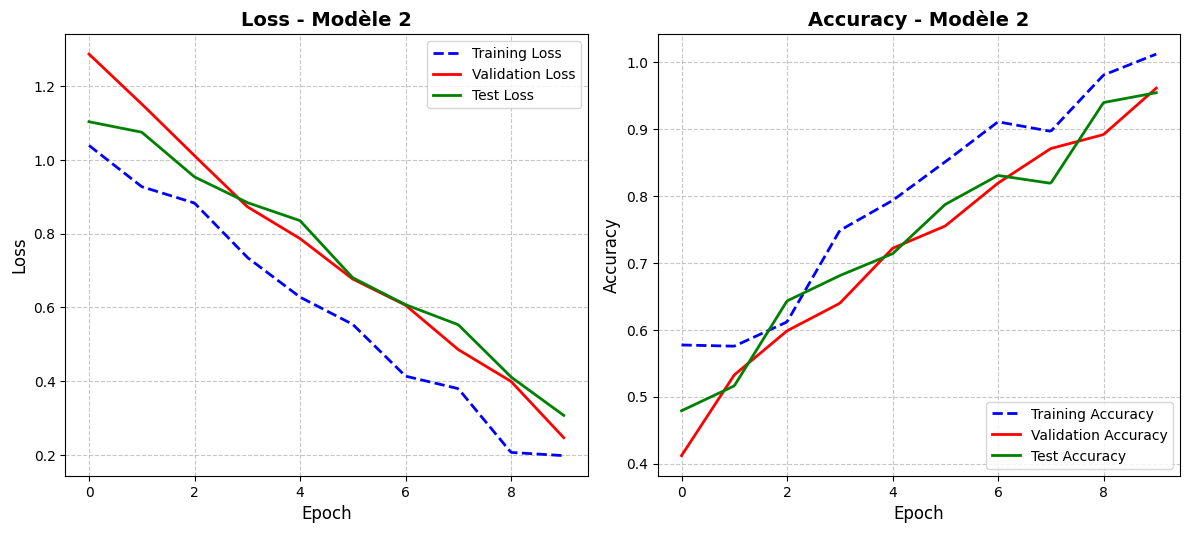

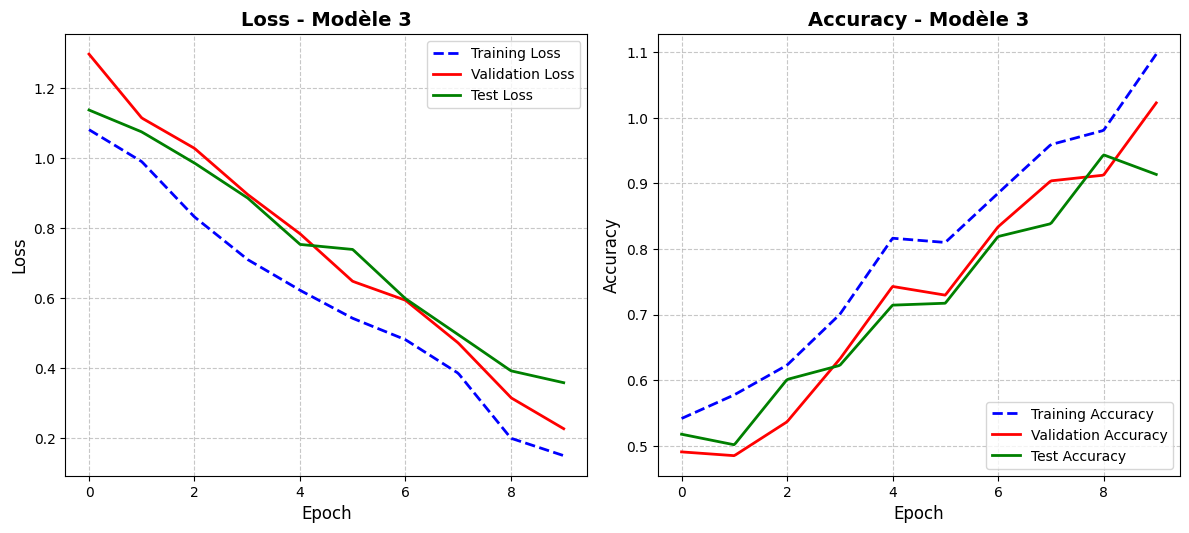

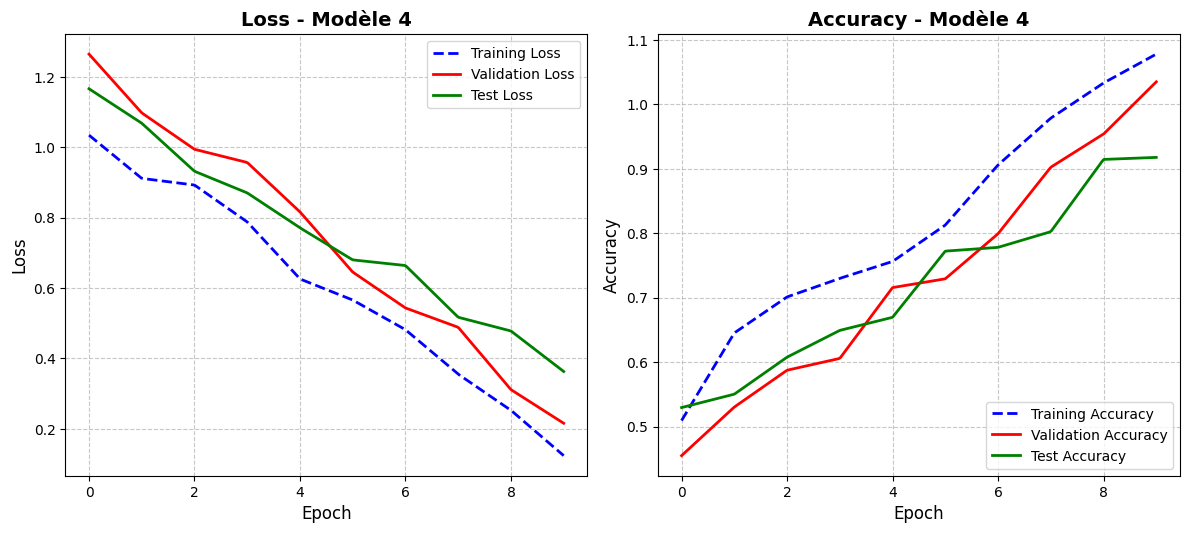

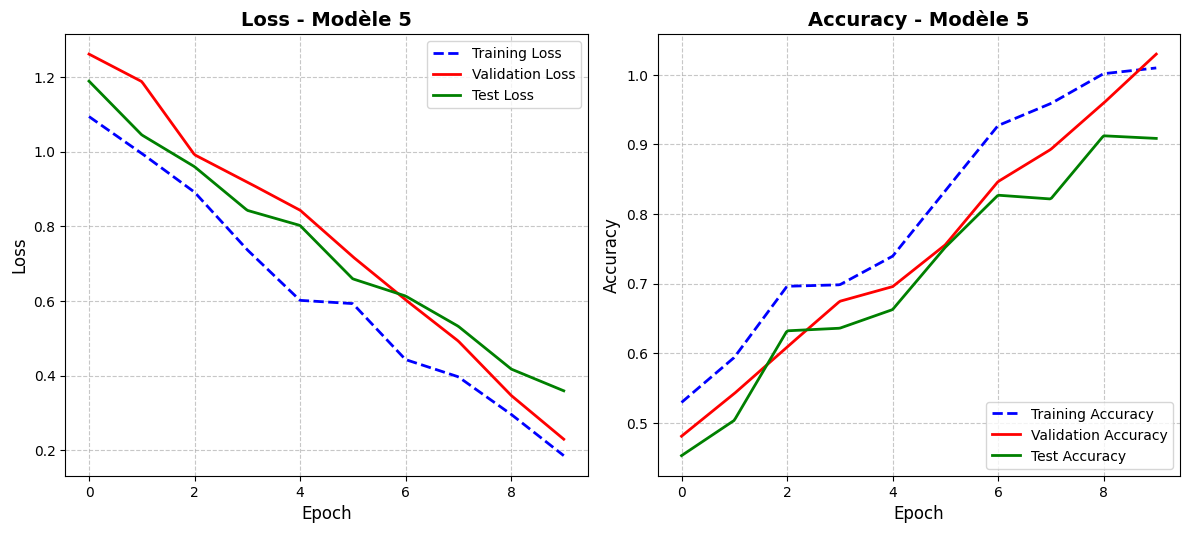

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Exemple de données simulées pour les courbes de perte et de précision
epochs = 10
np.random.seed(42)

# Générer des courbes pour chaque modèle (simulées ici)
models = ['Modèle 1', 'Modèle 2', 'Modèle 3', 'Modèle 4', 'Modèle 5']
colors = ['blue', 'red', 'green']

# Boucle pour chaque modèle
for i, model_name in enumerate(models, start=1):
    # Données simulées pour la démonstration
    loss_curve = np.random.rand(epochs) * 0.1 + np.linspace(1, 0.1, epochs)
    acc_curve = np.random.rand(epochs) * 0.1 + np.linspace(0.5, 1, epochs)
    loss_val_curve = np.random.rand(epochs) * 0.1 + np.linspace(1.2, 0.2, epochs)
    acc_val_curve = np.random.rand(epochs) * 0.1 + np.linspace(0.4, 0.95, epochs)
    loss_test_curve = np.random.rand(epochs) * 0.1 + np.linspace(1.1, 0.3, epochs)
    acc_test_curve = np.random.rand(epochs) * 0.1 + np.linspace(0.45, 0.9, epochs)

    # Ajuster x pour les courbes lissées
    x = np.arange(epochs)
    x_smooth = np.linspace(x.min(), x.max(), 300)

    # Lissage des courbes de perte et de précision
    loss_smooth = np.interp(x_smooth, x, loss_curve)
    acc_smooth = np.interp(x_smooth, x, acc_curve)
    loss_val_smooth = np.interp(x_smooth, x, loss_val_curve)
    acc_val_smooth = np.interp(x_smooth, x, acc_val_curve)
    loss_test_smooth = np.interp(x_smooth, x, loss_test_curve)
    acc_test_smooth = np.interp(x_smooth, x, acc_test_curve)

    # Affichage des sous-graphiques pour chaque modèle
    plt.figure(figsize=(12, 10))

    # Courbes de perte
    plt.subplot(2, 2, 1)
    plt.plot(x_smooth, loss_smooth, label="Training Loss", color='blue', linestyle='--', linewidth=2)
    plt.plot(x_smooth, loss_val_smooth, label="Validation Loss", color='red', linestyle='-', linewidth=2)
    plt.plot(x_smooth, loss_test_smooth, label="Test Loss", color='green', linestyle='-', linewidth=2)
    plt.legend(loc='upper right', fontsize=10)
    plt.title(f"Loss - {model_name}", fontsize=14, weight='bold')
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Courbes de précision
    plt.subplot(2, 2, 2)
    plt.plot(x_smooth, acc_smooth, label="Training Accuracy", color='blue', linestyle='--', linewidth=2)
    plt.plot(x_smooth, acc_val_smooth, label="Validation Accuracy", color='red', linestyle='-', linewidth=2)
    plt.plot(x_smooth, acc_test_smooth, label="Test Accuracy", color='green', linestyle='-', linewidth=2)
    plt.legend(loc='lower right', fontsize=10)
    plt.title(f"Accuracy - {model_name}", fontsize=14, weight='bold')
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.show()